In [1]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3 import A2C, PPO, DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from custom_environment import GridEnvCNN, GridEnvMLP
from custom_policy import CustomCNN, CustomCNNPolicy, CustomCNNPolicyBPS
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder


In [2]:
class ActionStoreCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.actions = []

    def _on_step(self):
        self.actions.append(self.locals["actions"])
        return True
    


def plot_action_histogram(callback):   
    actions_array = np.array(callback.actions).flatten()
    plt.hist(actions_array, label = 'Action Histogram')
    plt.xlabel('Actions')
    plt.ylabel('n')
    plt.xticks([0,1,2,3], ['up', 'down', 'left', 'right'])
    plt.show()


def make_env(grids, goal = None, max_steps = 256, env_size = (64,64), goal_region = (64,64), bps_ = False):
    def _init():
        while True:
            while True: 
                start_x = np.random.choice(range(env_size[0]))
                start_y = np.random.choice(range(env_size[0]))
                start = (start_y, start_x)
                if start != goal: 
                    break
            if goal is None:
                while True: 
                    goal_x = np.random.choice(range(goal_region[0]))
                    goal_y = np.random.choice(range(goal_region[0]))
                    local_goal = (goal_y, goal_x)
                    if start != goal:
                        break
            else: local_goal = goal

            if isinstance(grids, list):
                grid = grids[np.random.choice(range(len(grids)))]
                env = GridEnvCNN(grid, start, local_goal, max_steps, bps_)

            else:
                grid = grids
                env = GridEnvCNN(grid, start, local_goal, max_steps, bps_)

            if grid[start] == 0 and grid[local_goal] == 0 and exists_path(grid, start, local_goal):
                return env
            
    return _init


def test_agent(model, grid_list, env_size = (64,64), goal = None, goal_region = (64,64), n = 100, bps = False):
    max_steps = 1000

    terminated_count = 0
    truncated_count = 0
    terminated_step_count = 0
    max_steps_count = 0
    for i in tqdm(range(n)):
        if isinstance(grid_list, list):
            grid = grid_list[np.random.choice(range(len(grid_list)))]
        else:
            grid = grid_list
        while True:
            while True:
                start_x = np.random.choice(range(env_size[0]))
                start_y = np.random.choice(range(env_size[0]))
                start = (start_y, start_x)
                if start != goal:
                    break
            if goal is None:
                    while True: 
                        goal_x = np.random.choice(range(goal_region[0]))
                        goal_y = np.random.choice(range(goal_region[0]))
                        local_goal = (goal_y, goal_x)
                        if start != goal:
                            break
            else: local_goal = goal

            if grid[start] == 0 and grid[local_goal] == 0 and exists_path(grid, start, local_goal):
                    break

        
        env = GridEnvCNN(grid, start, local_goal, max_steps, bps)




        obs, info = env.reset()
        for step in range(env.max_steps):
            action, _ = model.predict(obs, deterministic=True)
            
            obs, reward, terminated, truncated, info = env.step(action)
            
            if terminated or truncated:
                if terminated:
                    terminated_count += 1
                    terminated_step_count += step
                    if step > max_steps_count:
                        max_steps_count = step
                elif truncated:
                    truncated_count += 1
                break

    print('terminated: ', terminated_count/n * 100, f'% with an average of {terminated_step_count/terminated_count} steps and a maximum of {max_steps_count}')





def exists_path(grid, start, goal):
    matrix = (grid-1) * -1
    grid_obj = Grid(matrix=matrix)
    
    start_node = grid_obj.node(start[1], start[0])
    end_node = grid_obj.node(goal[1], goal[0])

    finder = AStarFinder()
    path, _ = finder.find_path(start_node, end_node, grid_obj)
    return len(path) > 0

# 16x16

1.0


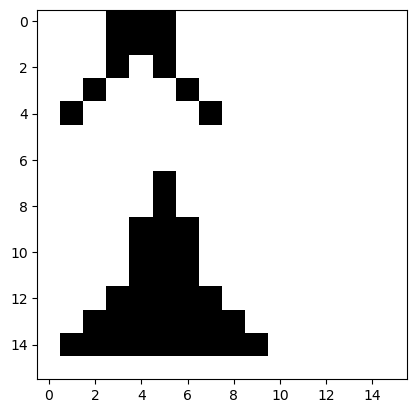

In [3]:
loaded = np.load('../environment_generation/environments/environments_16_2_10_1.npy')
loaded.shape

grid = loaded[9]
print(grid.max())
plt.imshow(grid, cmap='binary')

## random start, fixed goal, fixed empty env

In [ ]:
# random start point
from stable_baselines3.common.vec_env import DummyVecEnv
empty_grid = np.zeros((16, 16))
goal = (15,15)
max_steps = 32
lr = 2.5e-4
total_timesteps=200000
ent_coef = 0.01


def make_env():
    def _init():
        while True:
            start_x = np.random.choice(range(16))
            start_y = np.random.choice(range(16))
            start = (start_y, start_x)
            if start != goal:
                break
        return GridEnvMLP(empty_grid, start, goal, max_steps)
    return _init


env = DummyVecEnv([make_env() for _ in range(16)])

batch_size = 64
callback = ActionStoreCallback()
model = PPO("MlpPolicy", env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=1024, device='cpu', ent_coef= ent_coef).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212,992/200,000  [ 0:01:28 < 0:00:00 , 1,651 it/s ]

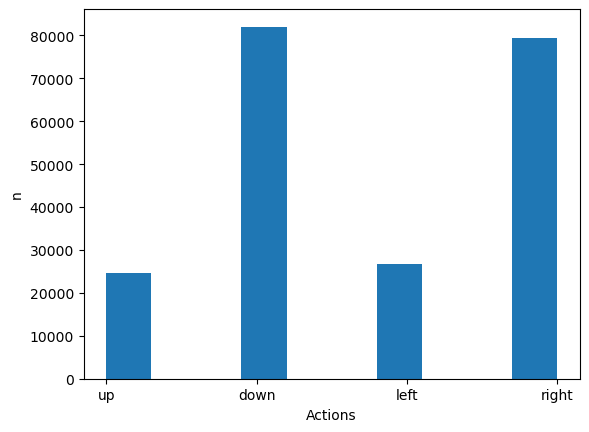

In [74]:
plot_action_histogram(callback)

In [ ]:
   
goal = (15, 15)
max_steps = 1000

n = 100
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    start_x = np.random.choice(range(16))
    start_y = np.random.choice(range(16))
    start = (start_y, start_x)

    env = GridEnv(empty_grid, start, goal, max_steps)
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "yellow"   # 3
])


start_x = np.random.choice(range(16))
start_y = np.random.choice(range(16))
start = (start_y, start_x)

goal = (15, 15)
max_steps = 1000

env = GridEnv(empty_grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)

images = []
plt.imshow(np.sum(obs, axis=0), cmap=cmap)
plt.show()
images.append(obs[0])

for i in range(50):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    images.append(obs[0])
    plt.imshow(obs[0], cmap=cmap)
    plt.show()
    if terminated:
        break

## random start, random goal, fixed empty env

In [79]:
# random start point
from stable_baselines3.common.vec_env import DummyVecEnv
env_size = (16, 16)
empty_grid = np.zeros(env_size)
goal = (15,15)
max_steps = 32
lr = 2.5e-4
total_timesteps=500000
ent_coef = 0.01
def get_random_point(env_size):
    point_x = np.random.choice(range(env_size[0]))
    point_y = np.random.choice(range(env_size[0]))
    point = (point_y, point_x)
    return point
def make_env():
    def _init():
        while True:
            start = get_random_point(env_size)
            goal = get_random_point(env_size)
            
            if start != goal:
                break
        return GridEnv(empty_grid, start, goal, max_steps)
    return _init


env = DummyVecEnv([make_env() for _ in range(16)])

batch_size = 64
callback = ActionStoreCallback()
model = PPO("MlpPolicy", env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=1024, device='cpu', ent_coef= ent_coef).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)


Output()

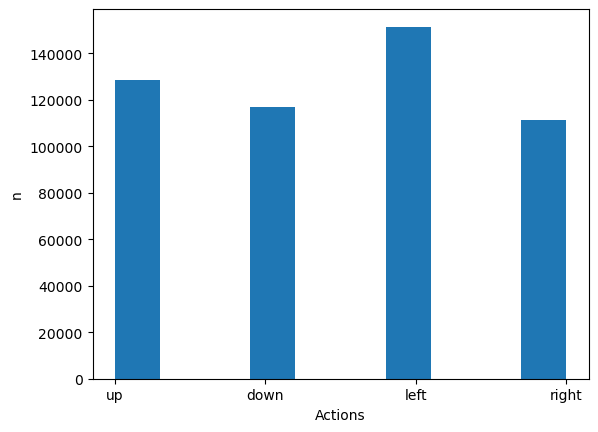

In [80]:
plot_action_histogram(callback)

In [68]:
goal = (15, 15)
max_steps = 1000

n = 100
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    start_x = np.random.choice(range(16))
    start_y = np.random.choice(range(16))
    start = (start_y, start_x)

    env = GridEnv(empty_grid, start, goal, max_steps)
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

100%|██████████| 100/100 [00:25<00:00,  3.89it/s]

terminated:  0.0 %


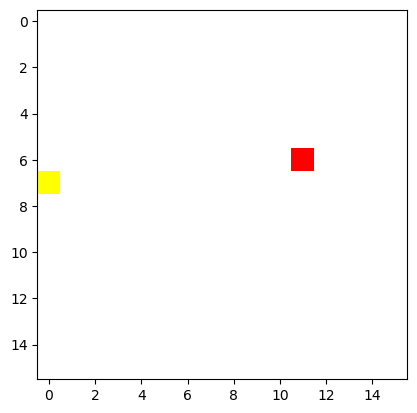

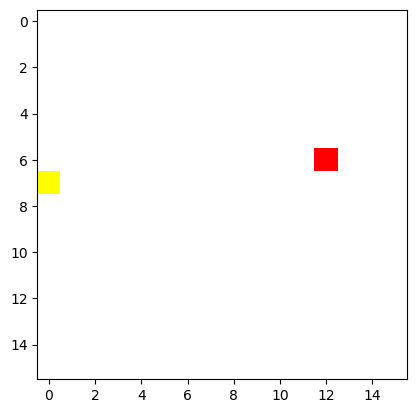

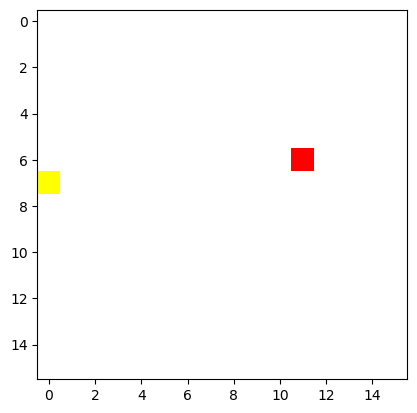

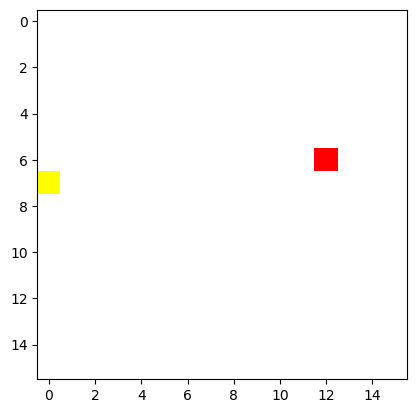

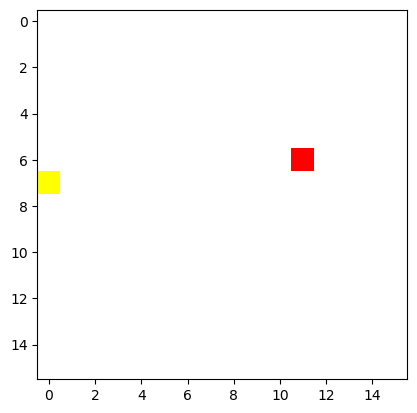

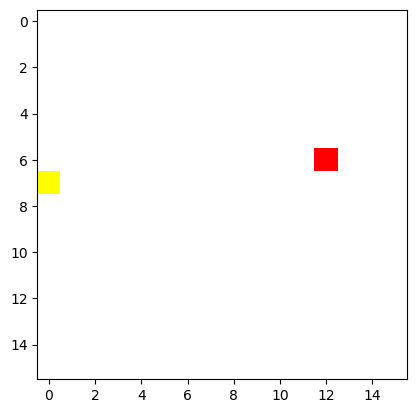

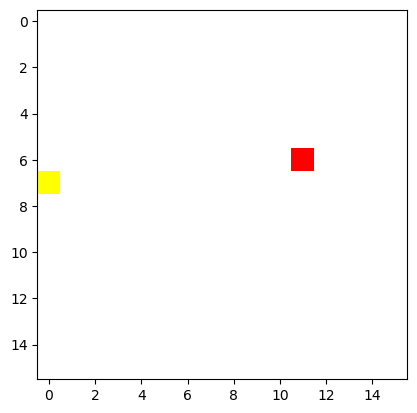

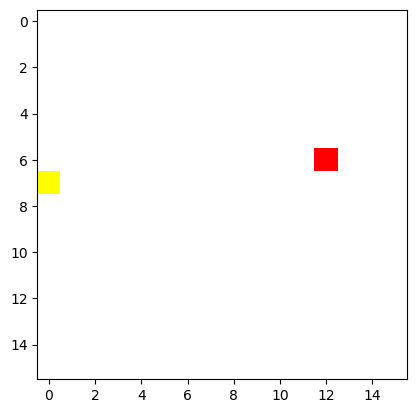

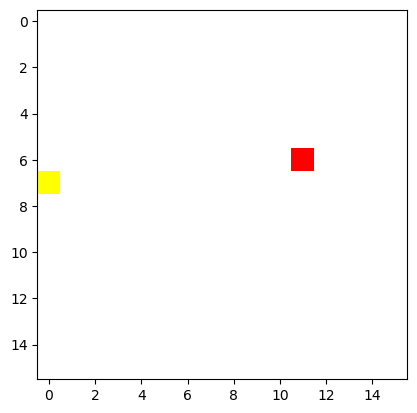

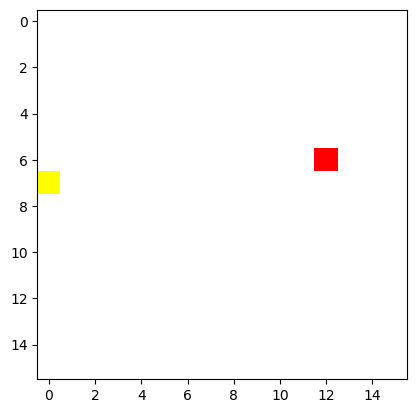

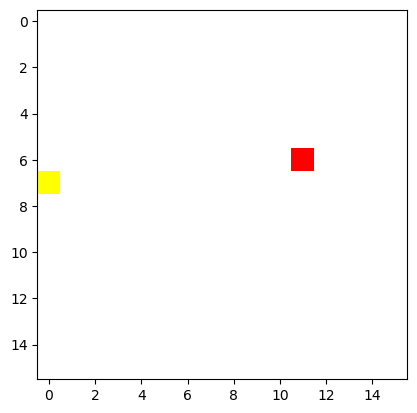

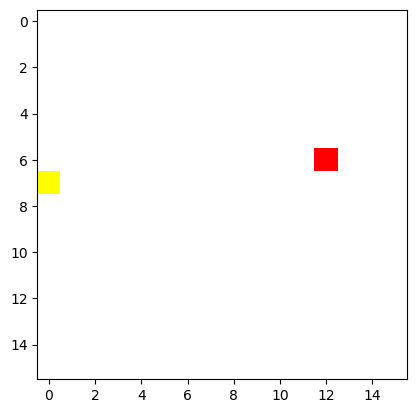

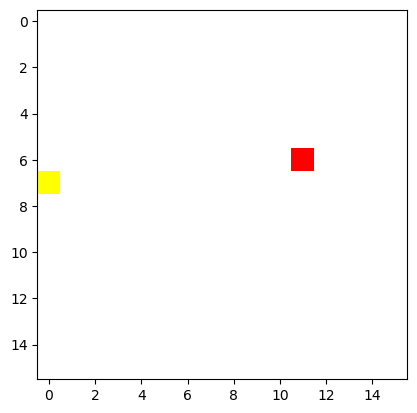

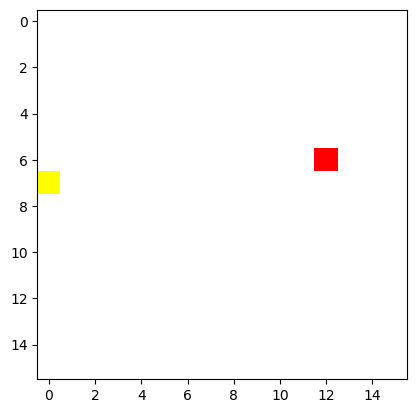

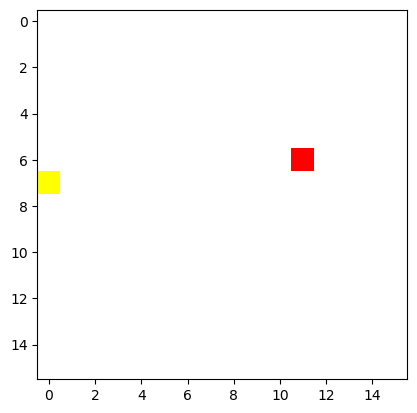

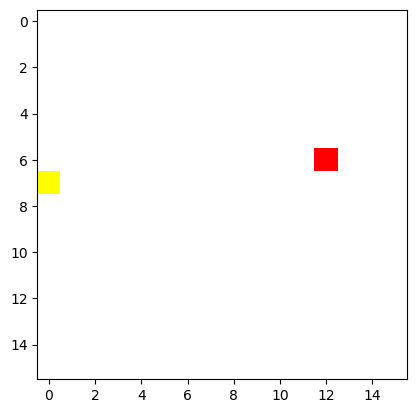

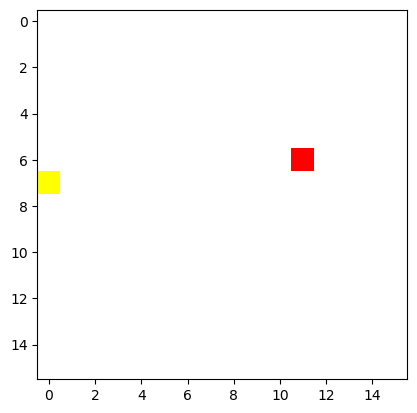

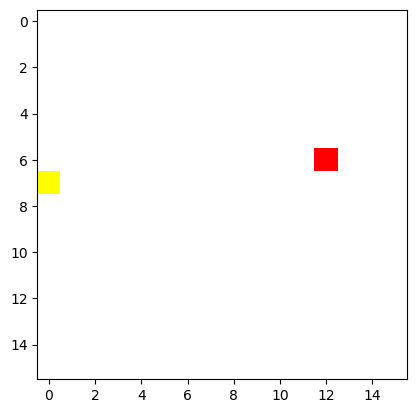

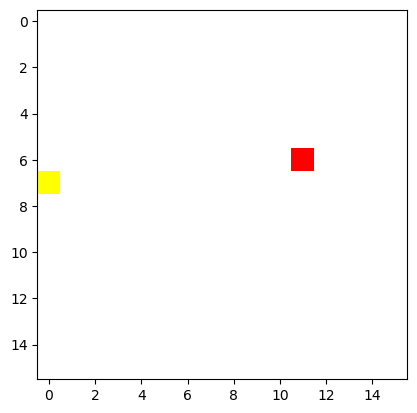

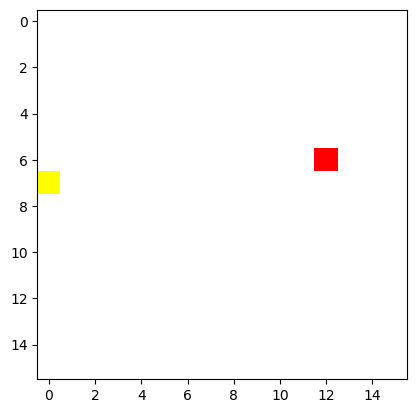

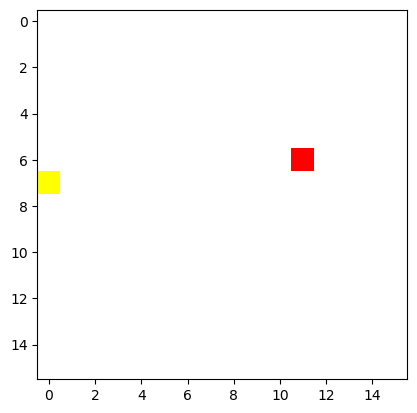

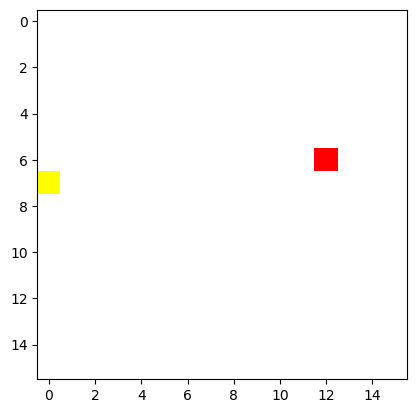

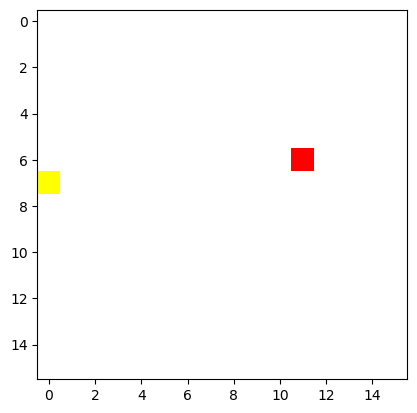

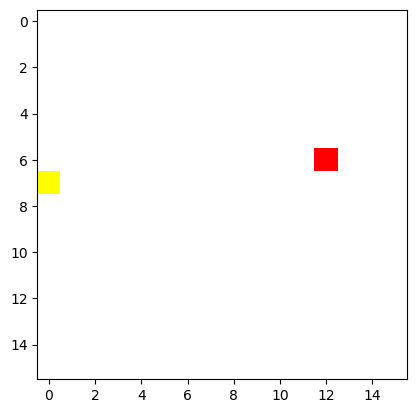

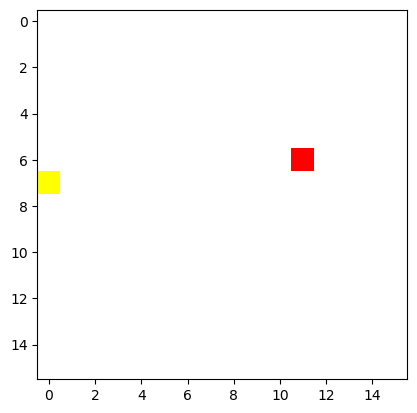

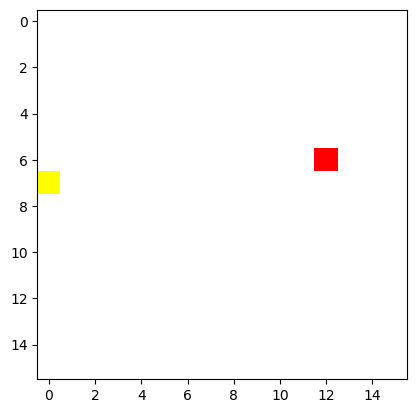

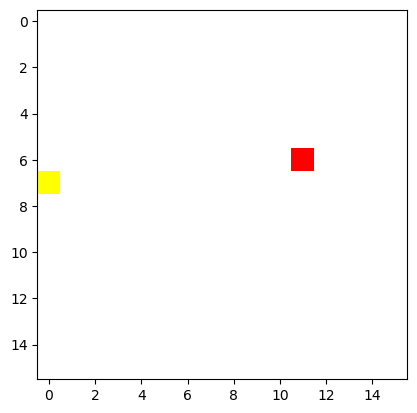

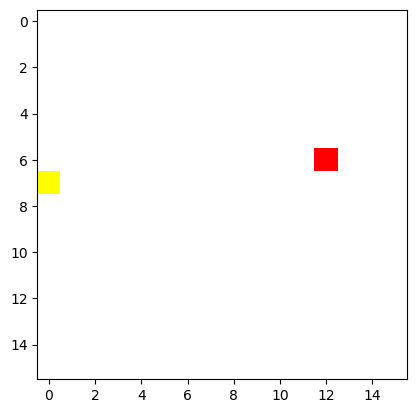

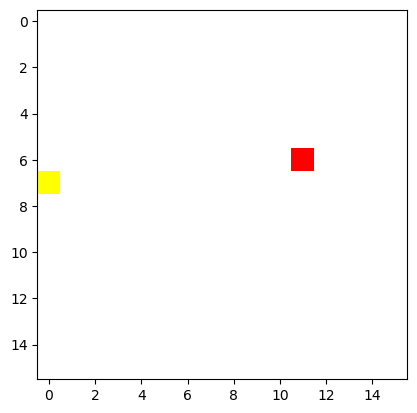

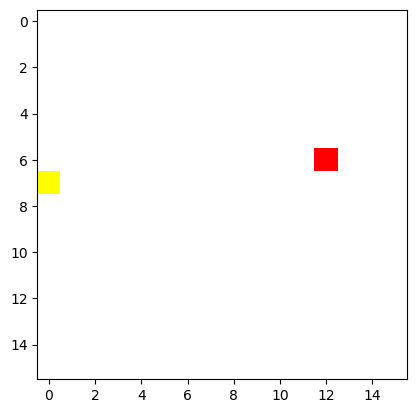

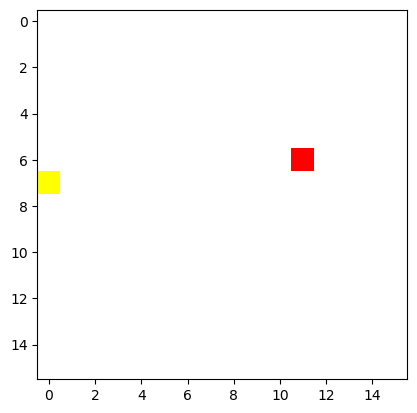

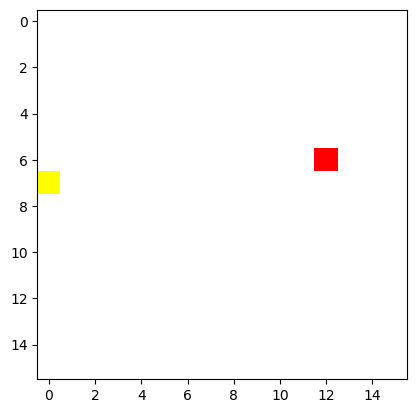

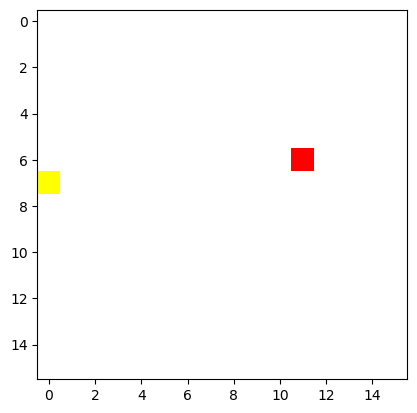

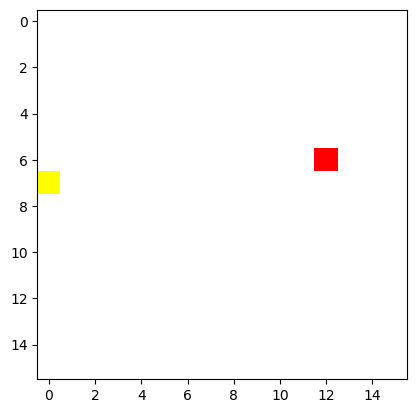

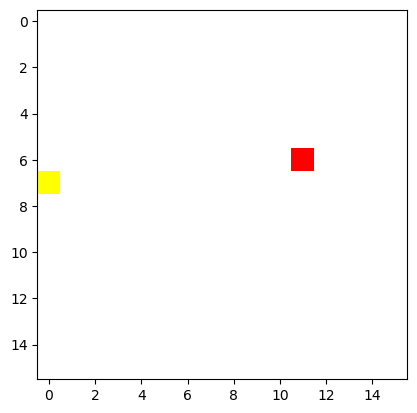

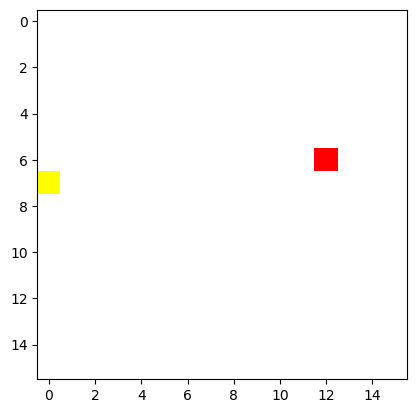

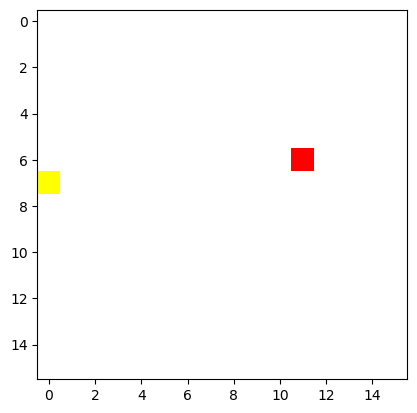

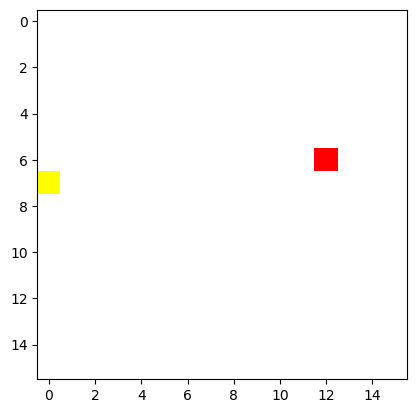

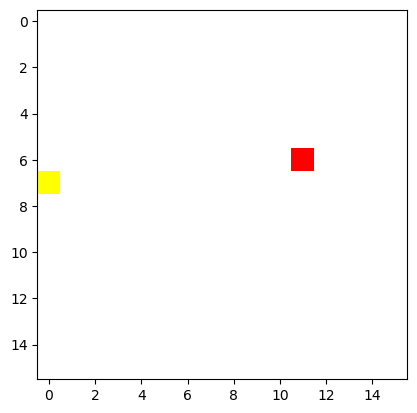

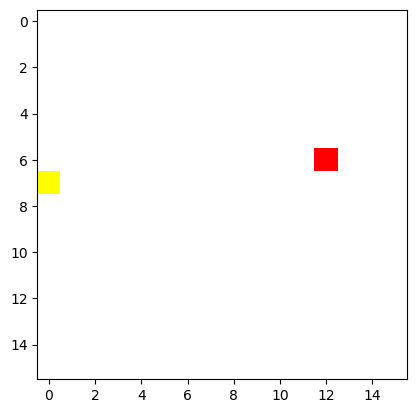

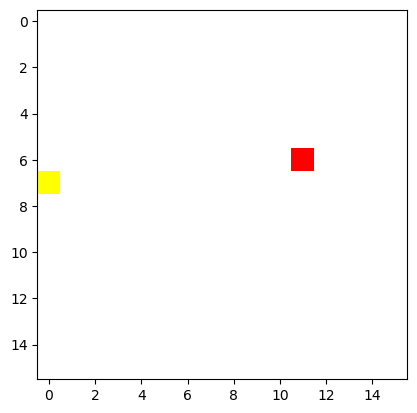

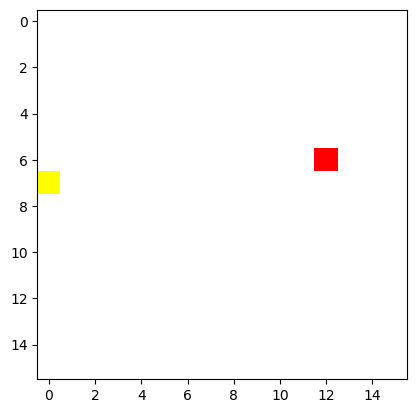

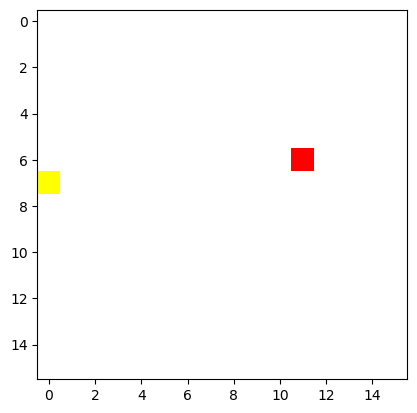

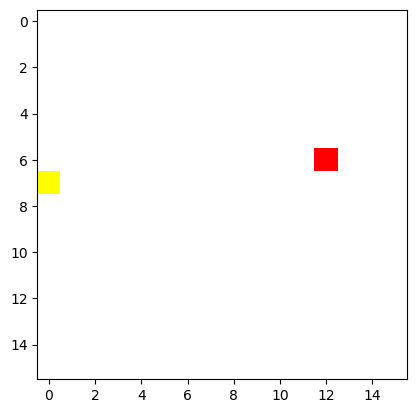

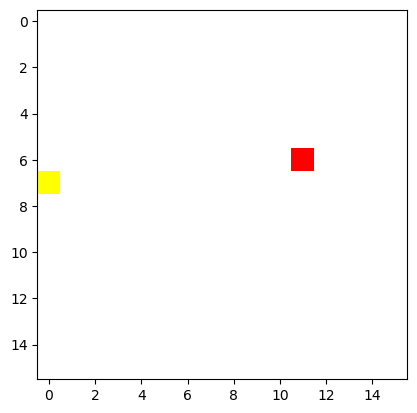

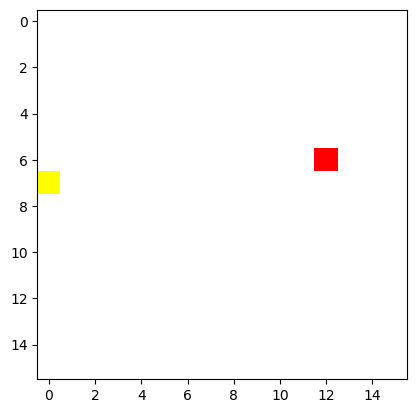

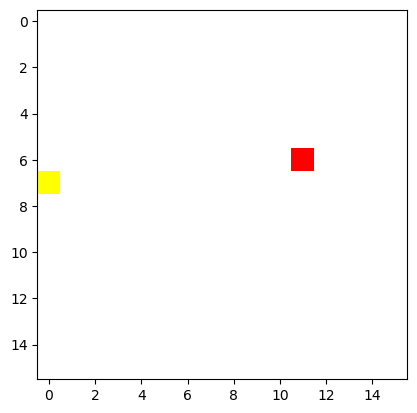

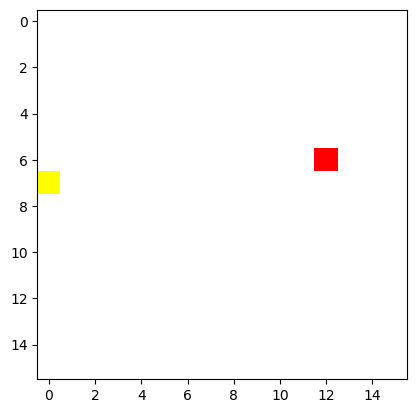

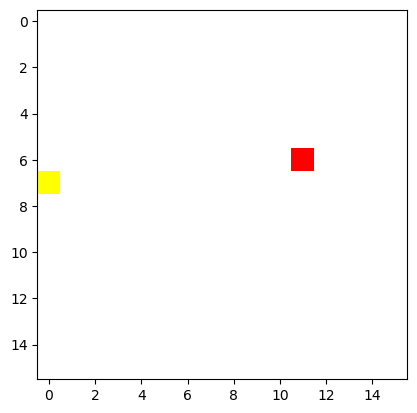

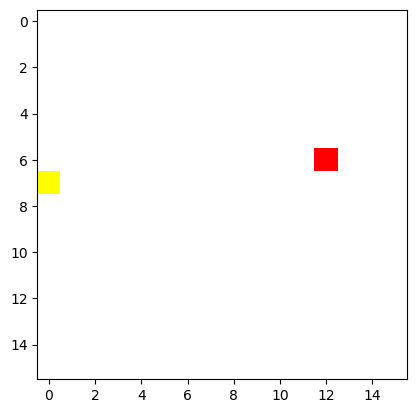

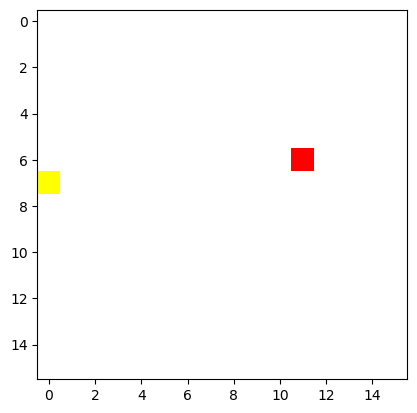

In [83]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "yellow"   # 3
])


start = get_random_point(env_size)
goal = get_random_point(env_size)
max_steps = 32

env = GridEnv(empty_grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)

images = []
plt.imshow(np.sum(obs, axis=0), cmap=cmap)
plt.show()
images.append(obs[0])

for i in range(50):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    images.append(obs[0])
    plt.imshow(obs[0], cmap=cmap)
    plt.show()
    if terminated:
        break

## fixed start, end, env

In [4]:
empty_grid = np.zeros((16, 16))
start = (0,0)
goal = (15,15)
max_steps = 1000
lr = 2.5e-4
total_timesteps=100000
ent_coef = 0.01


env = GridEnv(grid, start, goal, max_steps)

# Define and Train the agent
batch_size = 512
callback = ActionStoreCallback()
model = PPO("MlpPolicy", env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=1024, device='cpu', ent_coef= ent_coef).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

# model = PPO.load('ppo_gridworld.zip', env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=1024, device='cpu', ent_coef= ent_coef)
# model.learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

Output()

In [61]:
model.save("ppo_gridworld")

In [5]:
# start = (0,0)
# goal = (63,63)
# max_steps = 2000
# lr = 2.5e-4

# env = GridEnv(grid, start, goal, max_steps)

# model = PPO.load("ppo_gridworld", env=env, device='cpu')
# model.learn(total_timesteps=200_000, callback=callback, progress_bar=True)

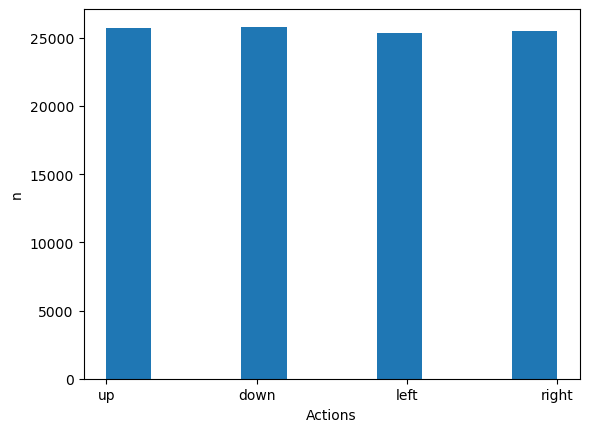

In [5]:
actions_array = np.array(callback.actions).flatten()
plt.hist(actions_array, label = 'Action Histogram')
plt.xlabel('Actions')
plt.ylabel('n')
plt.xticks([0,1,2,3], ['up', 'down', 'left', 'right'])
plt.show()

In [14]:
env.reset()[2]

array([[[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]]], dtype=uint8)

In [ ]:
n = 100
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: 'DummyVecEnv' object has no attribute 'max_steps'

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "yellow"   # 3
])

obs, info = env.reset()  # obs shape: (1, obs_dim)

images = []
plt.imshow(np.sum(obs, axis=0), cmap=cmap)
plt.show()
images.append(obs[0])

for i in range(50):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    images.append(obs[0])
    plt.imshow(obs[0], cmap=cmap)
    plt.show()
    if terminated:
        break

ValueError: too many values to unpack (expected 2)

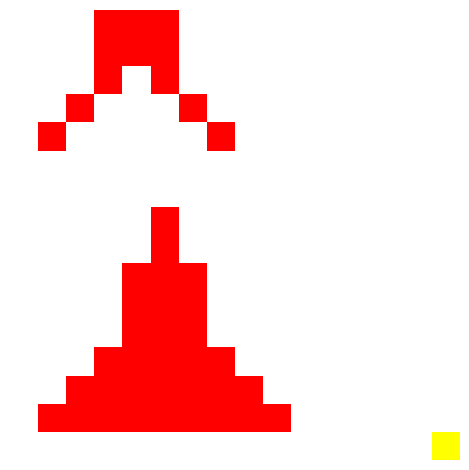

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
frames = []
for image in images:
    plt.imshow(image, cmap=cmap)
    plt.axis('off')

    plt.tight_layout()
    plt.savefig("temp.png", bbox_inches='tight', pad_inches=0)
    frames.append(Image.open("temp.png"))

# save as GIF
frames[0].save(
    "agent_animation.gif",
    save_all=True,
    append_images=frames[1:],
    duration=100,   # ms per frame
    loop=0
)

# 32x32

1.0


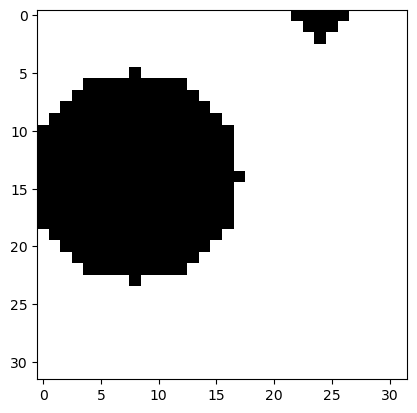

In [15]:
loaded = np.load('../environment_generation/environments/environments_32_2_10_1.npy')
loaded.shape

grid = loaded[0]
print(grid.max())
plt.imshow(grid, cmap='binary')

In [123]:
empty_grid = np.zeros((32, 32))
start = (0,0)
goal = (15,15)
max_steps = 4096
lr = 2.5e-4
total_timesteps=500000
ent_coef = 0.05
gamma = 0.99


env = GridEnv(grid, start, goal, max_steps)

# Define and Train the agent
batch_size = 512
callback = ActionStoreCallback()
model = PPO("MlpPolicy", env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps= 4096, device='cpu', ent_coef= ent_coef, gamma = gamma).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

# model = PPO.load('ppo_gridworld.zip', env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=1024, device='cpu', ent_coef= ent_coef)
# model.learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

Output()

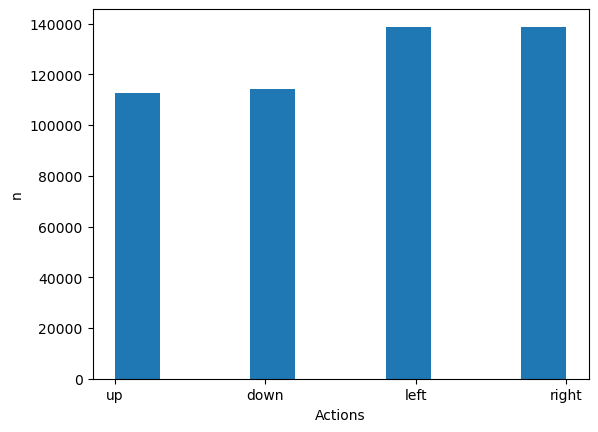

In [124]:
actions_array = np.array(callback.actions).flatten()
plt.hist(actions_array, label = 'Action Histogram')
plt.xlabel('Actions')
plt.ylabel('n')
plt.xticks([0,1,2,3], ['up', 'down', 'left', 'right'])
plt.show()

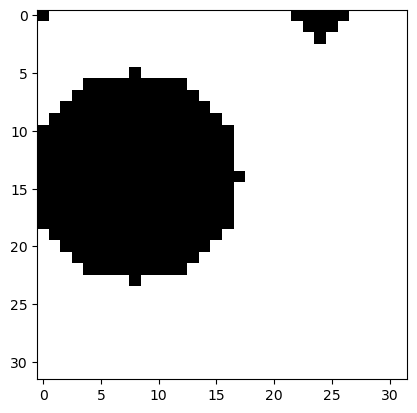

2


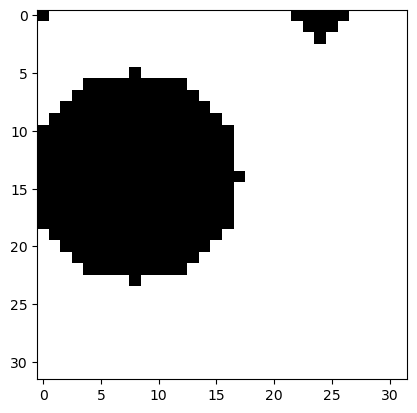

2


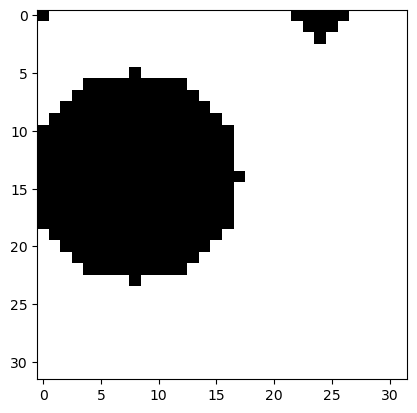

2


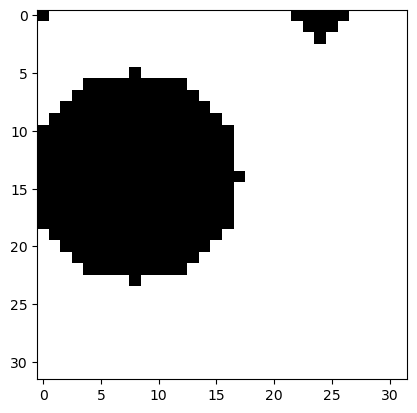

2


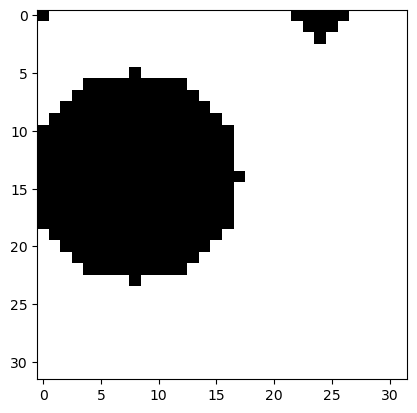

2


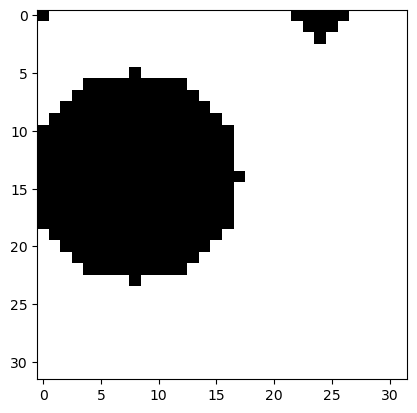

2


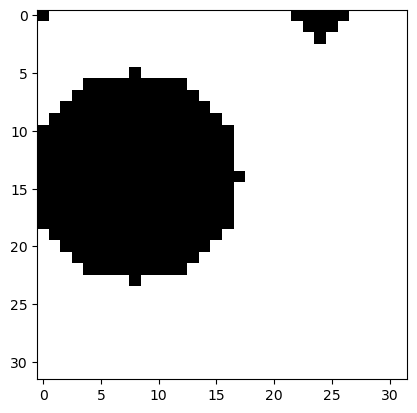

2


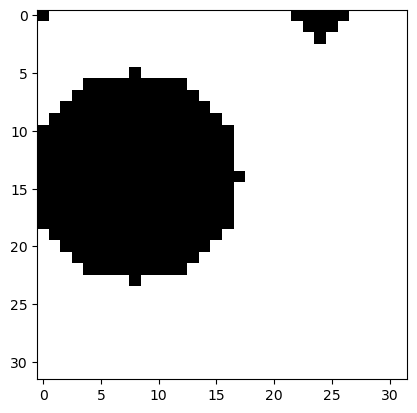

2


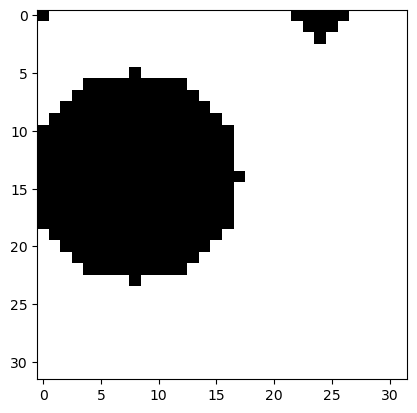

2


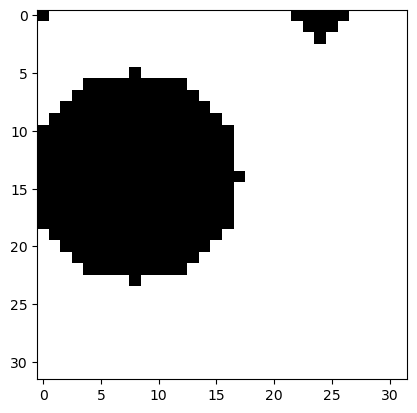

2


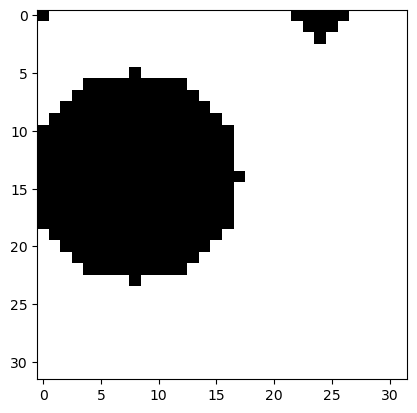

2


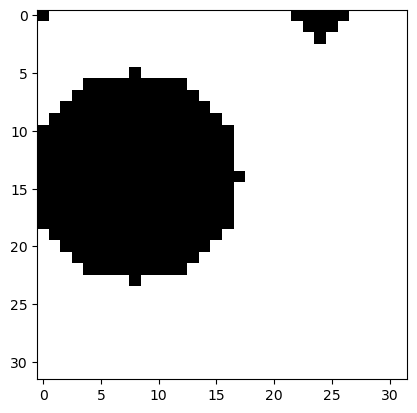

2


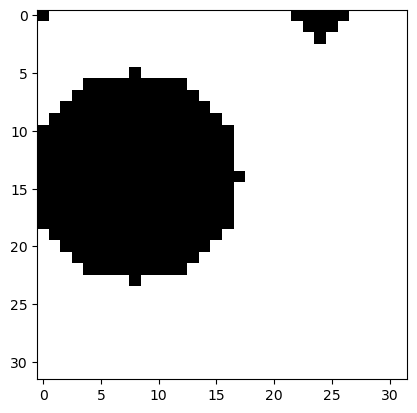

2


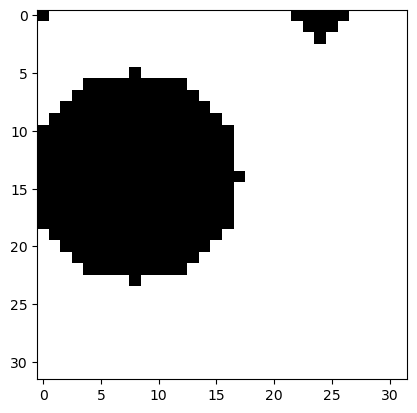

2


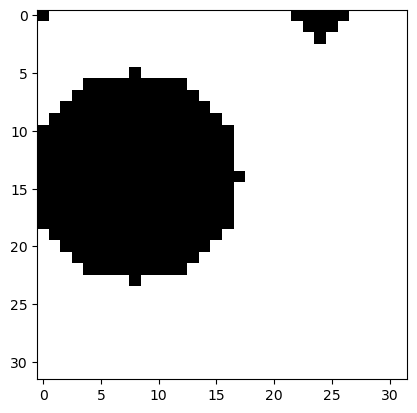

2


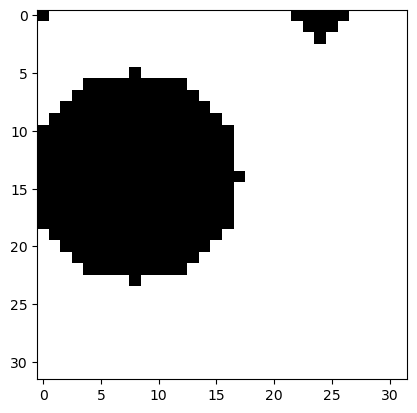

2


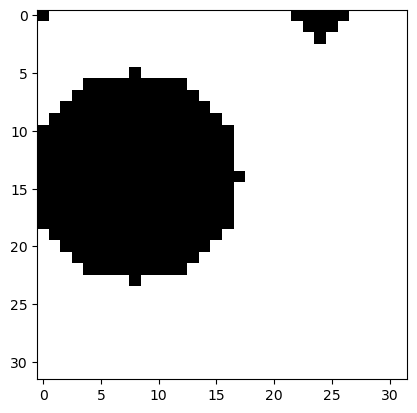

2


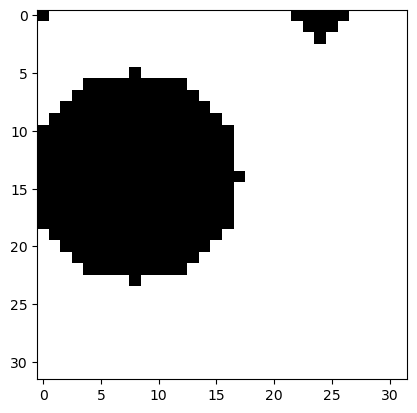

2


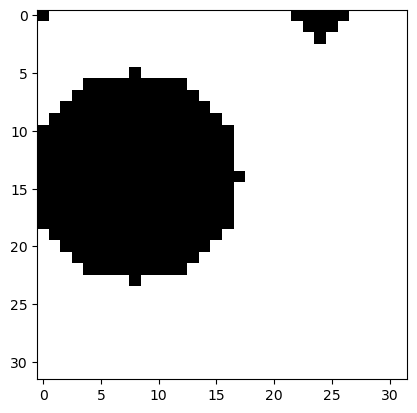

2


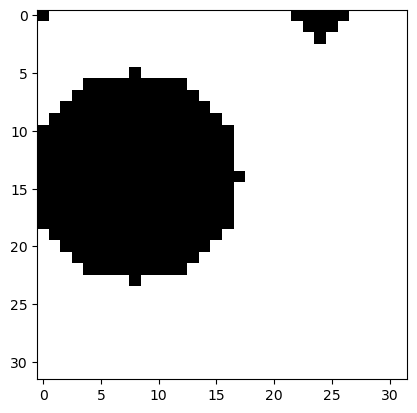

2


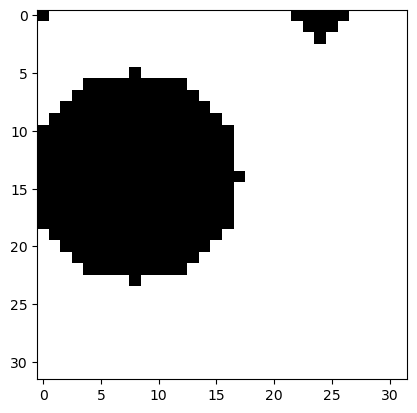

2


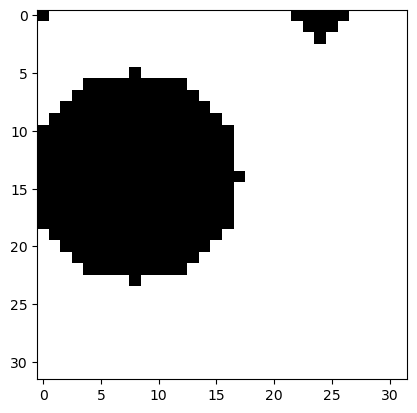

2


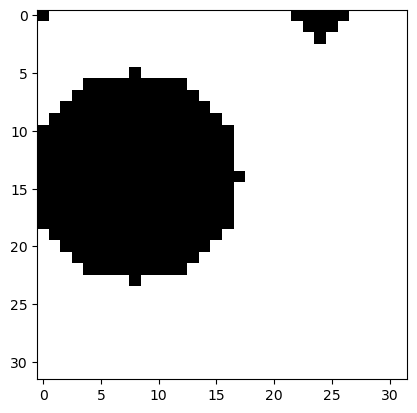

2


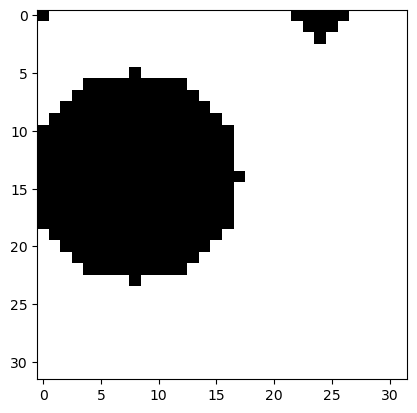

2


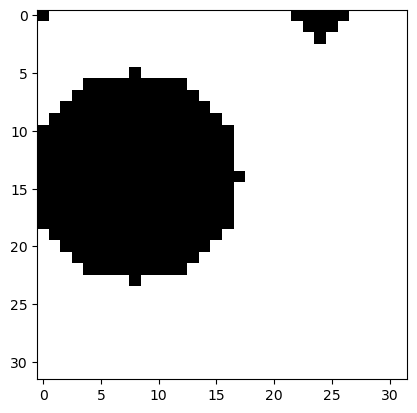

2


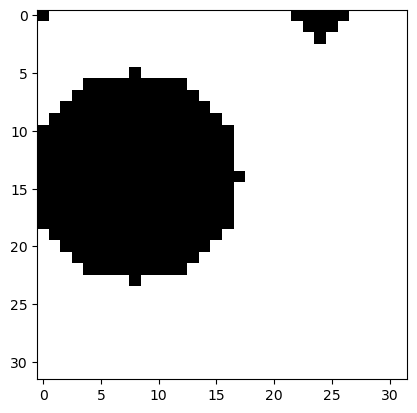

2


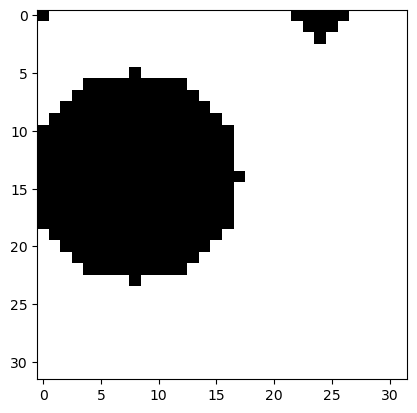

2


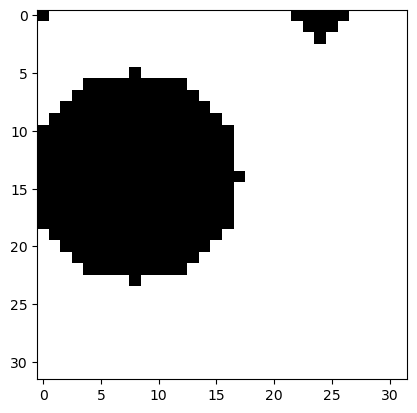

2


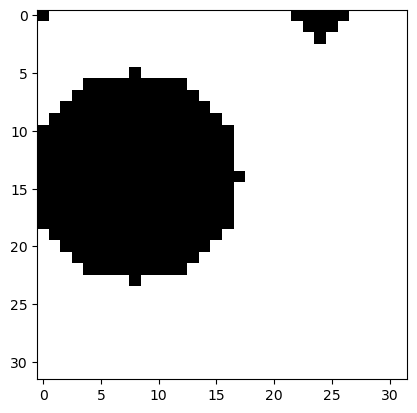

2


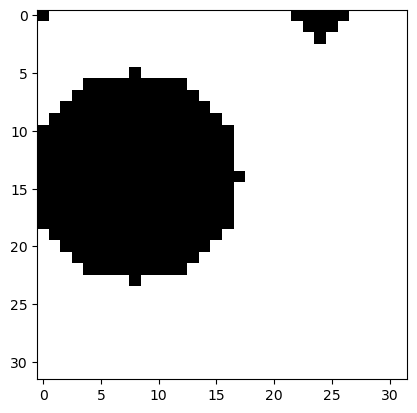

2


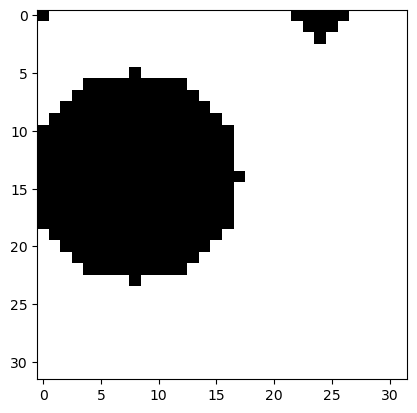

2


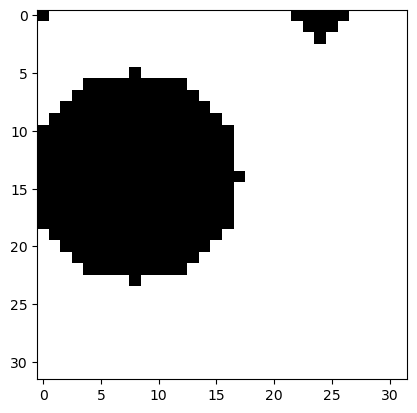

2


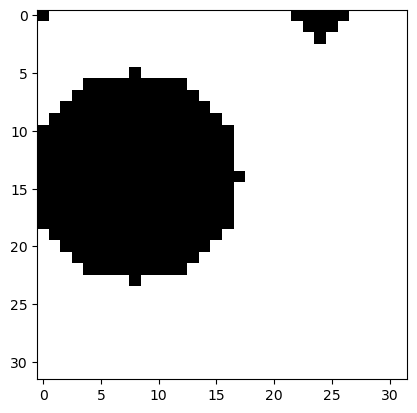

2


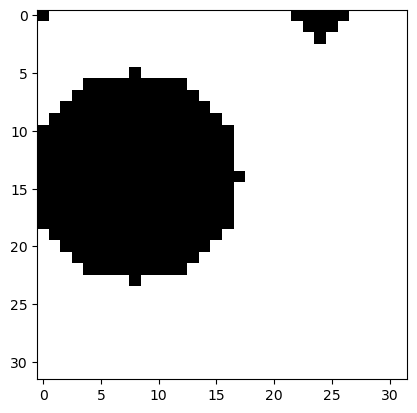

2


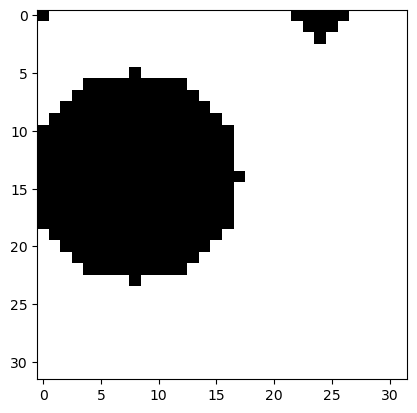

2


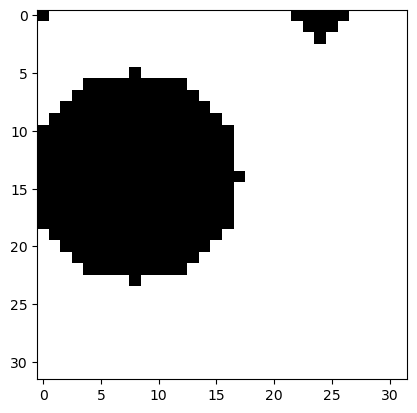

2


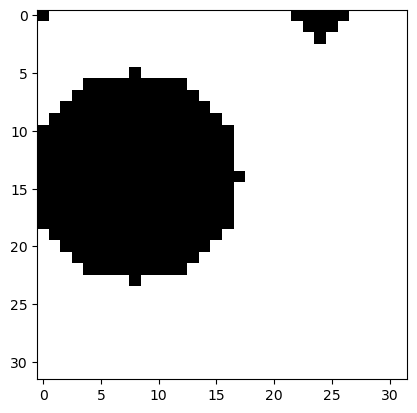

2


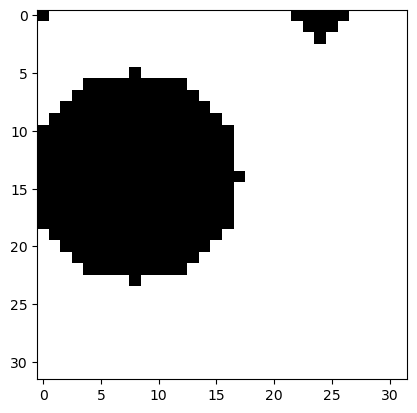

2


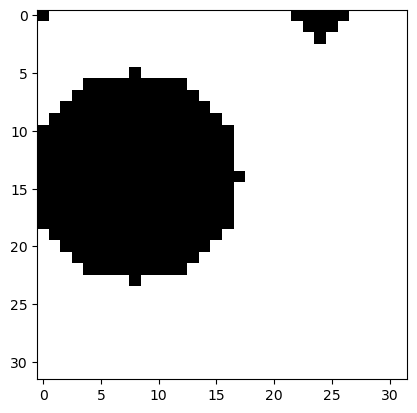

2


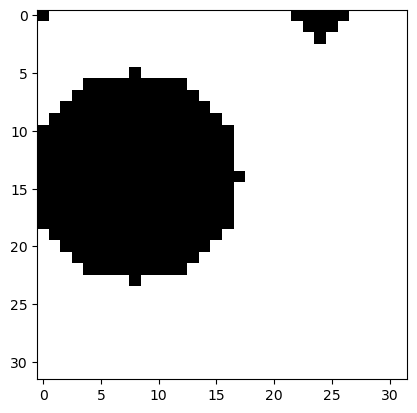

2


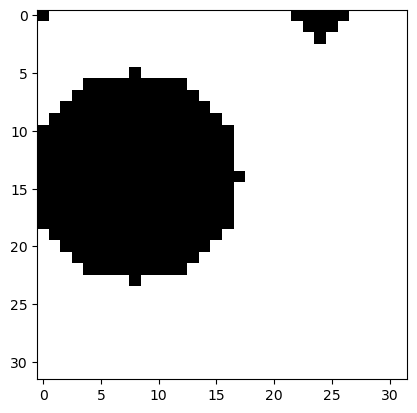

2


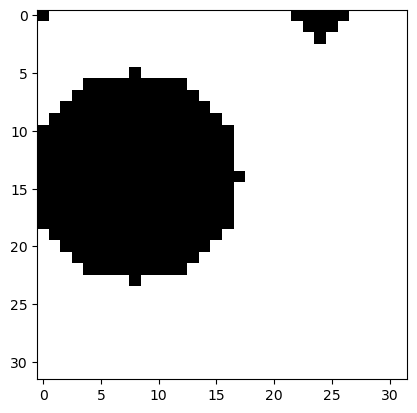

2


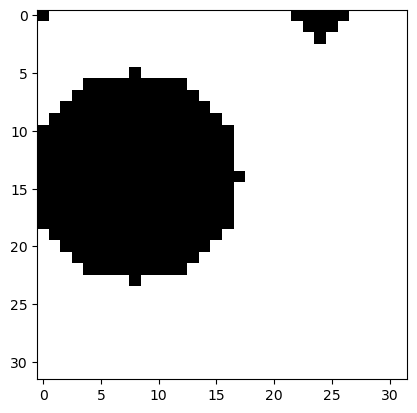

2


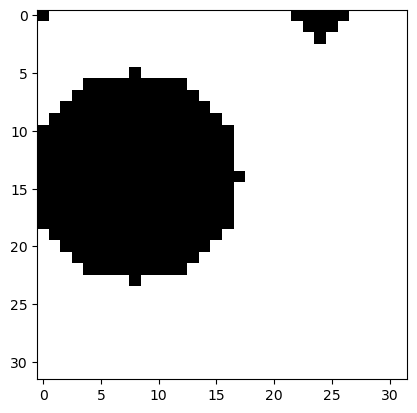

2


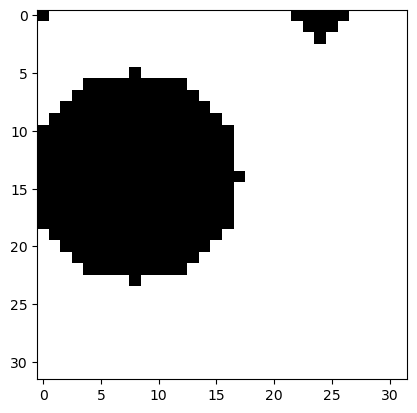

2


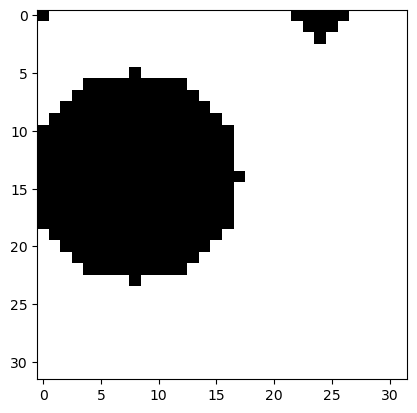

2


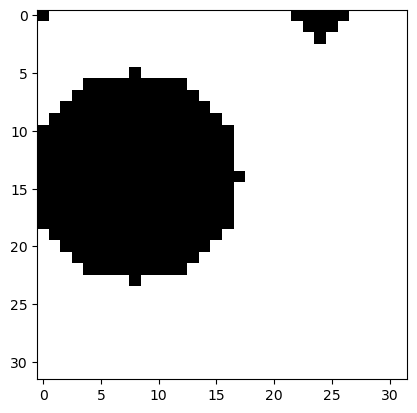

2


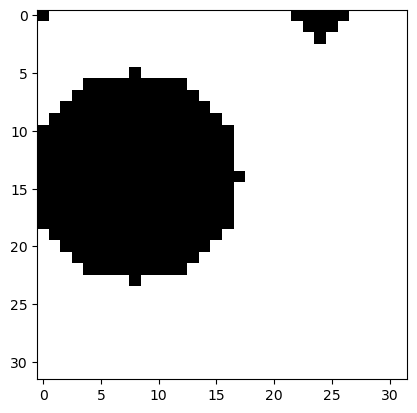

2


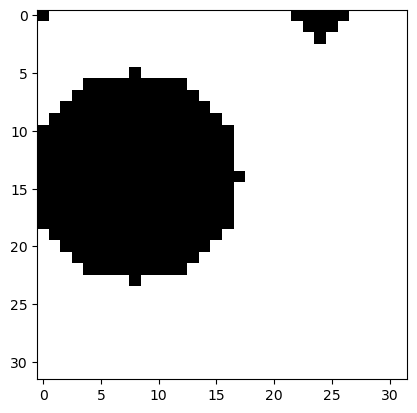

2


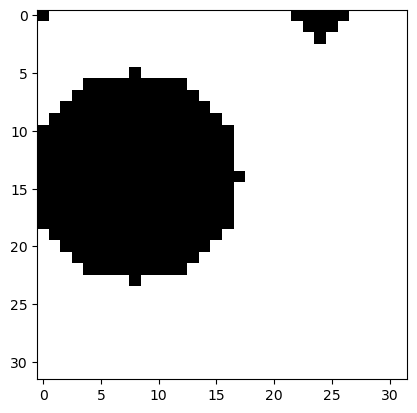

2


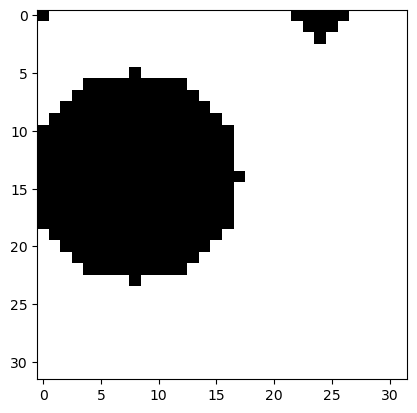

In [125]:
obs, info = env.reset()  # obs shape: (1, obs_dim)
plt.imshow(np.sum(obs, axis=0), cmap='binary')
plt.show()

for i in range(50):
    action, _ = model.predict(obs, deterministic=True)
    print(action)
        
    obs, reward, terminated, truncated, info = env.step(action)
    
    plt.imshow(np.sum(obs, axis=0), cmap='binary')
    plt.show()
    if terminated:
        break

# 64x64 MLP Policy

## random start, fixed environment, fixed goal

In [17]:
# random start point
from stable_baselines3.common.vec_env import DummyVecEnv
env_size = (64,64)
empty_grid = np.zeros(env_size)
goal = (63,63)
max_steps = 4000
lr = 2.5e-4
total_timesteps=200000
ent_coef = 0.01


def make_env():
    def _init():
        while True:
            start_x = np.random.choice(range(env_size[0]))
            start_y = np.random.choice(range(env_size[0]))
            start = (start_y, start_x)
            if start != goal:
                break
        return GridEnvMLP(empty_grid, start, goal, max_steps)
    return _init


env = DummyVecEnv([make_env() for _ in range(32)])

batch_size = 64
callback = ActionStoreCallback()
model = PPO("MlpPolicy", env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=4096, device='cpu', ent_coef= ent_coef).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

Output()

KeyboardInterrupt: 

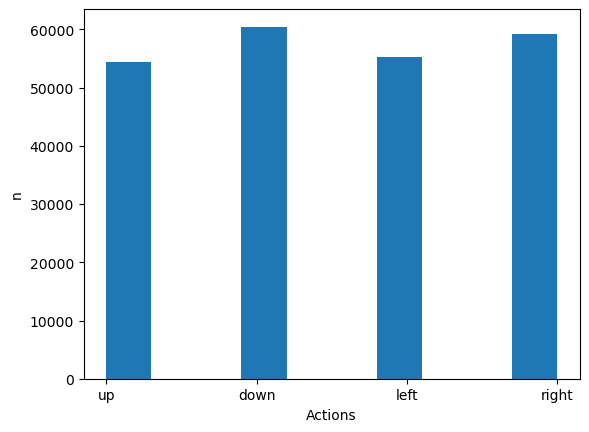

In [41]:
actions_array = np.array(callback.actions).flatten()
plt.hist(actions_array, label = 'Action Histogram')
plt.xlabel('Actions')
plt.ylabel('n')
plt.xticks([0,1,2,3], ['up', 'down', 'left', 'right'])
plt.show()

In [ ]:

max_steps = 1000

n = 100
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    start_x = np.random.choice(range(env_size[0]))
    start_y = np.random.choice(range(env_size[0]))
    start = (start_y, start_x)

    env = GridEnvMLP(empty_grid, start, goal, max_steps)
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "green"   # 3
])


start_x = np.random.choice(range(env_size[0]))
start_y = np.random.choice(range(env_size[0]))
start = (start_y, start_x)

max_steps = 1000
goal = (63, 63)

env = GridEnvMLP(empty_grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)

images = []
plt.imshow(np.sum(obs, axis=0), cmap=cmap)
plt.show()
images.append(obs[0])

for i in range(50):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    images.append(obs[0])
    plt.imshow(obs[0], cmap=cmap)
    plt.show()
    if terminated:
        break

# 64x64 CNN Policy with custom feature extraction

In [39]:
def make_env(grids, goal, max_steps, env_size):
    def _init():
        while True:
            while True: 
                start_x = np.random.choice(range(env_size[0]))
                start_y = np.random.choice(range(env_size[0]))
                start = (start_y, start_x)
                if start != goal: 
                    break
            
            if isinstance(grids, list):
                grid = grids[np.random.choice(range(len(grids)))]
                env = GridEnvCNN(grid, start, goal, max_steps)
            else:
                grid = grids
                env = GridEnvCNN(grid, start, goal, max_steps)
            if grid[start] == 0 and grid[goal] == 0:
                return env
    return _init

In [ ]:
n_steps           = 2048
batch_size        = 256      
n_epochs          = 4        
learning_rate     = 3e-4     
ent_coef          = 0.001    
clip_range        = 0.2
gamma             = 0.995 
gae_lambda        = 0.95
max_grad_norm     = 0.5
normalize_advantage = True

num_envs          = 16
max_steps         = 256

total_timesteps   = 1500000

env_size = (64,64)
empty_grid = np.zeros(env_size)




env = DummyVecEnv([make_env(empty_grid) for _ in range(num_envs)])
env = VecMonitor(env, filename=None)

callback = ActionStoreCallback()
model = PPO(CustomCNNPolicy, env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=learning_rate, batch_size=batch_size, n_steps=n_steps, device='cpu', ent_coef= ent_coef, n_epochs = n_epochs, gamma=gamma).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,507,328/1,500,000  [ 0:18:56 < 0:00:00 , 1,637 it/s ]

In [ ]:
model.save("ppo_custom_cnn_64x64_empty_random_start")

1.0


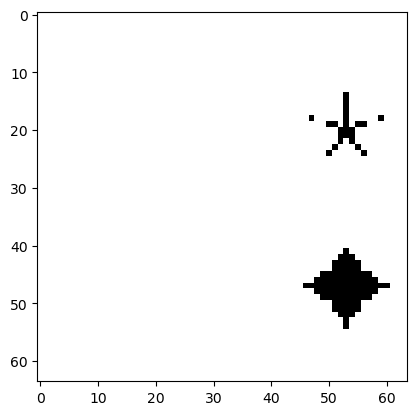

In [4]:
loaded = np.load('../environment_generation/environments/environments_64_2_10_1.npy')
loaded.shape

grid = loaded[6]
print(grid.max())
plt.imshow(grid, cmap='binary')

In [ ]:



env = DummyVecEnv([make_env(grid) for _ in range(32)])
env = VecMonitor(env, filename=None)

model = PPO.load("ppo_custom_cnn_64x64_empty_random_start", env=env, device='cpu')
model.learn(total_timesteps=200_000, callback=callback, progress_bar=True)

Output()

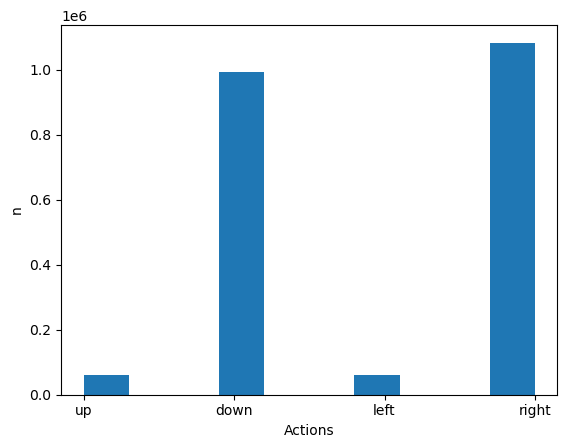

In [54]:
plot_action_histogram(callback)

In [132]:
model = PPO.load("ppo_custom_cnn_64x64_empty_random_start", env=env, device='cpu')

In [133]:

max_steps = 1000

n = 1000
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    start_x = np.random.choice(range(env_size[0]))
    start_y = np.random.choice(range(env_size[0]))
    start = (start_y, start_x)

    env = GridEnvCNN(empty_grid, start, goal, max_steps)
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

100%|██████████| 1000/1000 [00:50<00:00, 19.65it/s]

terminated:  100.0 %


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "green"   # 3
])


start_x = np.random.choice(range(env_size[0]))
start_y = np.random.choice(range(env_size[0]))
start = (start_y, start_x)

max_steps = 1000
goal = (63, 63)

env = GridEnvCNN(grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)


images = []
plt.imshow(np.sum(obs['image'], axis=0), cmap=cmap)
plt.show()


for i in range(100):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    
    plt.imshow(np.sum(obs['image'], axis=0), cmap=cmap)
    plt.show()
    if terminated:
        break

# random start, fixed goal, random environment

(1000, 64, 64)
1.0


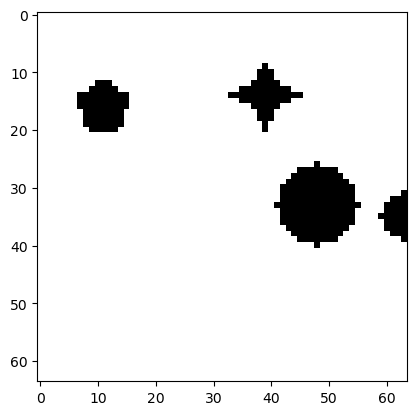

In [3]:
loaded = np.load('../environment_generation/environments/environments_64_4_1000_1.npy')
print(loaded.shape)

grid = loaded[9]
print(grid.max())
plt.imshow(grid, cmap='binary')

In [4]:
grid_list = []
for i in loaded:
    grid_list.append(i)

In [5]:
def make_env(grids, goal, max_steps, env_size):
    def _init():
        while True:
            while True: 
                start_x = np.random.choice(range(env_size[0]))
                start_y = np.random.choice(range(env_size[0]))
                start = (start_y, start_x)
                if start != goal: 
                    break
            
            if isinstance(grids, list):
                grid = grids[np.random.choice(range(len(grids)))]
                env = GridEnvCNN(grid, start, goal, max_steps)
            else:
                grid = grids
                env = GridEnvCNN(grid, start, goal, max_steps)

            if grid[start] == 0 and grid[goal] == 0:
                return env
    return _init

(np.int64(15), np.int64(59)) (63, 63)
0.0 0.0


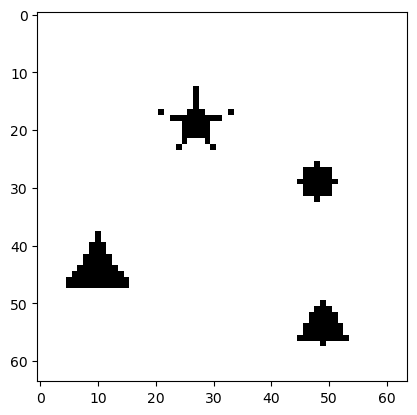

In [7]:
def make_environment(grids, goal, max_steps, env_size):

    while True:
        while True: 
            start_x = np.random.choice(range(env_size[0]))
            start_y = np.random.choice(range(env_size[0]))
            start = (start_y, start_x)
            if start != goal: 
                break
        
        if isinstance(grids, list):
            grid = grids[np.random.choice(range(len(grids)))]
            env = GridEnvCNN(grid, start, goal, max_steps)
        else:
            grid = grids
            env = GridEnvCNN(grid, start, goal, max_steps)
        print(start, goal)
        print(grid[start], grid[goal])
        plt.imshow(grid, cmap='binary')
        plt.show()

        if grid[start] == 0 and grid[goal] == 0:
            return env



make_environment(grid_list, (63, 63), 256, (64,64))

In [6]:
env_size = (64,64)
goal = (63,63)
max_steps = 512
callback = ActionStoreCallback()
env = DummyVecEnv([make_env(grid_list, goal, max_steps, env_size) for _ in range(64)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_empty_random_start", env=env, device='cpu')
model.learn(total_timesteps=2_000_000, callback=callback, progress_bar=True)

Output()

KeyboardInterrupt: 

In [17]:
model.save("ppo_custom_cnn_64x64_random_env_random_start")

In [19]:
env = DummyVecEnv([make_env(grid_list, (63,63), 512, (64,64)) for _ in range(32)])
env = VecMonitor(env, filename=None)

model = PPO.load("ppo_custom_cnn_64x64_random_env_random_start", env=env, device='cpu')
model.learn(total_timesteps=500_000, callback=callback, progress_bar=True)

Output()

In [27]:
model.save("ppo_custom_cnn_64x64_random_env_random_start1")

In [28]:
env = DummyVecEnv([make_env(grid_list, (63,63), 512, (64,64)) for _ in range(32)])
env = VecMonitor(env, filename=None)

model = PPO.load("ppo_custom_cnn_64x64_random_env_random_start1", env=env, device='cpu')
model.learn(total_timesteps=1_000_000, callback=callback, progress_bar=True)

Output()

In [15]:

max_steps = 1000

n = 1000
terminated_count = 0
truncated_count = 0
terminated_step_count = 0
for i in tqdm(range(n)):
    grid = grid_list[np.random.choice(range(len(grid_list)))]
    while True:
        start_x = np.random.choice(range(env_size[0]))
        start_y = np.random.choice(range(env_size[0]))
        start = (start_y, start_x)
        if grid[start] == 0:
            break

    
    env = GridEnvCNN(grid, start, goal, max_steps)
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
                terminated_step_count += step
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, f'% with an average of {terminated_step_count/terminated_count} steps')

100%|██████████| 1000/1000 [00:43<00:00, 22.96it/s]

terminated:  36.3 % with an average of 58.20661157024794 steps


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "green"   # 3
])


start_x = np.random.choice(range(env_size[0]))
start_y = np.random.choice(range(env_size[0]))
start = (start_y, start_x)

max_steps = 1000
goal = (63, 63)

grid = grid_list[np.random.choice(range(len(grid_list)))]
env = GridEnvCNN(grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)


images = []
plt.imshow(np.sum(obs['image'] * np.array([1,3,2]).reshape(3, 1, 1), axis=0), cmap=cmap)
plt.show()


for i in range(100):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    
    plt.imshow(np.sum(obs['image'] * np.array([1,3,2]).reshape(3, 1, 1), axis=0), cmap=cmap)
    plt.show()
    if terminated or truncated:
        break

# curriculum learning

In [ ]:
def make_env(grids, goal = None, max_steps = 256, env_size = (64,64), goal_region = (64,64)):
    def _init():
        while True:
            while True: 
                start_x = np.random.choice(range(env_size[0]))
                start_y = np.random.choice(range(env_size[0]))
                start = (start_y, start_x)
                if start != goal: 
                    break
            if goal is None:
                while True: 
                    goal_x = np.random.choice(range(goal_region[0]))
                    goal_y = np.random.choice(range(goal_region[0]))
                    local_goal = (goal_y, goal_x)
                    if start != goal:
                        break
            else: local_goal = goal

            if isinstance(grids, list):
                grid = grids[np.random.choice(range(len(grids)))]
                env = GridEnvCNN(grid, start, local_goal, max_steps)

            else:
                grid = grids
                env = GridEnvCNN(grid, start, local_goal, max_steps)

            if grid[start] == 0 and grid[local_goal] == 0:
                return env
    return _init

In [5]:

class RolloutMeanRewardStop(BaseCallback):
    def __init__(self, threshold, verbose=0):
        super().__init__(verbose)
        self.threshold = threshold
        self.episode_rewards = []
        self.stop_training = False

    def _on_step(self):
        # Stop here if triggered during rollout end
        if self.stop_training:
            return False

        # Collect episode rewards
        infos = self.locals.get("infos")
        if infos is not None:
            for info in infos:
                if "episode" in info:
                    self.episode_rewards.append(info["episode"]["r"])

        return True

    def _on_rollout_end(self):
        if len(self.episode_rewards) > 0:
            ep_rew_mean = np.mean(self.episode_rewards)

            if self.verbose:
                print(f"rollout/ep_rew_mean = {ep_rew_mean:.2f}")

            if ep_rew_mean >= self.threshold:
                print(
                    f"Stopping PPO because rollout/ep_rew_mean = "
                    f"{ep_rew_mean:.2f} >= {self.threshold}"
                )
                self.stop_training = True

            # Reset for next rollout
            self.episode_rewards = []

## Level 1

In [3]:
threshold = 9.7

In [ ]:
n_steps           = 256
batch_size        = 512     
n_epochs          = 2       
learning_rate     = 3e-4     
ent_coef          = 0.001    
clip_range        = 0.2
gamma             = 0.995 
gae_lambda        = 0.95
max_grad_norm     = 0.5
normalize_advantage = True

num_envs          = 512
max_steps         = 256

total_timesteps   = 2000000

env_size = (64,64)
# empty_grid = np.zeros(env_size)

# environments_6 = np.load('../environment_generation/environments/environments_64_6_1000_1.npy')
# grid_list_6 = [grid for grid in environments_6]
# environments_9 = np.load('../environment_generation/environments/environments_64_9_1000_1.npy')
# grid_list_9 = [grid for grid in environments_9]

# grid_list = [*grid_list_6, *grid_list_9]

environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]


env = DummyVecEnv([make_env(grid_list, (0,0)) for _ in range(num_envs)])
env = VecMonitor(env, filename=None)

callback = RolloutMeanRewardStop(threshold=threshold)
model = PPO(CustomCNNPolicy, env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=learning_rate, batch_size=batch_size, n_steps=n_steps, device='cuda', ent_coef= ent_coef, n_epochs = n_epochs, gamma=gamma).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True, tb_log_name="Level 1")

256


Output()

In [7]:
model.save("models/ppo_custom_cnn_64x64_lvl_1")

In [21]:
env_size = (64,64)
empty_grid = np.zeros(env_size)
env = DummyVecEnv([make_env(empty_grid, (0,0)) for _ in range(64)])
env = VecMonitor(env, filename=None)
model = PPO.load("models/ppo_custom_cnn_64x64_lvl_1", env=env, device='cuda')
empty_grid = np.zeros(env_size)
test_agent(model, empty_grid, goal = (0,0))

1280


100%|██████████| 100/100 [00:11<00:00,  8.83it/s]

terminated:  100.0 % with an average of 57.85 steps and a maximum of 109


## Level 2

### Level 2.1

In [8]:
env_size = (64,64)
goal_region = (3,3)

callback = RolloutMeanRewardStop(threshold)
# empty_grid = np.zeros(env_size)

environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]

env = DummyVecEnv([make_env(grid_list, goal_region = goal_region) for _ in range(512)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_1", env=env, device='cuda')
model.learn(total_timesteps=2_000_000, callback=callback, progress_bar=True, tb_log_name="Level 2.1")

256


Output()

In [9]:
model.save("models/ppo_custom_cnn_64x64_lvl_2.1")

In [5]:
model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.1", env=env, device='cpu')
empty_grid = np.zeros(env_size)
test_agent(model, empty_grid, goal_region= (3,3), n=100)

NameError: name 'env' is not defined

### Level 2.2

In [6]:
env_size = (64,64)
goal_region = (5,5)
callback = RolloutMeanRewardStop(threshold)
# empty_grid = np.zeros(env_size)

environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]

env = DummyVecEnv([make_env(grid_list, goal_region = goal_region) for _ in range(512)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.1", env=env, device='cuda')
model.learn(total_timesteps=2_000_000, callback=callback, progress_bar=True, tb_log_name="Level 2.2")

256


Output()

In [7]:
model.save("models/ppo_custom_cnn_64x64_lvl_2.2")

In [12]:
model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.2", env=env, device='cuda')
empty_grid = np.zeros(env_size)
test_agent(model, empty_grid, goal_region= (5,5), n=100)

1280


100%|██████████| 100/100 [00:17<00:00,  5.70it/s]

terminated:  89.0 % with an average of 60.146067415730336 steps and a maximum of 113


### Level 2.3

In [8]:
env_size = (64,64)
goal_region = (10,10)
callback = RolloutMeanRewardStop(threshold)
# empty_grid = np.zeros(env_size)

environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]

env = DummyVecEnv([make_env(grid_list, goal_region = goal_region) for _ in range(512)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.2", env=env, device='cuda')
model.learn(total_timesteps=2_000_000, callback=callback, progress_bar=True, tb_log_name="Level 2.3")

Output()

256


In [9]:
model.save("models/ppo_custom_cnn_64x64_lvl_2.3")

In [15]:
model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.3", env=env, device='cuda')
empty_grid = np.zeros(env_size)
test_agent(model, empty_grid, goal_region= (10,10), n=100)

1280


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]

terminated:  77.0 % with an average of 57.1948051948052 steps and a maximum of 109


### Level 2.4

In [10]:
env_size = (64,64)
goal_region = (20,20)
callback = RolloutMeanRewardStop(threshold)
# empty_grid = np.zeros(env_size)

environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]

env = DummyVecEnv([make_env(grid_list, goal_region = goal_region) for _ in range(512)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.3", env=env, device='cuda')
model.learn(total_timesteps=2_000_000, callback=callback, progress_bar=True, tb_log_name="Level 2.4")

Output()

256


In [11]:
model.save("models/ppo_custom_cnn_64x64_lvl_2.4")

In [18]:
model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.4", env=env, device='cuda')
empty_grid = np.zeros(env_size)
test_agent(model, empty_grid, goal_region= (20,20), n=100)

1280


100%|██████████| 100/100 [01:41<00:00,  1.02s/it]

terminated:  56.00000000000001 % with an average of 45.267857142857146 steps and a maximum of 106


### Level 2.5

In [12]:
env_size = (64,64)
goal_region = (30,30)

callback = RolloutMeanRewardStop(threshold)
# empty_grid = np.zeros(env_size)

environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]

env = DummyVecEnv([make_env(grid_list, goal_region=goal_region) for _ in range(512)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.4", env=env, device='cuda')
model.learn(total_timesteps=2_000_000, callback=callback, progress_bar=True, tb_log_name="Level 2.5")

Output()

256


In [13]:
model.save("models/ppo_custom_cnn_64x64_lvl_2.5")

In [21]:
model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.5", env=env, device='cuda')
empty_grid = np.zeros(env_size)
test_agent(model, empty_grid, goal_region= (30,30), n=100)

1280


100%|██████████| 100/100 [01:47<00:00,  1.07s/it]

terminated:  54.0 % with an average of 42.7037037037037 steps and a maximum of 87


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "green"   # 3
])


start_x = np.random.choice(range(env_size[0]))
start_y = np.random.choice(range(env_size[0]))
start = (start_y, start_x)

max_steps = 1000
goal_x = np.random.choice(range(env_size[0]))
goal_y = np.random.choice(range(env_size[0]))
goal = (goal_y, goal_x)

start = (0,63)
goal = (63,0)

empty_grid = np.zeros(env_size)
env = GridEnvCNN(empty_grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)


images = []
plt.imshow(np.sum(obs['image'] * np.array([1,3,2]).reshape(3, 1, 1), axis=0), cmap=cmap)
plt.show()


for i in range(200):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    
    plt.imshow(np.sum(obs['image'] * np.array([1,3,2]).reshape(3, 1, 1), axis=0), cmap=cmap)
    plt.show()
    if terminated or truncated:
        break

### Level 2.6

In [14]:
env_size = (64,64)
goal_region = (40,40)

callback = RolloutMeanRewardStop(threshold)
# empty_grid = np.zeros(env_size)

environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]

env = DummyVecEnv([make_env(grid_list, goal_region=goal_region) for _ in range(512)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.5", env=env, device='cuda')
model.learn(total_timesteps=2_000_000, callback=callback, progress_bar=True, tb_log_name="Level 2.6")

Output()

256


In [15]:
model.save("models/ppo_custom_cnn_64x64_lvl_2.6")

In [24]:
model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.6", env=env, device='cuda')
empty_grid = np.zeros(env_size)
test_agent(model, empty_grid, goal_region= (40,40), n=100)

1280


100%|██████████| 100/100 [01:52<00:00,  1.13s/it]

terminated:  53.0 % with an average of 45.43396226415094 steps and a maximum of 100


### Level 2.7

In [16]:
env_size = (64,64)

callback = RolloutMeanRewardStop(threshold)
# empty_grid = np.zeros(env_size)

environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]

env = DummyVecEnv([make_env(grid_list) for _ in range(512)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.6", env=env, device='cuda')
model.learn(total_timesteps=2_000_000, callback=callback, progress_bar=True, tb_log_name="Level 2.7")

Output()

256


In [17]:
model.save("models/ppo_custom_cnn_64x64_lvl_2.7")

In [ ]:
environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]

env = DummyVecEnv([make_env(grid_list) for _ in range(256)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.7", env=env, device='cuda')
empty_grid = np.zeros((64,64))
test_agent(model, grid_list, goal_region= (64,64), n=100)

## Level 3

In [3]:
environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]
env_size = (64,64)


env = DummyVecEnv([make_env(grid_list) for _ in range(512)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_2.7", env=env, device='cuda')
model.learn(total_timesteps=8_000_000, progress_bar=True, tb_log_name="Level 3")

256


Output()

In [4]:
model.save("models/ppo_custom_cnn_64x64_lvl_3")

In [25]:
environments = np.load('../environment_generation/environments/environments_64_15_1000_1.npy')
grid_list = [grid for grid in environments]
env = DummyVecEnv([make_env(grid_list) for _ in range(512)])
env = VecMonitor(env, filename=None)
model = PPO.load("models/ppo_custom_cnn_64x64_lvl_3", env=env, device='cuda')

test_agent(model, np.zeros((64,64)), goal_region= (64,64), n=100)

256


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]

terminated:  100.0 % with an average of 41.11 steps and a maximum of 85


In [14]:
environments = np.load('../environment_generation/environments/environments_64_12_1000_1_test.npy')
grid_list = [grid for grid in environments]
env = DummyVecEnv([make_env(grid_list) for _ in range(512)])
env = VecMonitor(env, filename=None)
model = PPO.load("models/ppo_custom_cnn_64x64_lvl_3", env=env, device='cuda')

test_agent(model, grid_list, goal_region= (64,64), n=1000)

256


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]

terminated:  84.5 % with an average of 41.08639053254438 steps and a maximum of 99


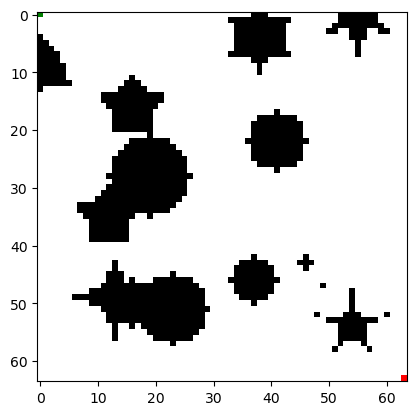

256


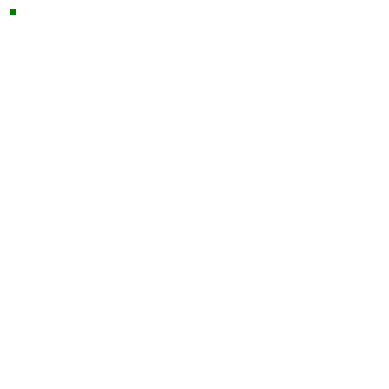

In [28]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "green"   # 3
])


# start_x = np.random.choice(range(env_size[0]))
# start_y = np.random.choice(range(env_size[0]))
# start = (start_y, start_x)

max_steps = 1000
# goal_x = np.random.choice(range(env_size[0]))
# goal_y = np.random.choice(range(env_size[0]))
# goal = (goal_y, goal_x)

start = (63,63)
goal = (0,0)

environments = np.load('../environment_generation/environments/environments_64_15_1000_1.npy')
grid_list = [grid for grid in environments]

grid = grid_list[2]

env = GridEnvCNN(grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)


images = []
plt.imshow(np.sum(obs['image'] * np.array([1,3,2]).reshape(3, 1, 1), axis=0), cmap=cmap)
plt.show()


model = PPO.load("models/ppo_custom_cnn_64x64_lvl_3", env=env, device='cuda')


for i in range(200):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    image = np.sum(obs['image'] * np.array([1,3,2]).reshape(3, 1, 1), axis = 0)
    images.append(image)
    if terminated or truncated:
        break

frames = []

for frame in images:
    plt.imshow(frame, cmap=cmap)
    plt.axis('off')


    plt.savefig("temp.png", bbox_inches='tight', pad_inches=0)
    frames.append(Image.open("temp.png"))

# save as GIF
frames[0].save(
    "15_objects_grid.gif",
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0
)

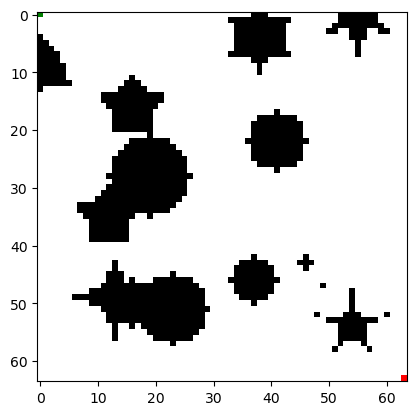

256


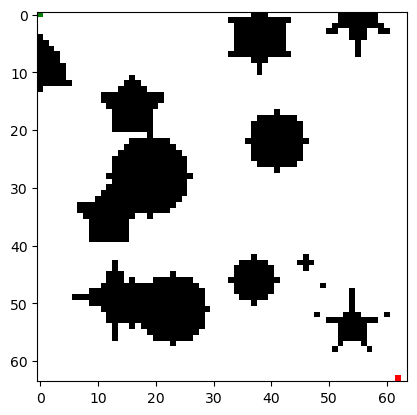

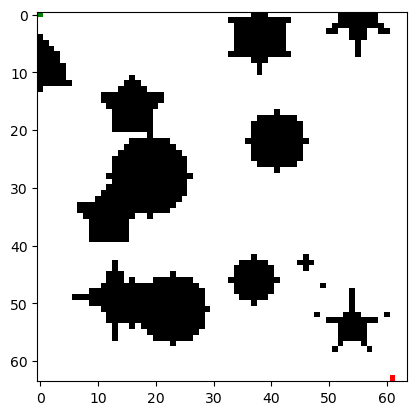

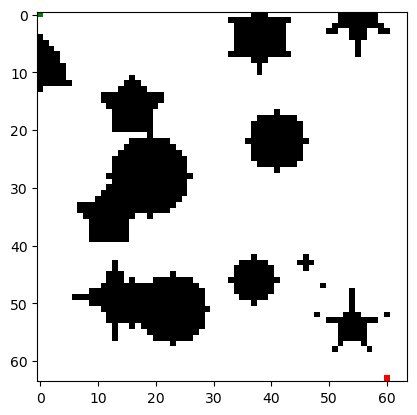

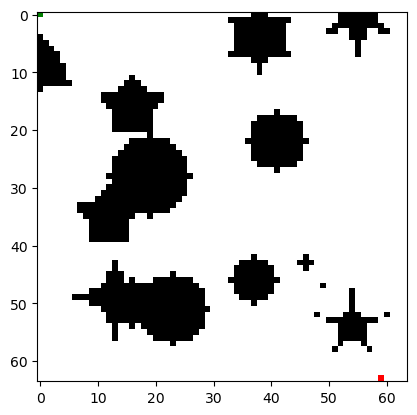

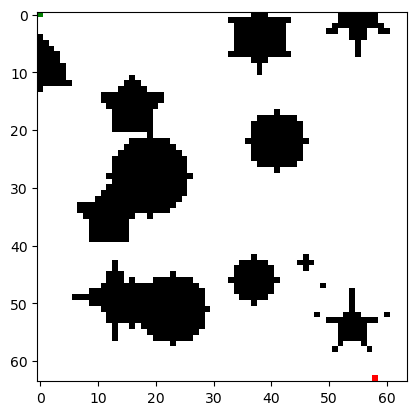

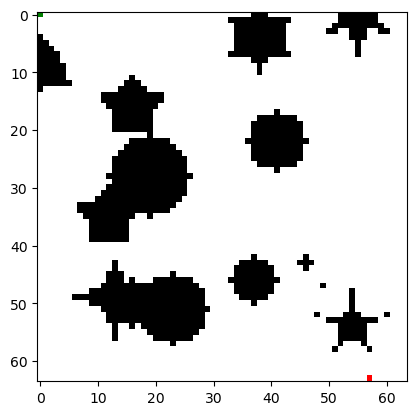

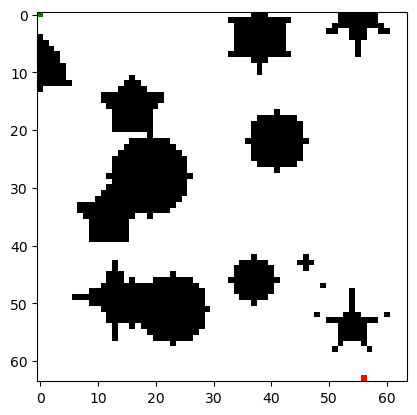

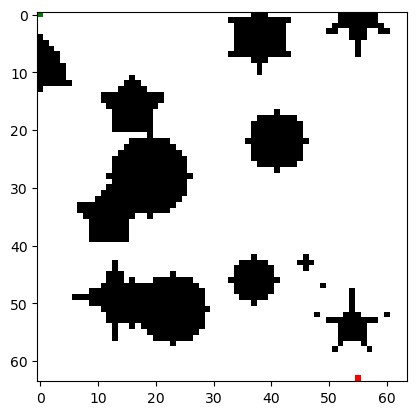

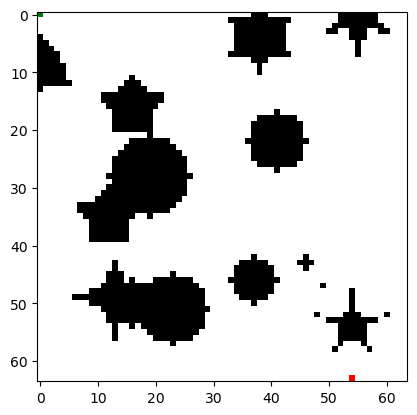

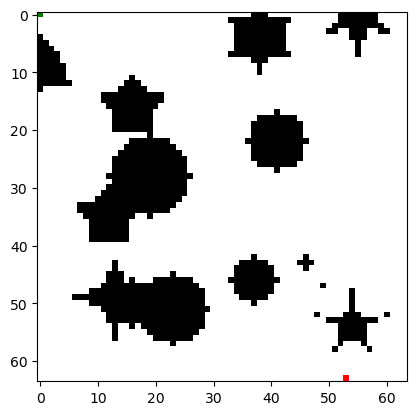

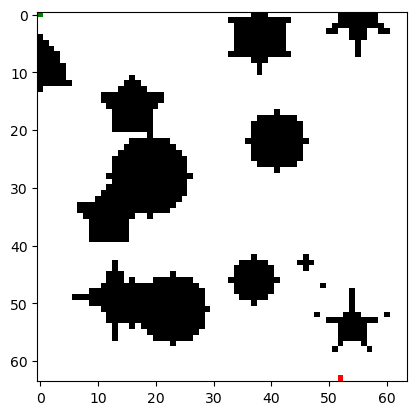

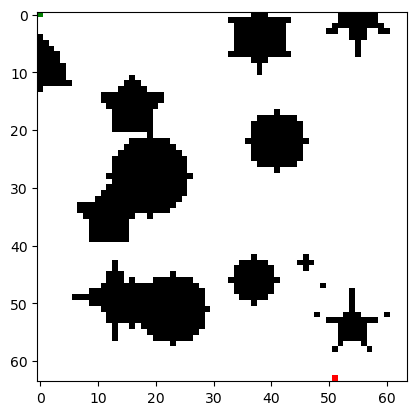

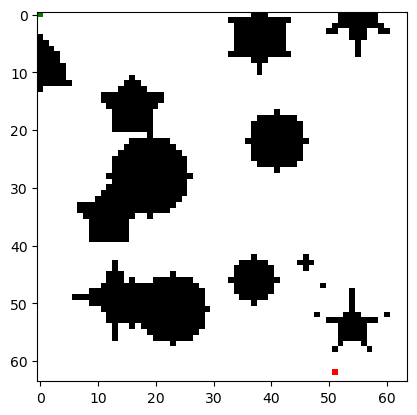

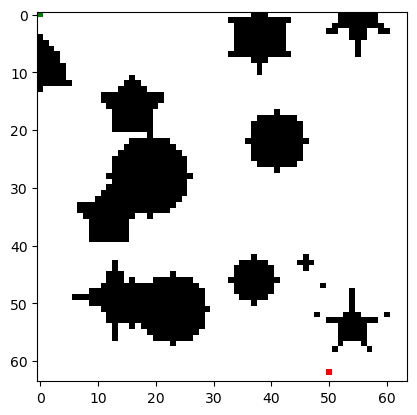

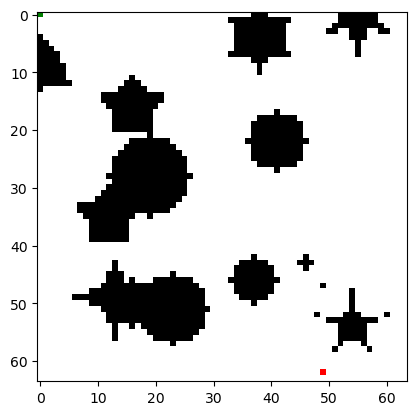

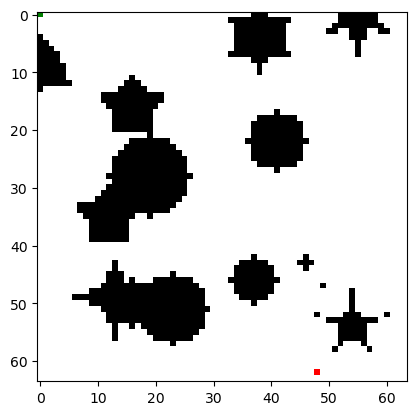

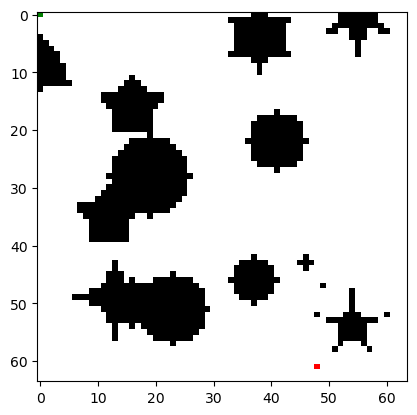

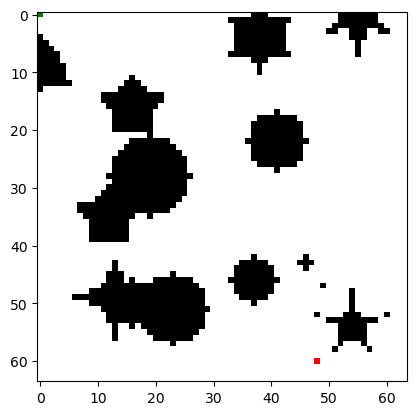

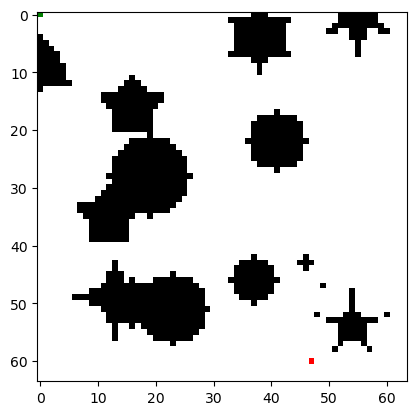

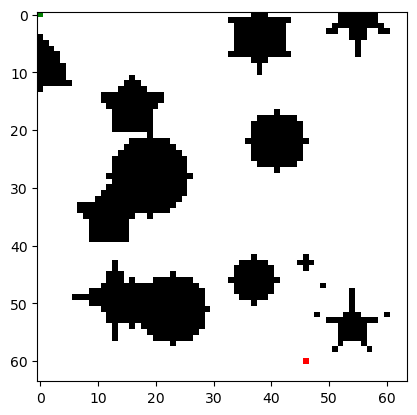

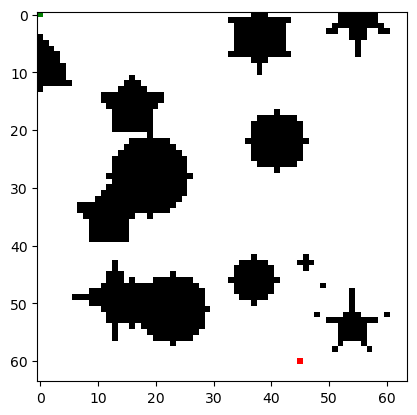

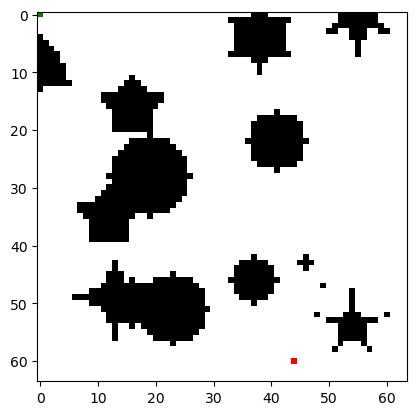

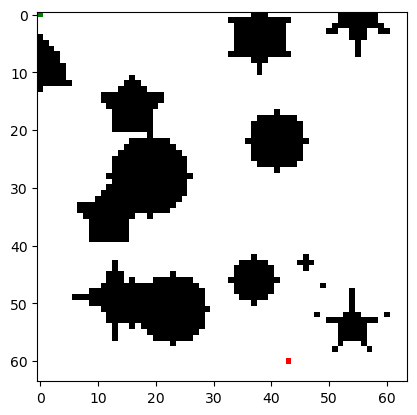

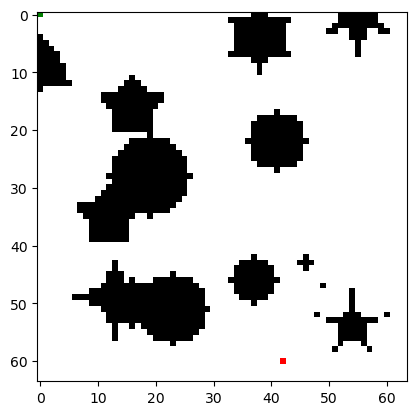

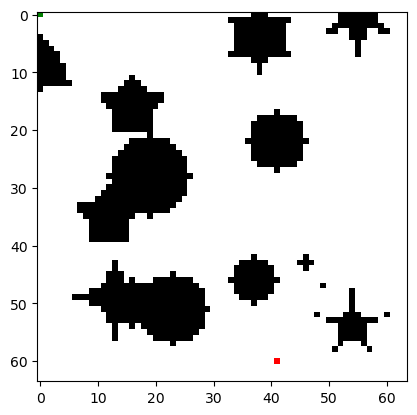

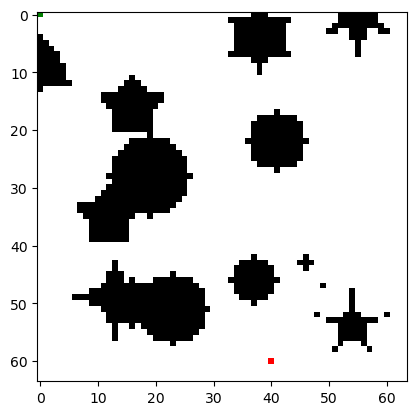

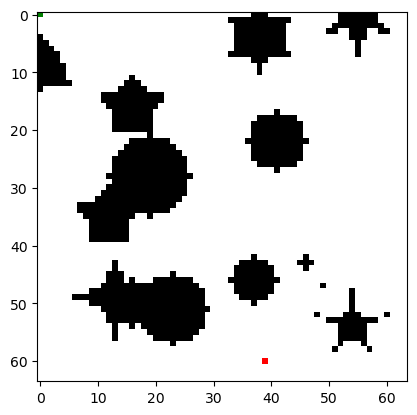

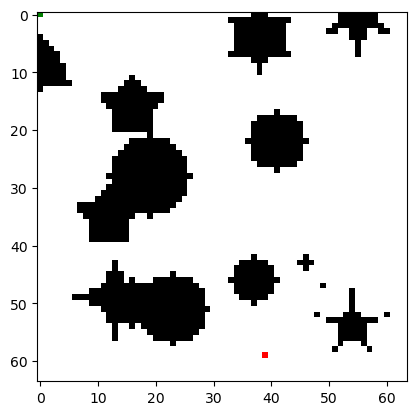

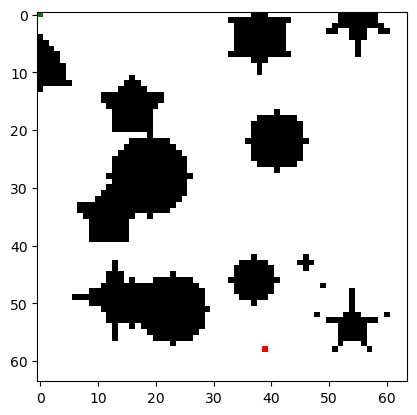

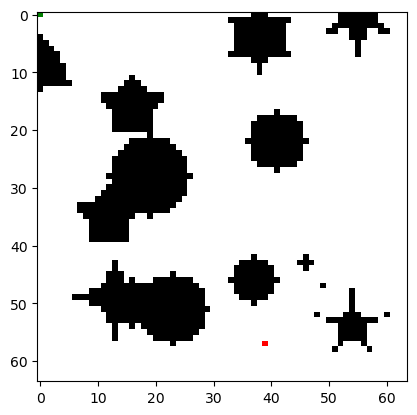

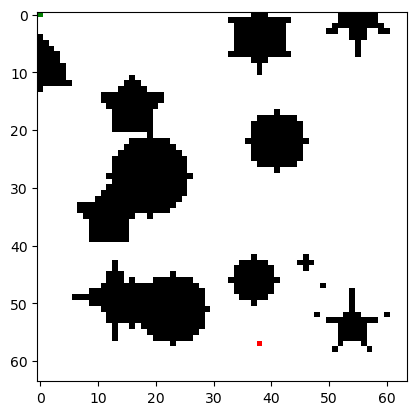

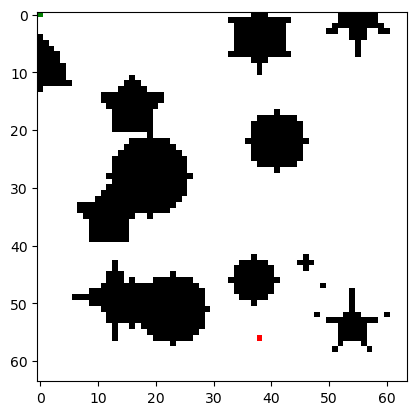

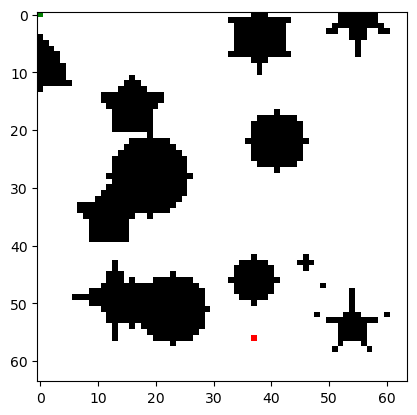

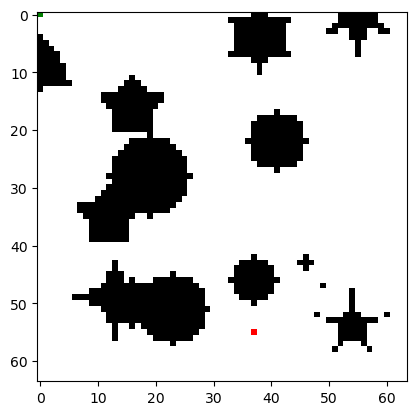

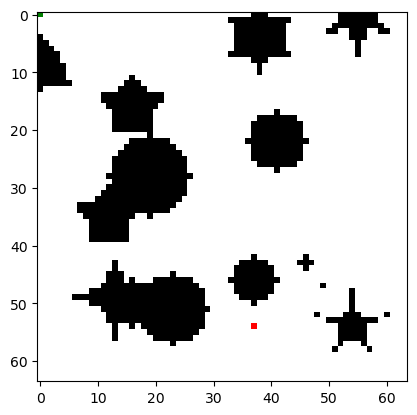

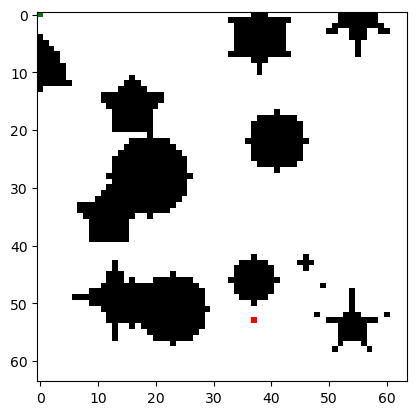

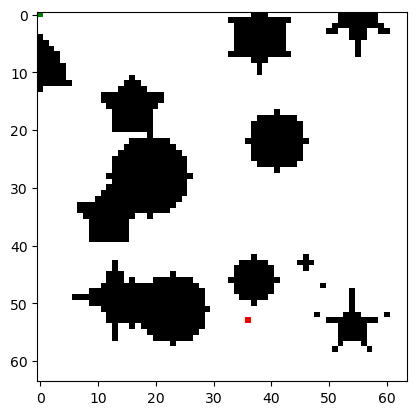

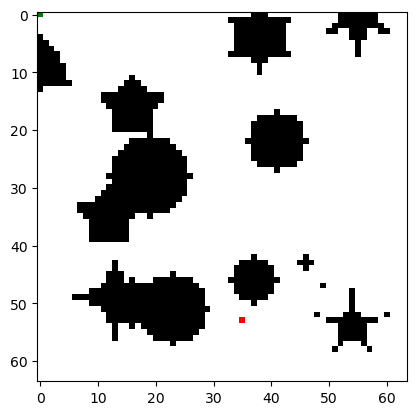

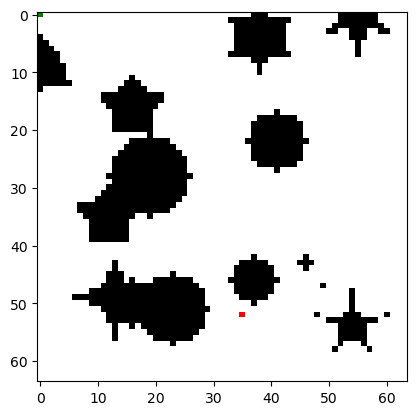

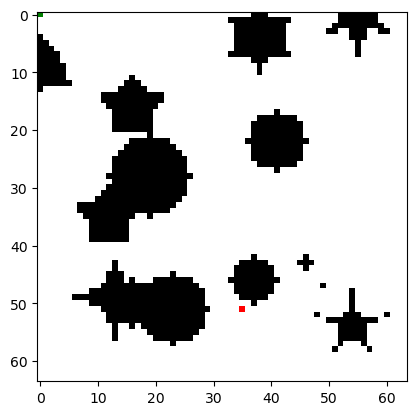

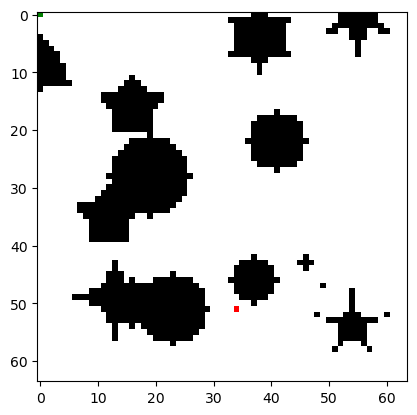

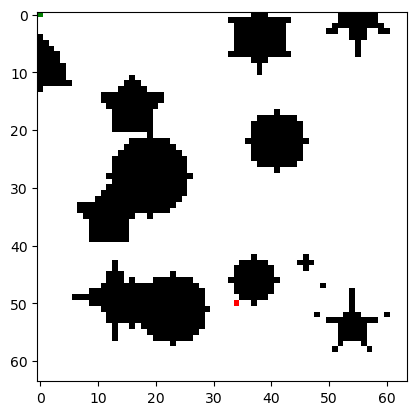

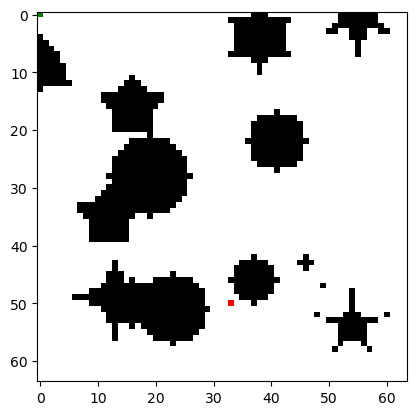

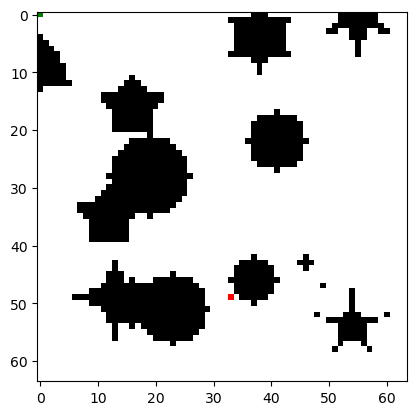

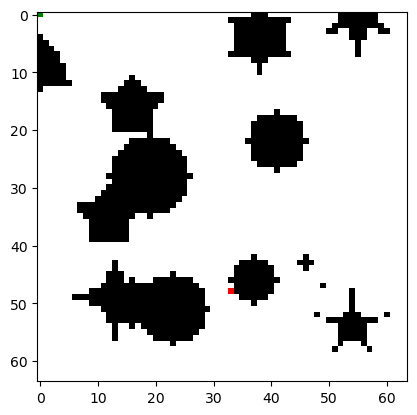

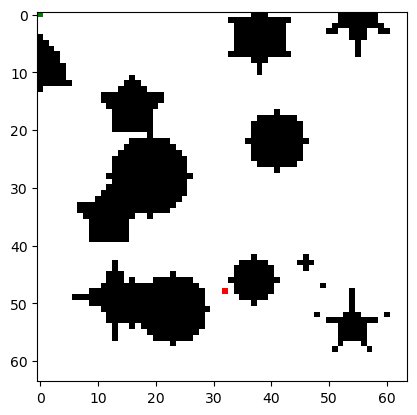

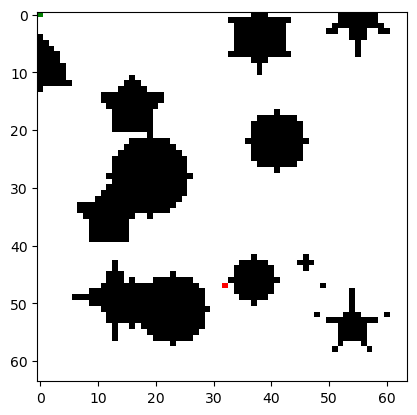

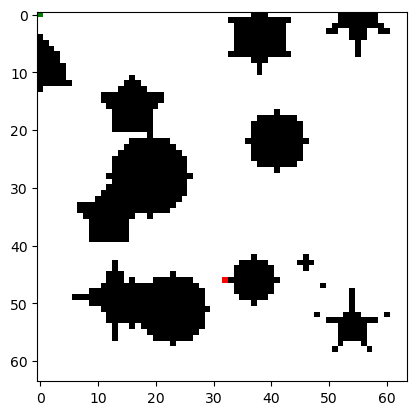

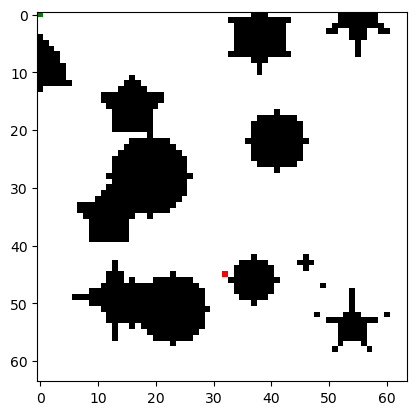

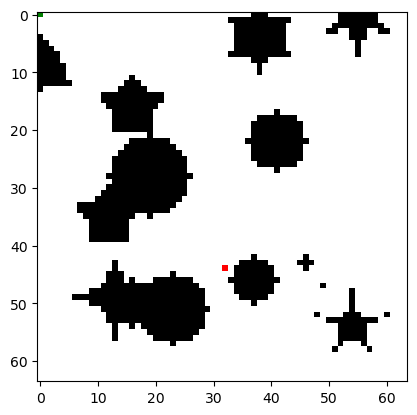

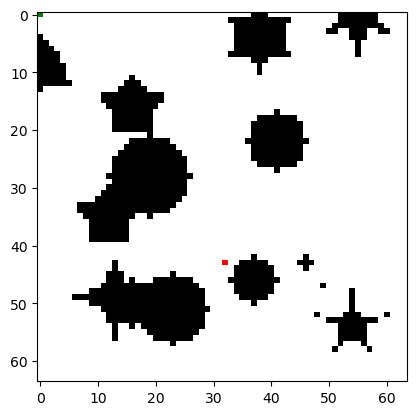

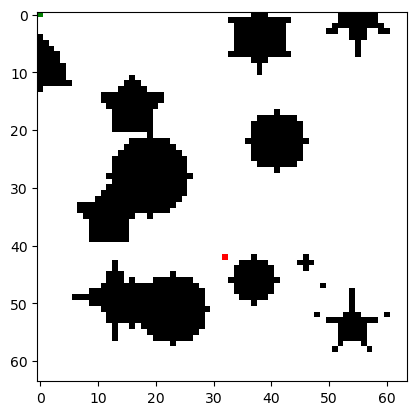

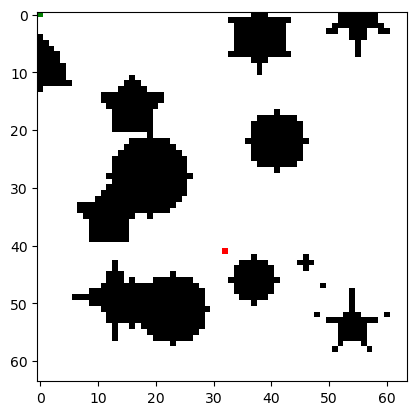

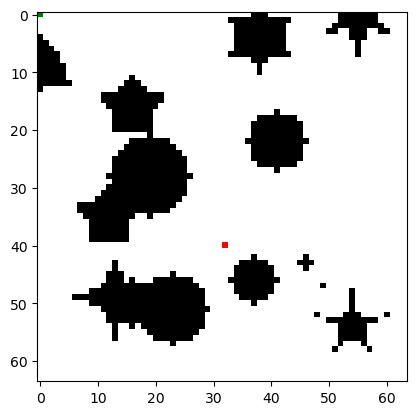

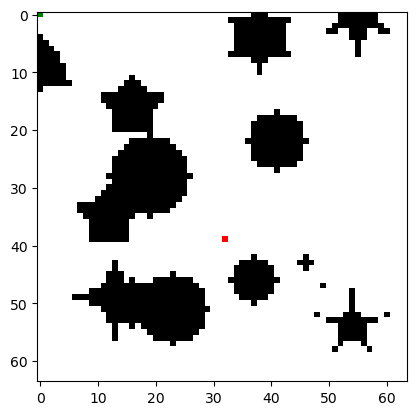

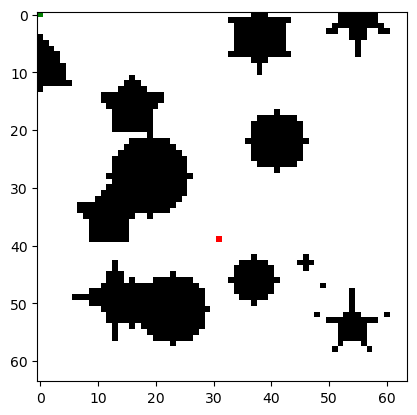

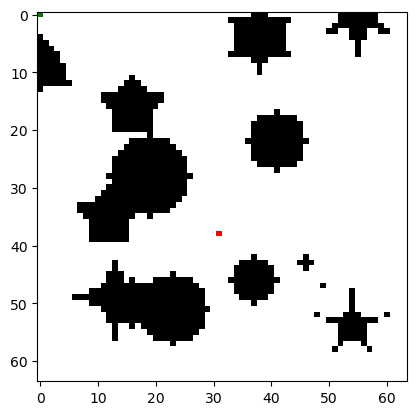

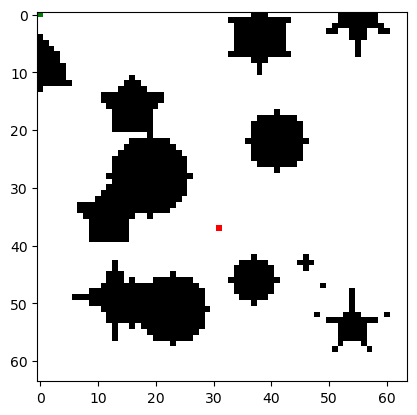

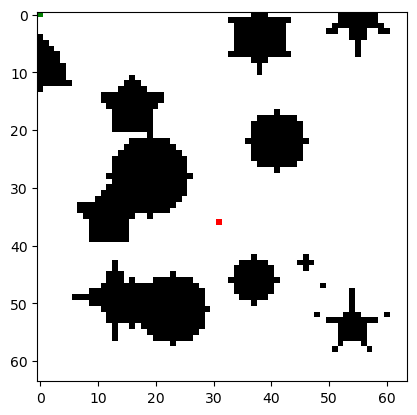

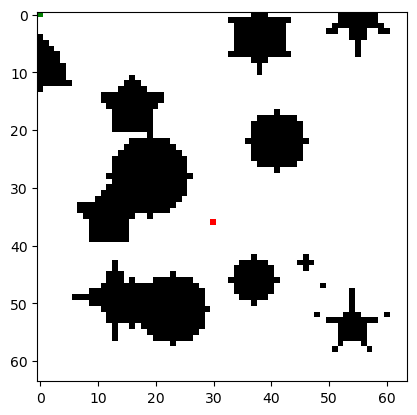

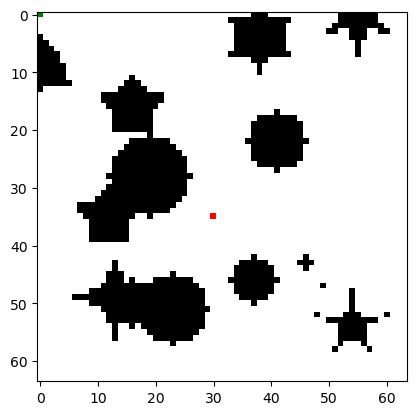

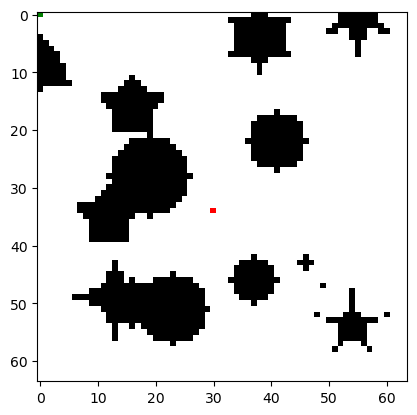

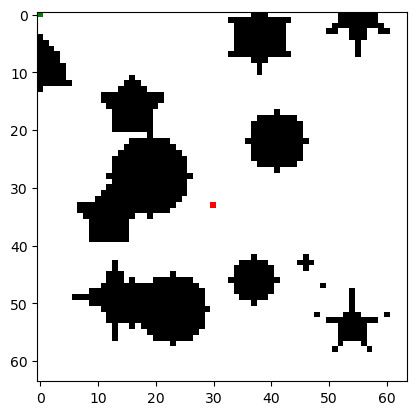

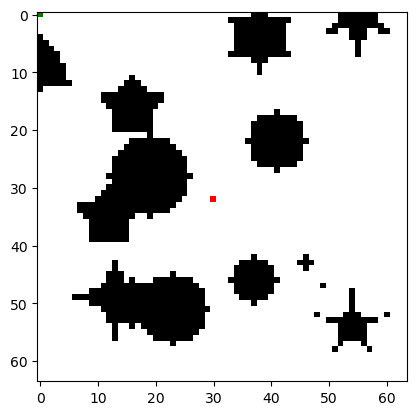

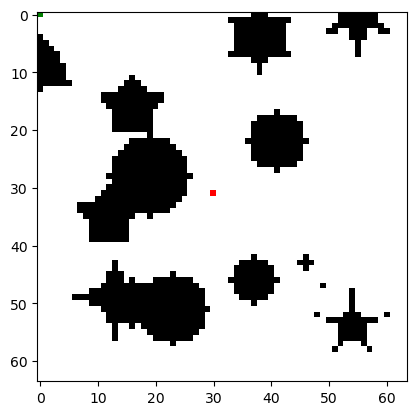

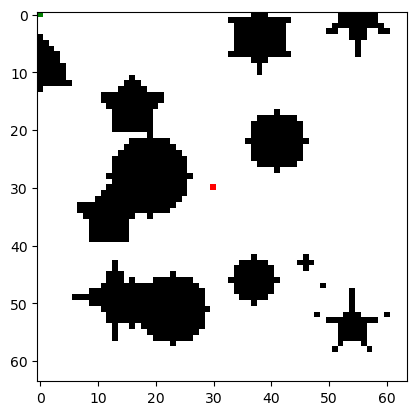

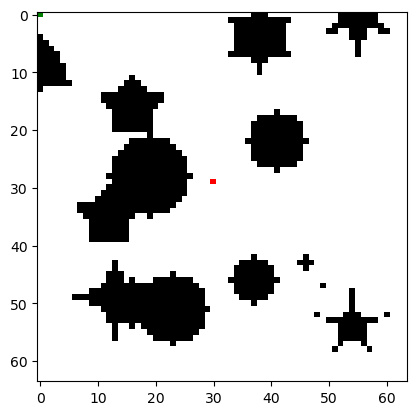

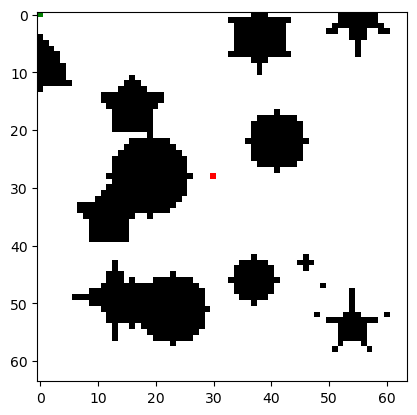

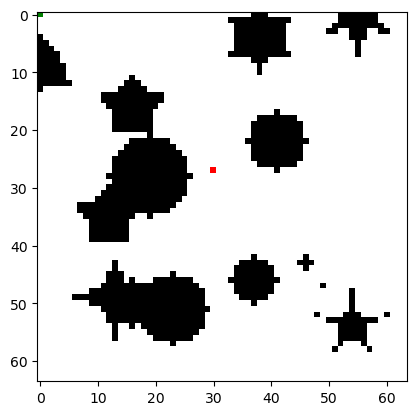

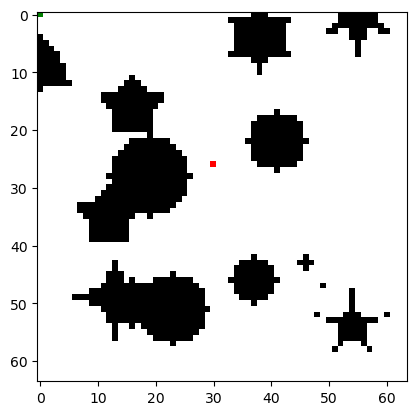

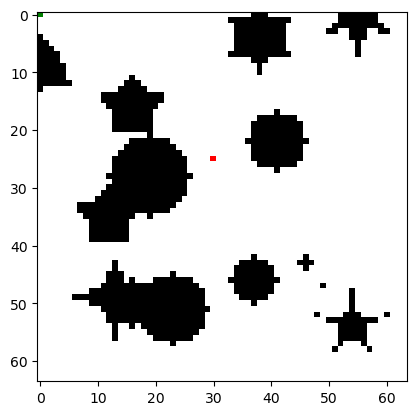

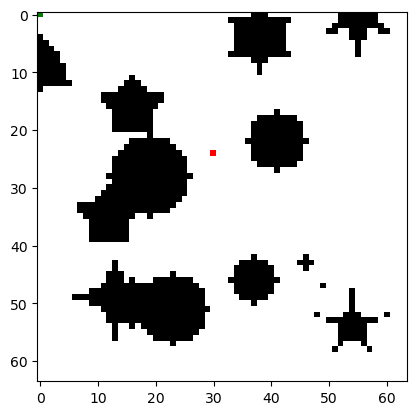

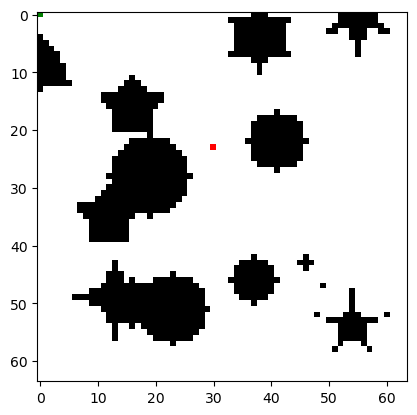

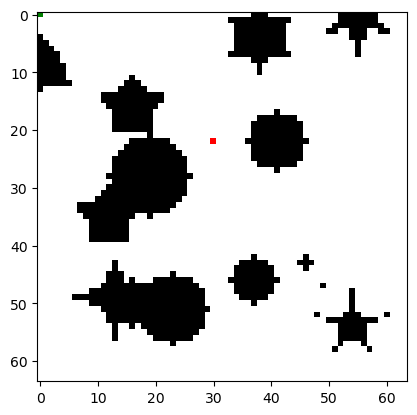

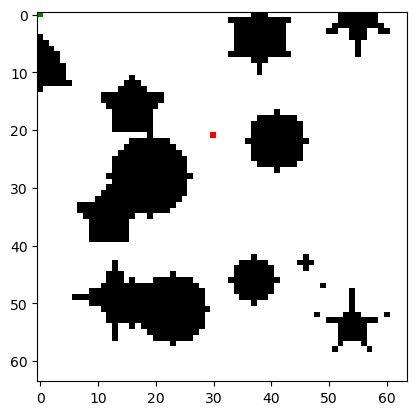

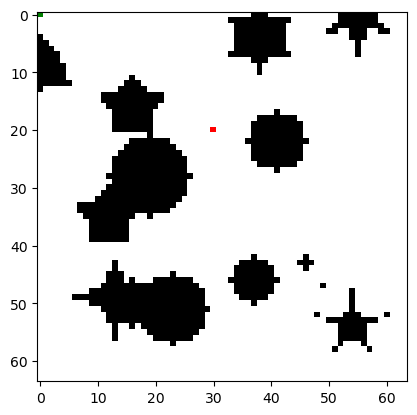

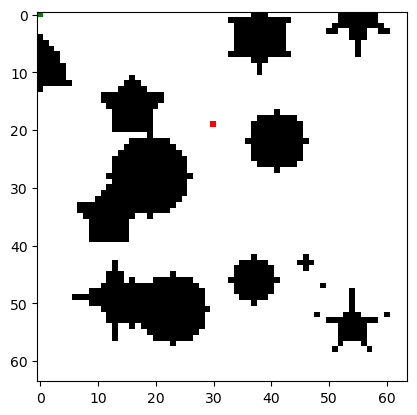

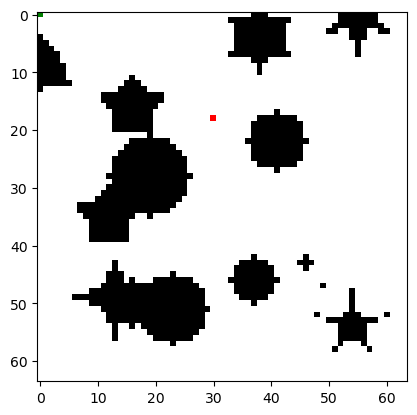

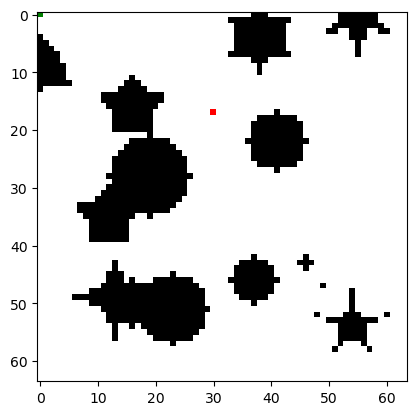

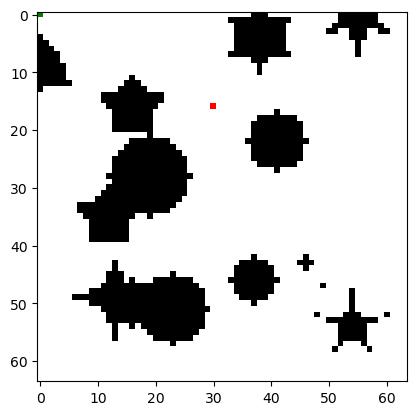

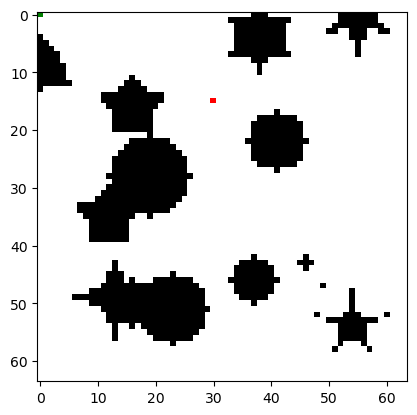

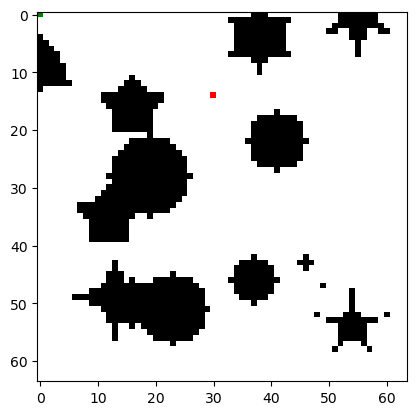

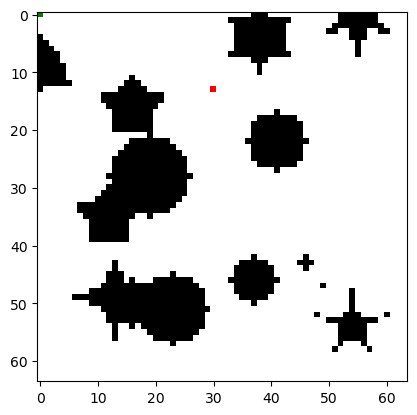

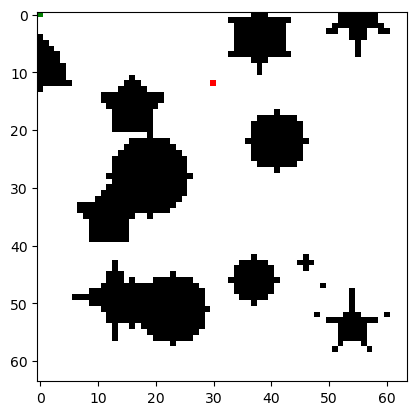

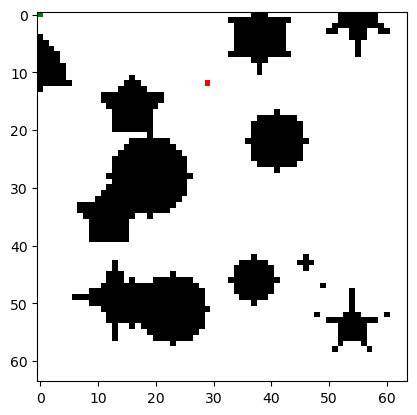

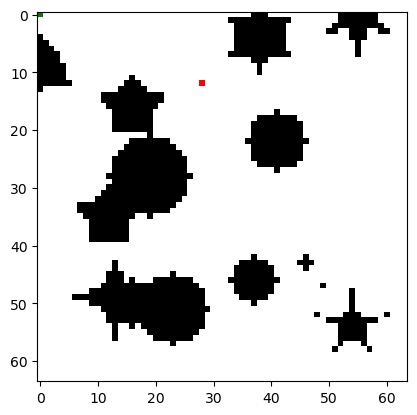

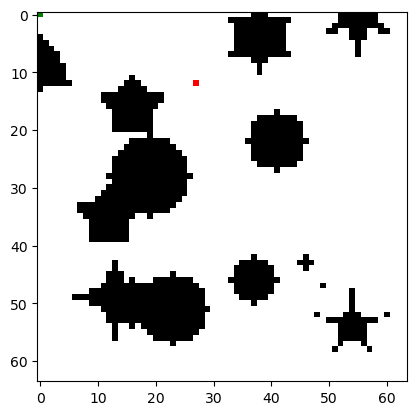

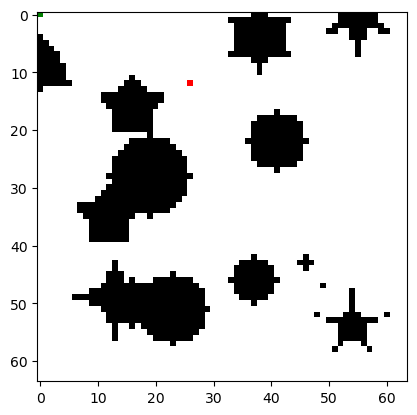

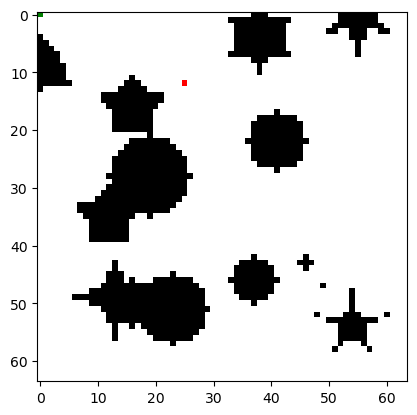

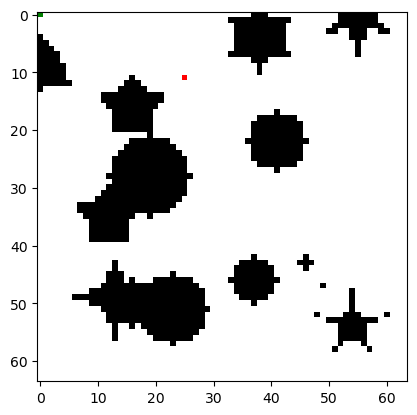

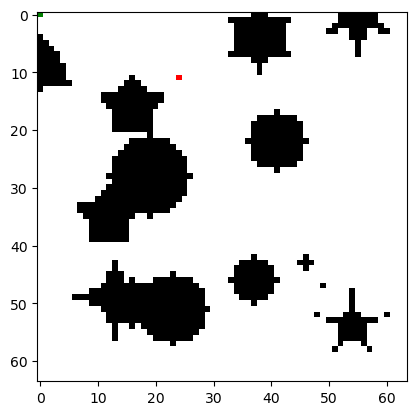

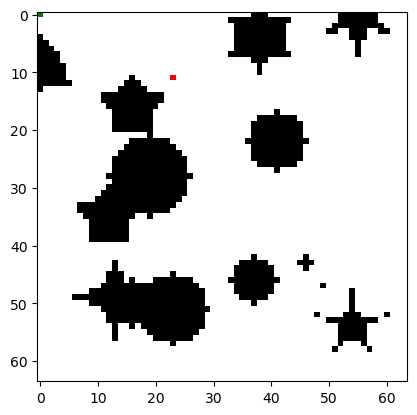

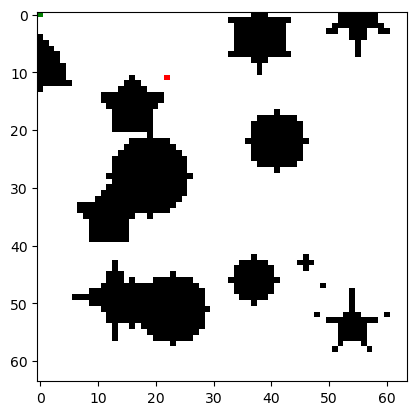

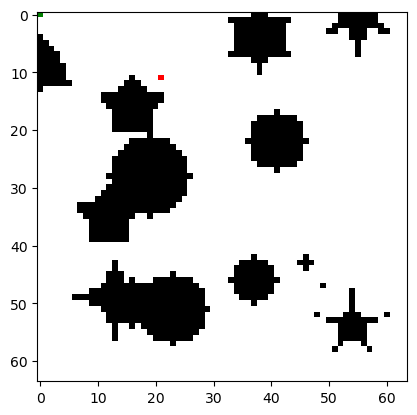

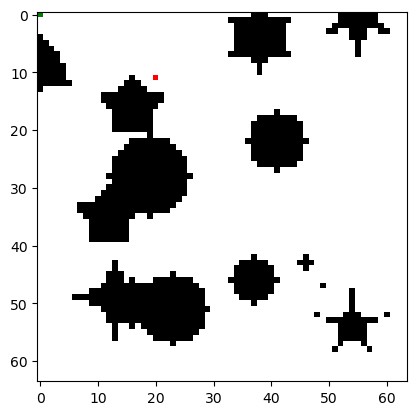

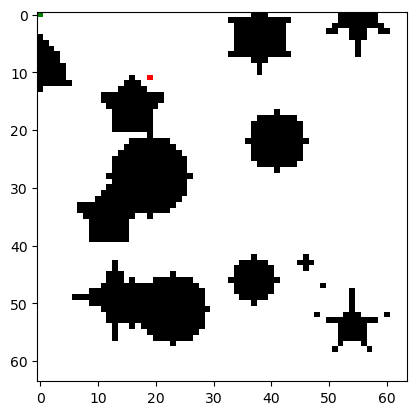

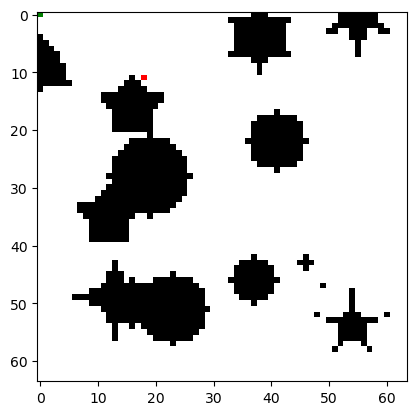

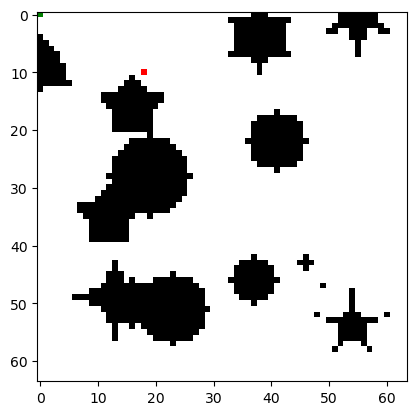

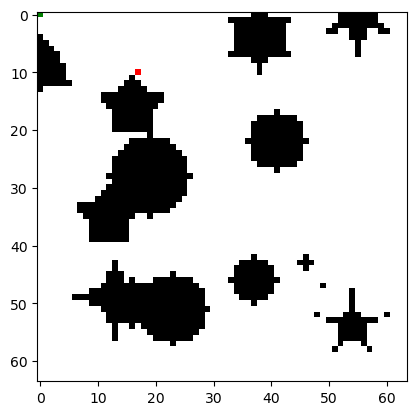

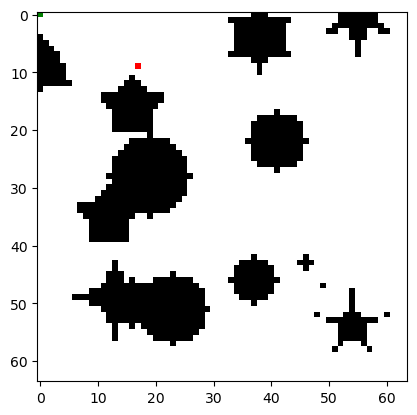

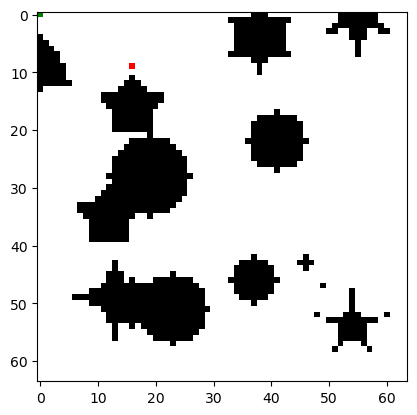

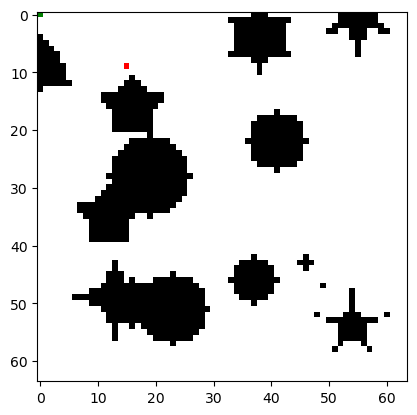

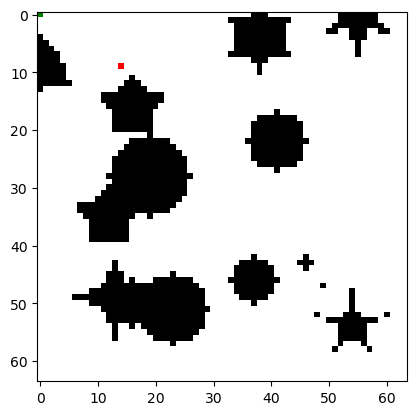

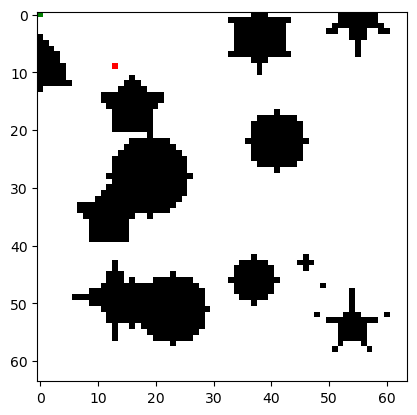

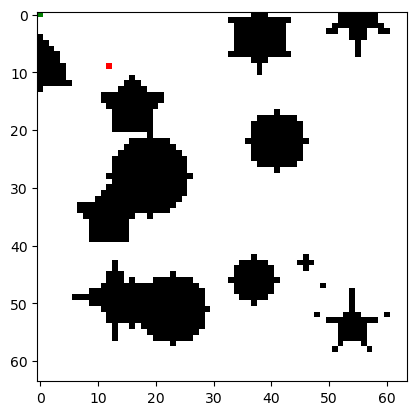

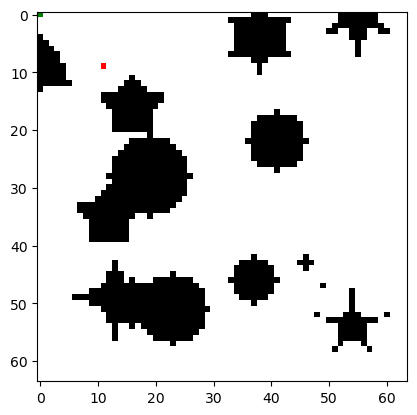

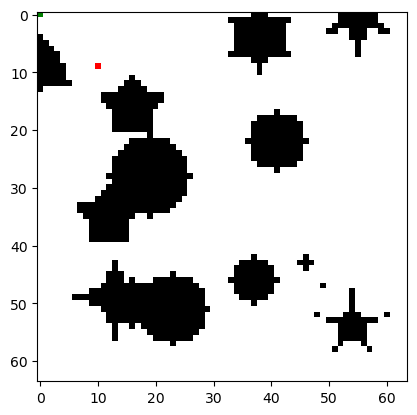

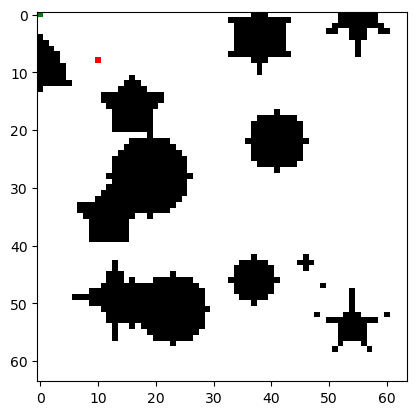

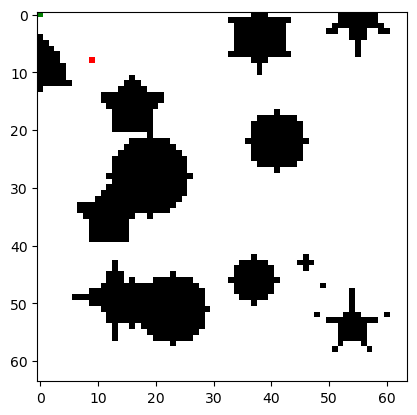

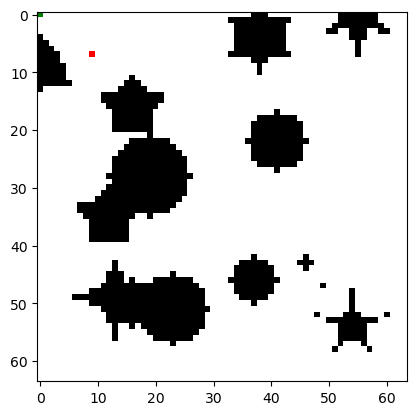

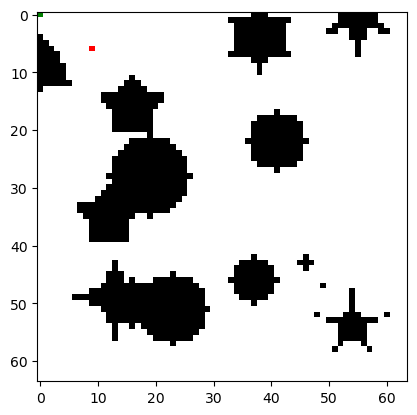

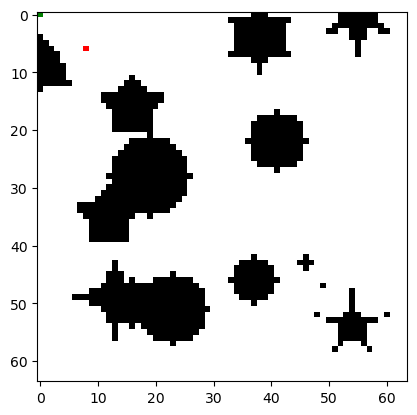

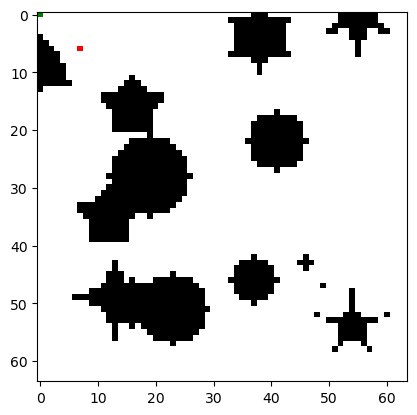

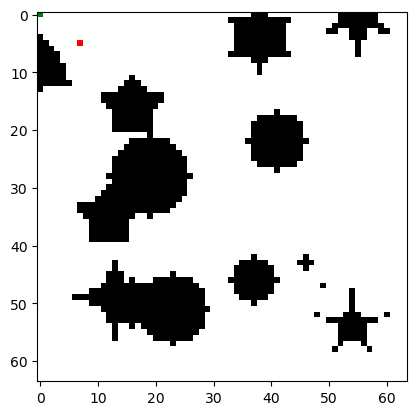

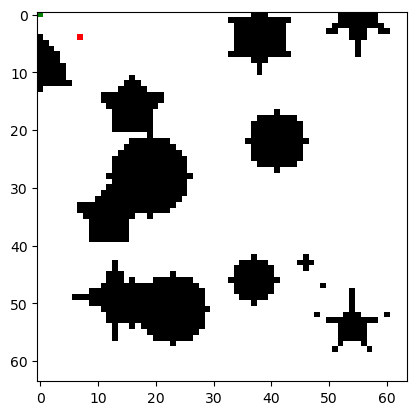

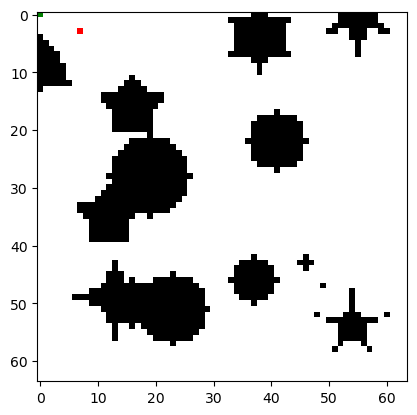

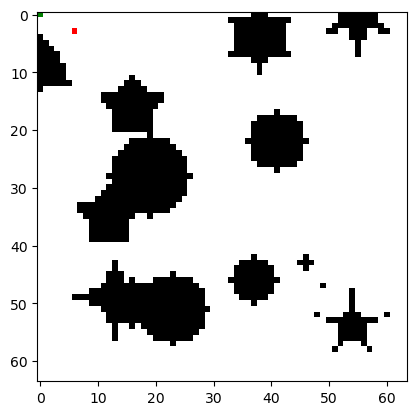

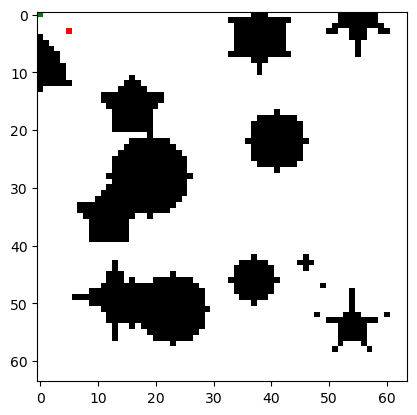

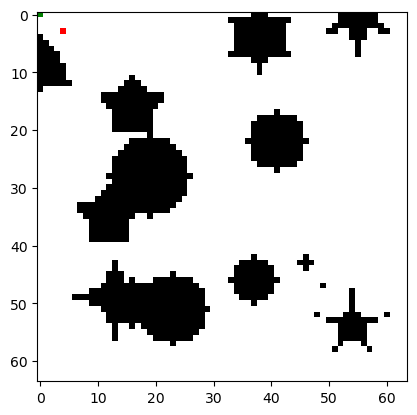

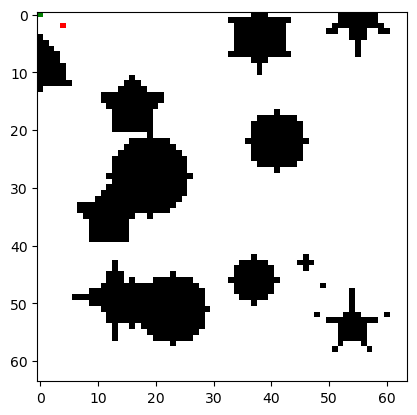

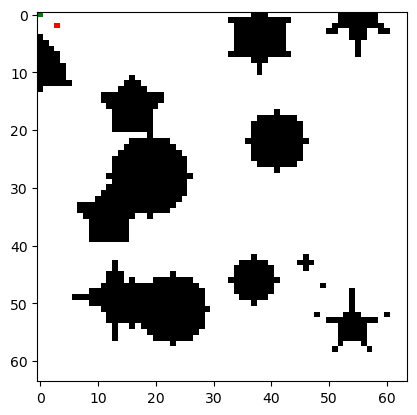

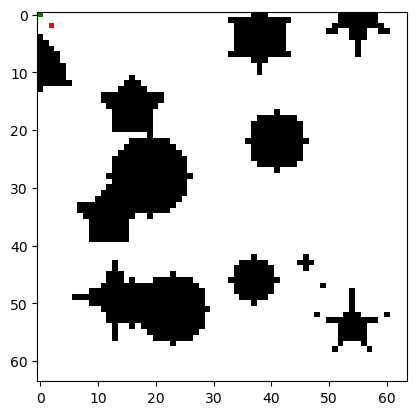

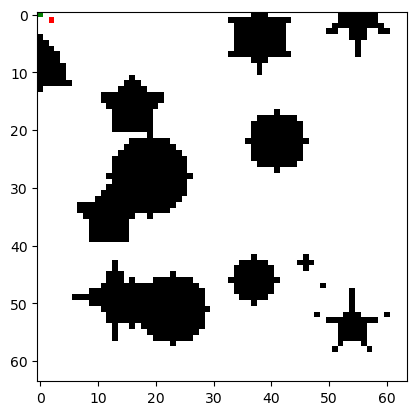

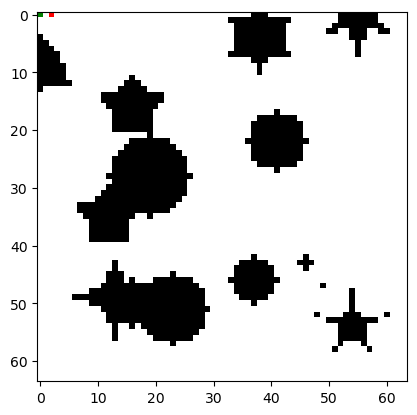

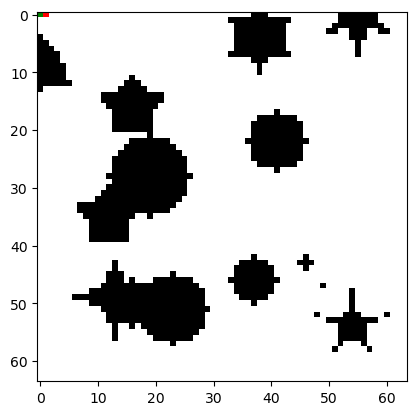

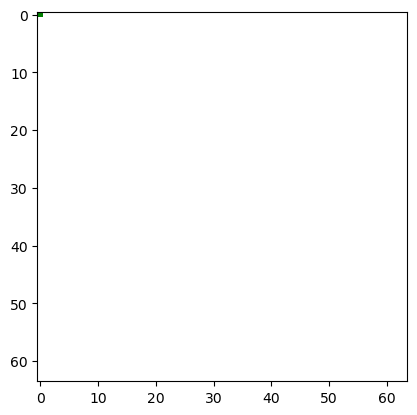

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "green"   # 3
])


# start_x = np.random.choice(range(env_size[0]))
# start_y = np.random.choice(range(env_size[0]))
# start = (start_y, start_x)

max_steps = 1000
# goal_x = np.random.choice(range(env_size[0]))
# goal_y = np.random.choice(range(env_size[0]))
# goal = (goal_y, goal_x)

start = (63,63)
goal = (0,0)

environments = np.load('../environment_generation/environments/environments_64_15_1000_1.npy')
grid_list = [grid for grid in environments]

grid = grid_list[2]

env = GridEnvCNN(grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)


images = []
plt.imshow(np.sum(obs['image'] * np.array([1,3,2]).reshape(3, 1, 1), axis=0), cmap=cmap)
plt.show()


model = PPO.load("models/ppo_custom_cnn_64x64_lvl_3", env=env, device='cuda')


for i in range(200):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    
    plt.imshow(np.sum(obs['image'] * np.array([1,3,2]).reshape(3, 1, 1), axis=0), cmap=cmap)
    plt.show()
    if terminated or truncated:
        break

## Level 4

In [15]:
environments = np.load('../environment_generation/environments/environments_64_15_1000_1.npy')
grid_list = [grid for grid in environments]
env_size = (64,64)

env = DummyVecEnv([make_env(grid_list) for _ in range(512)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_3", env=env, device='cuda')
model.learn(total_timesteps=6_000_000, progress_bar=True, tb_log_name="Level 4")

Output()

256


In [16]:
model.save("models/ppo_custom_cnn_64x64_lvl_4")

In [17]:
environments = np.load('../environment_generation/environments/environments_64_15_1000_1.npy')
grid_list = [grid for grid in environments]

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_4", env=env, device='cuda')

test_agent(model, grid_list, goal_region= (64,64), n=100)

256


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]

terminated:  75.0 % with an average of 40.8 steps and a maximum of 99


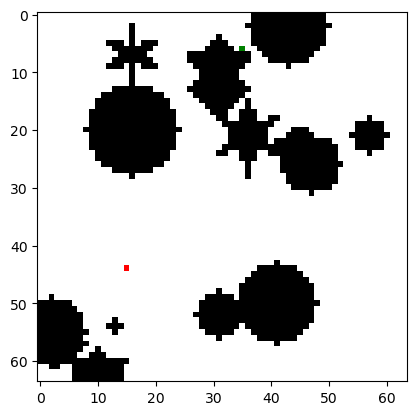

1280


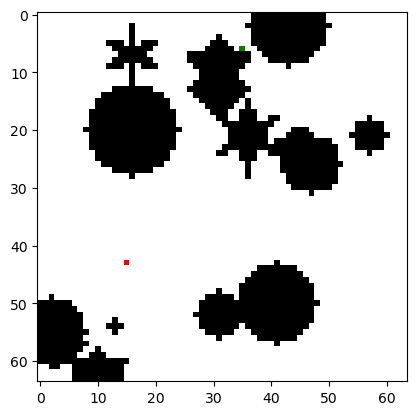

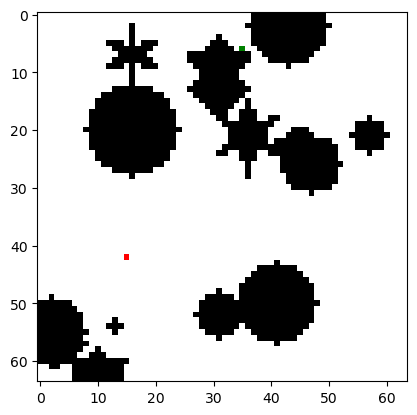

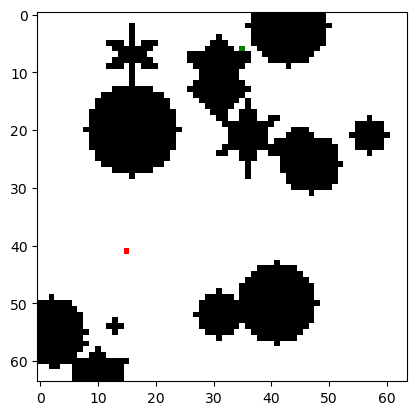

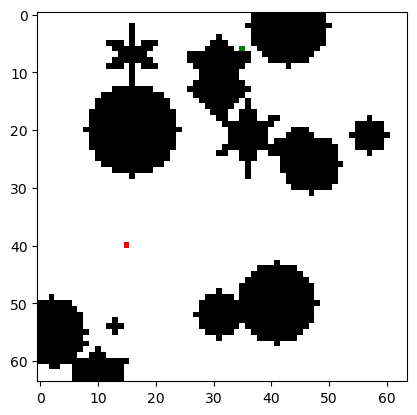

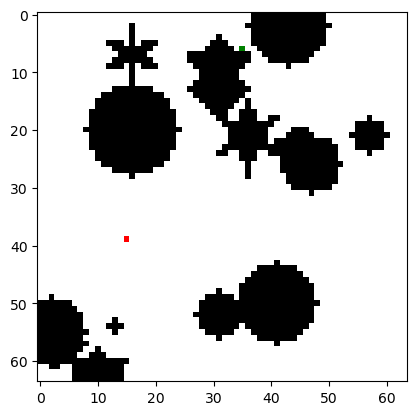

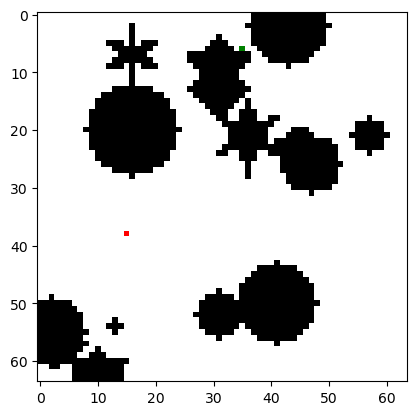

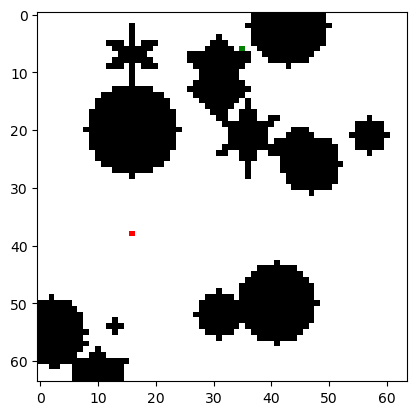

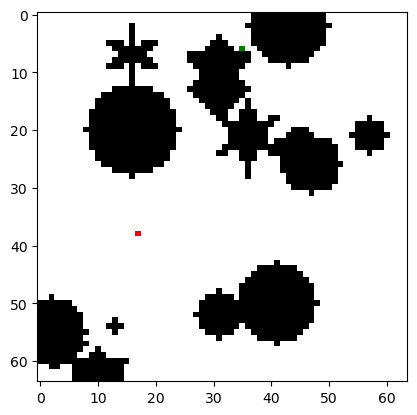

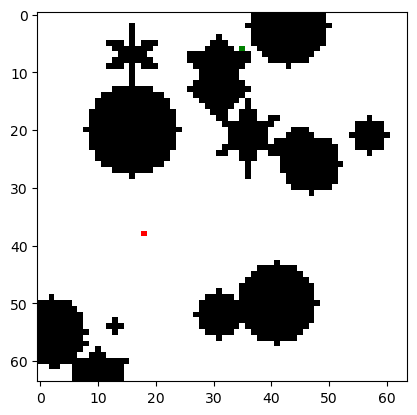

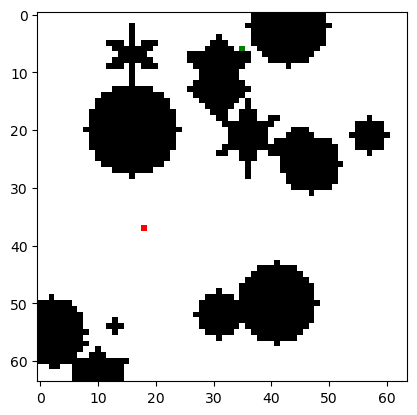

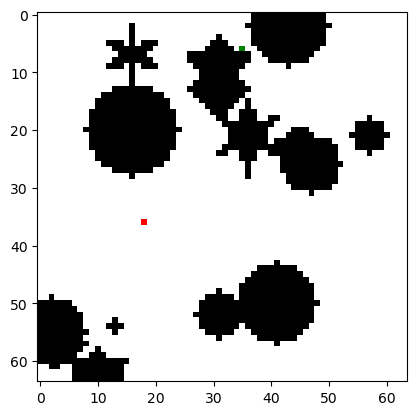

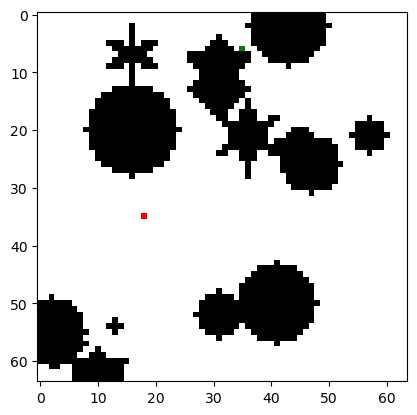

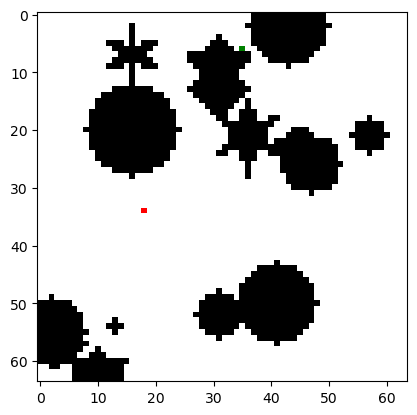

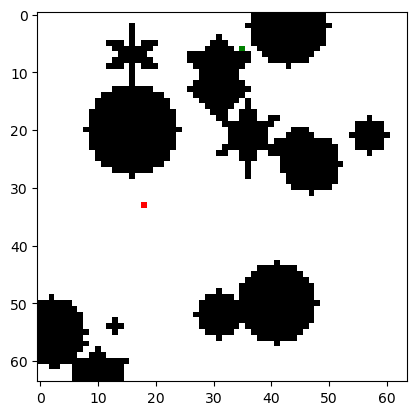

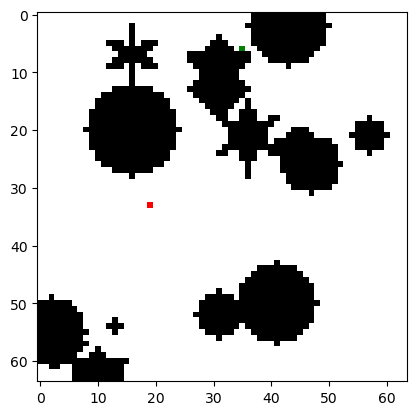

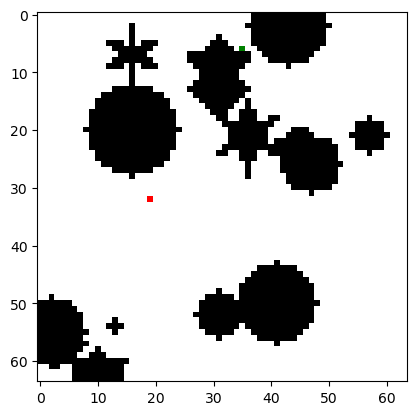

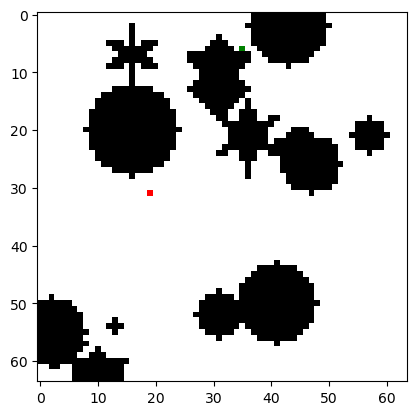

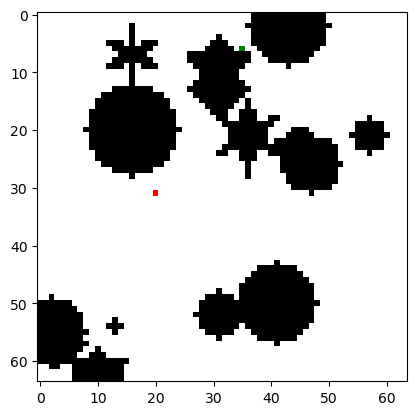

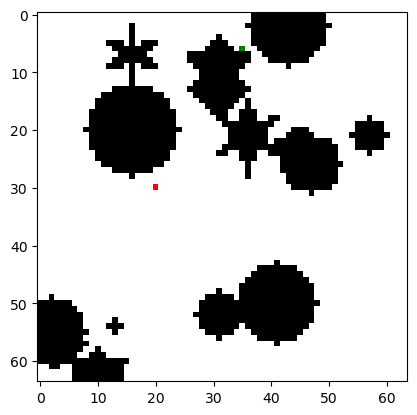

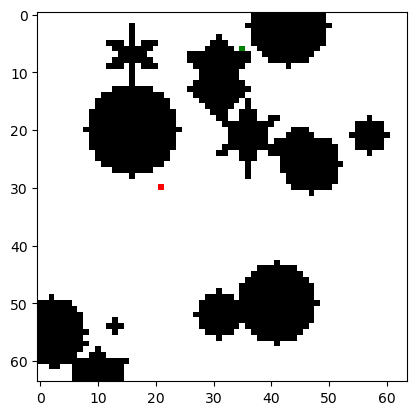

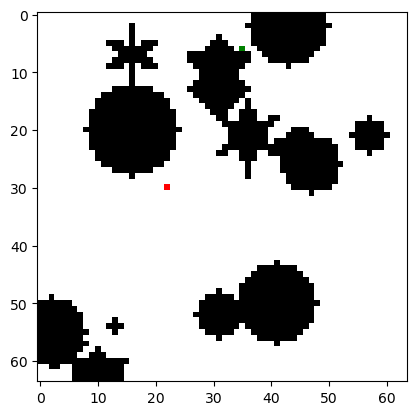

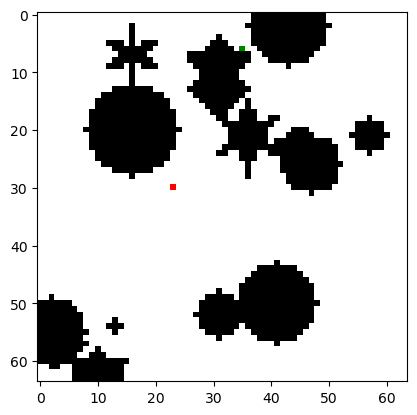

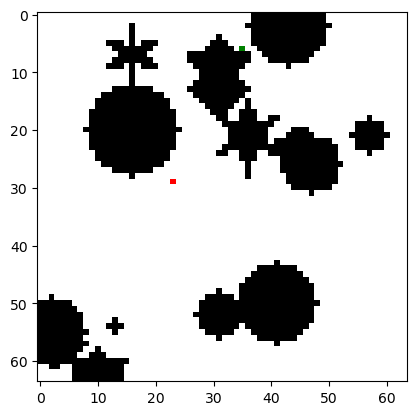

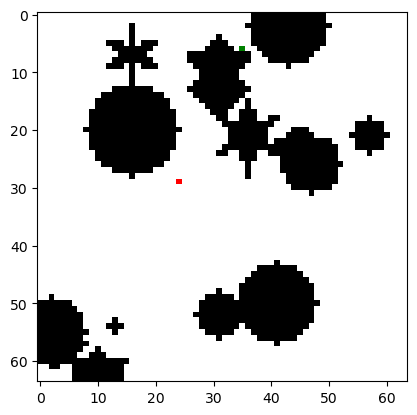

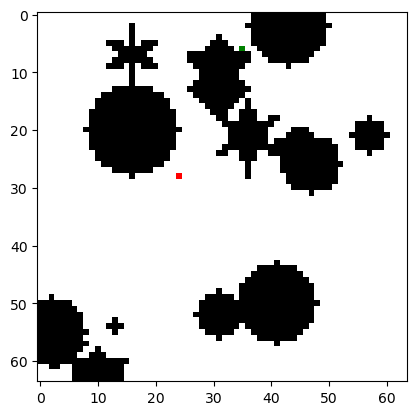

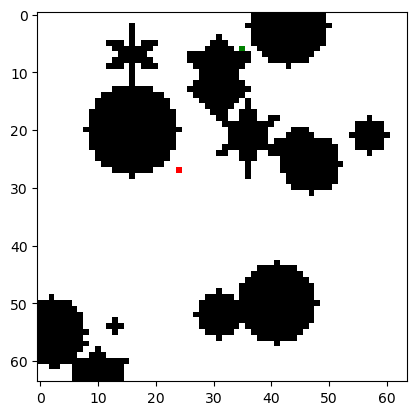

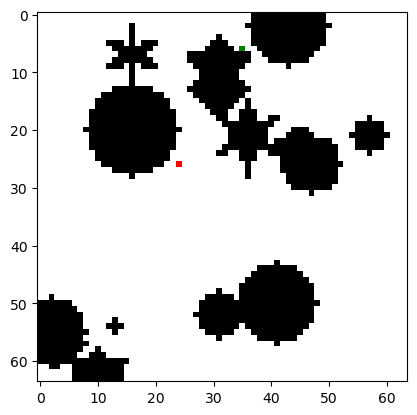

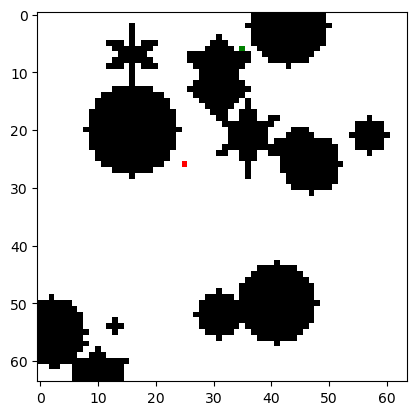

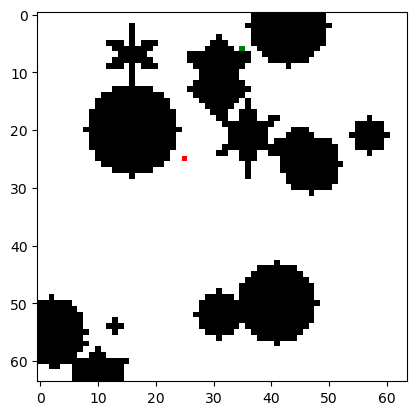

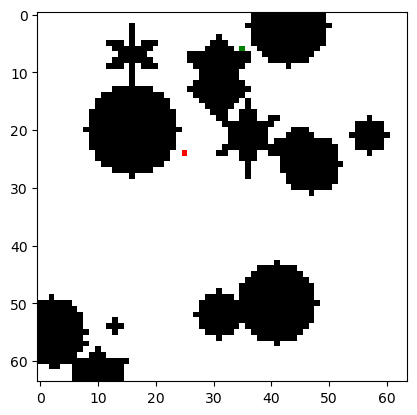

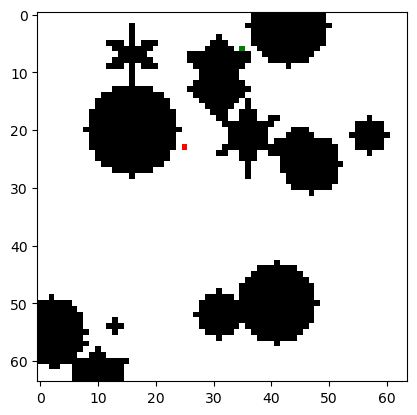

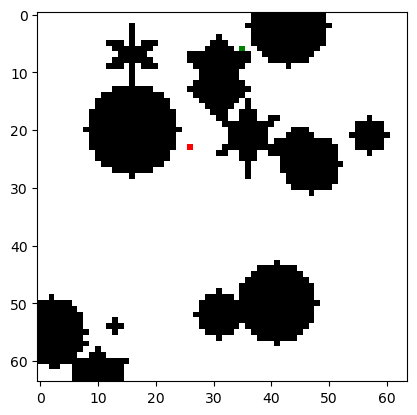

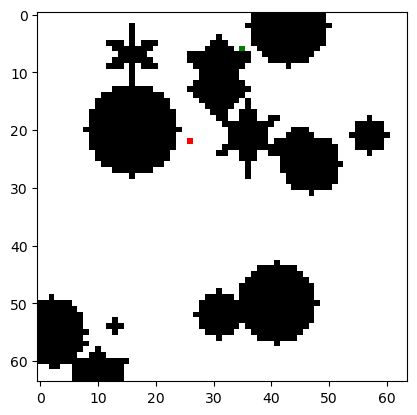

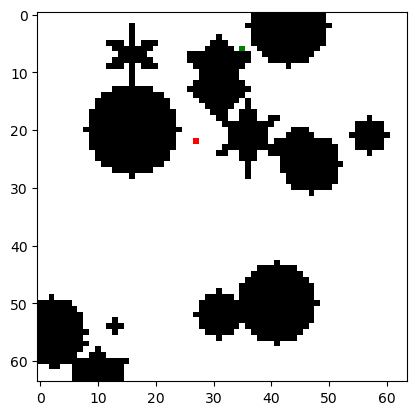

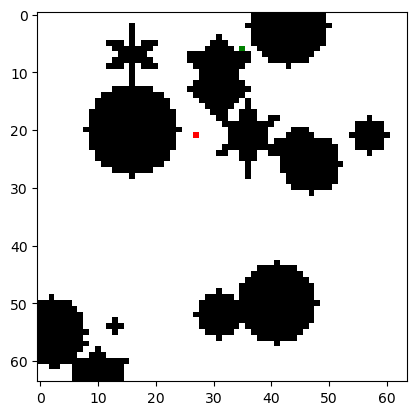

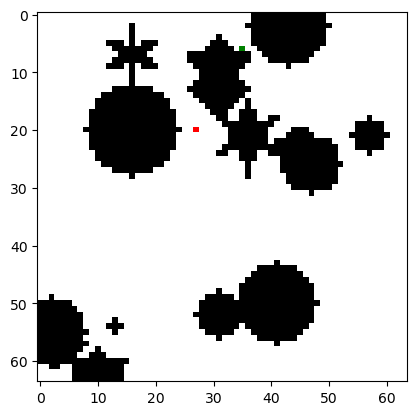

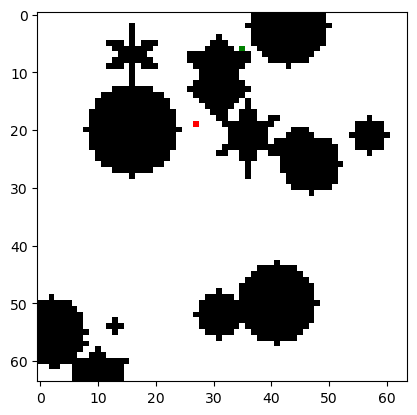

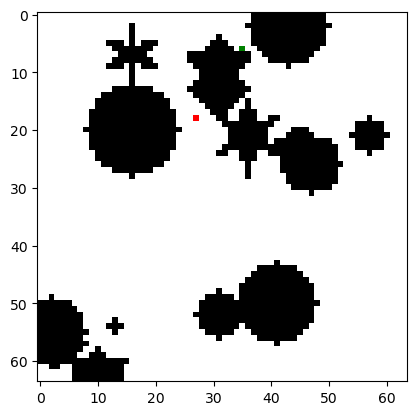

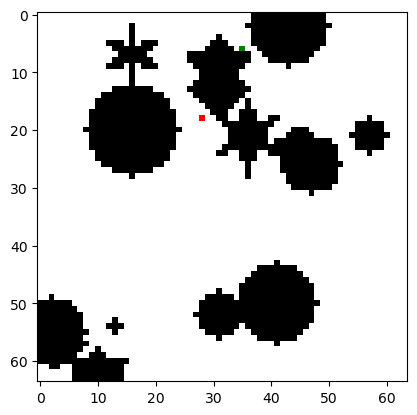

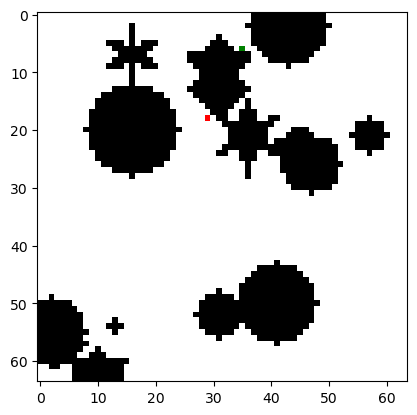

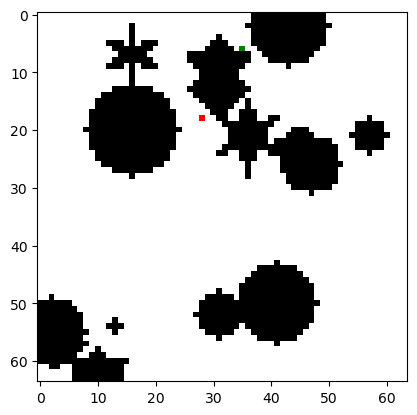

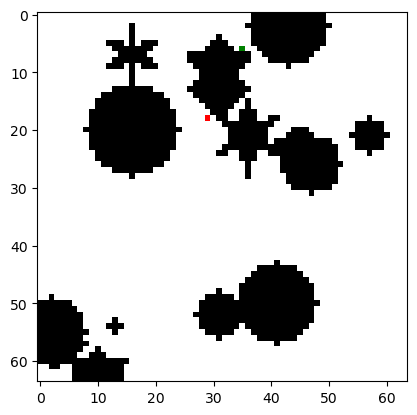

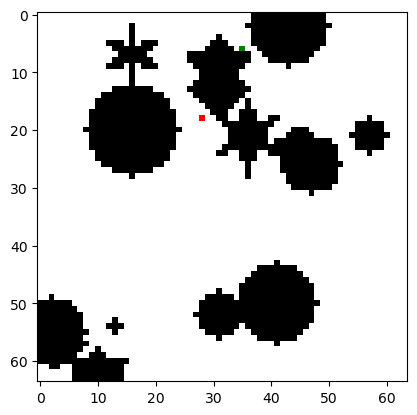

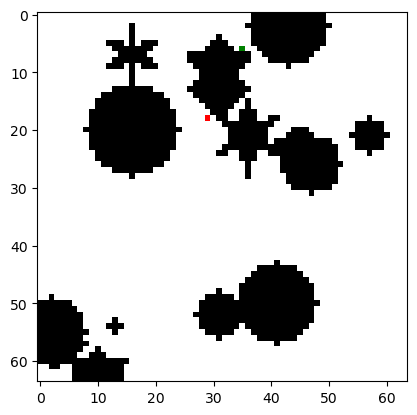

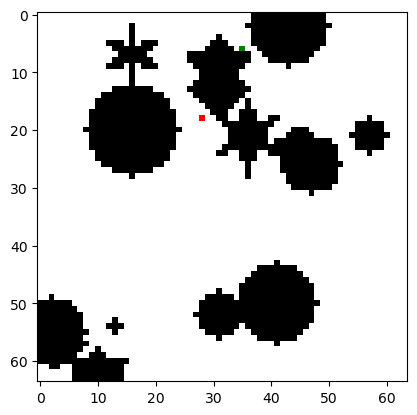

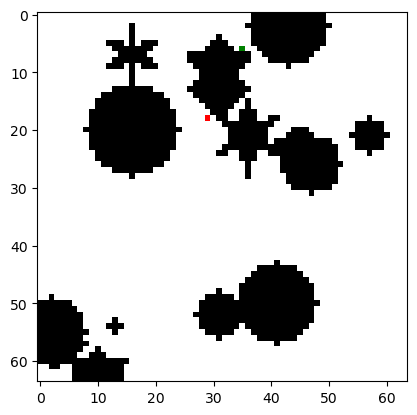

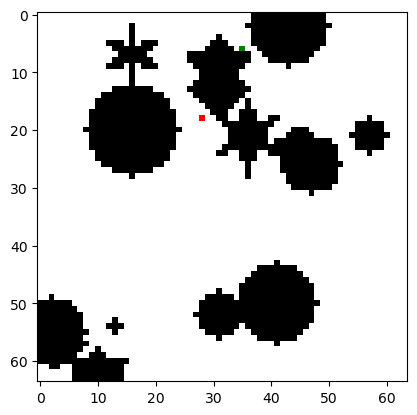

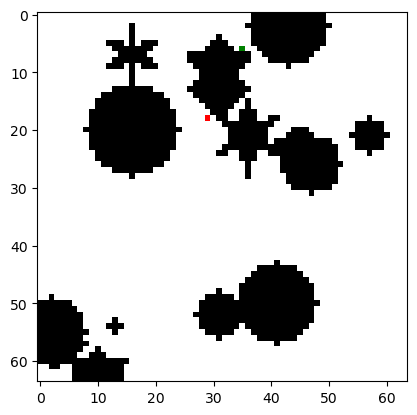

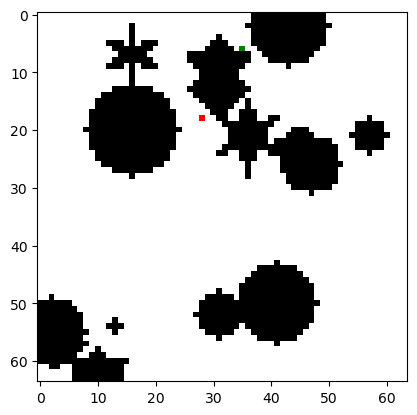

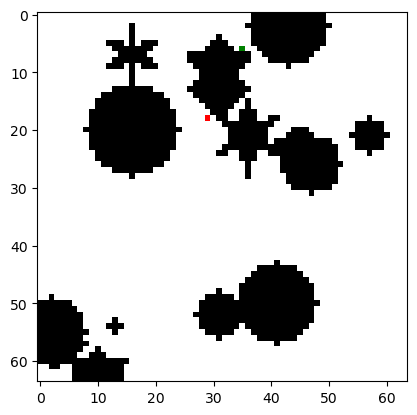

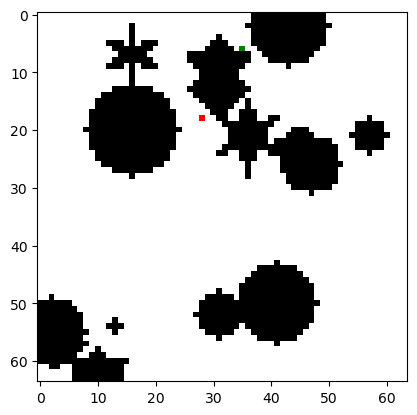

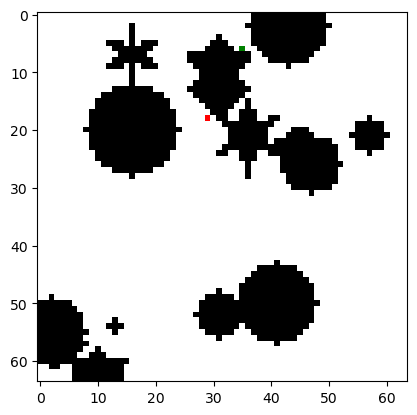

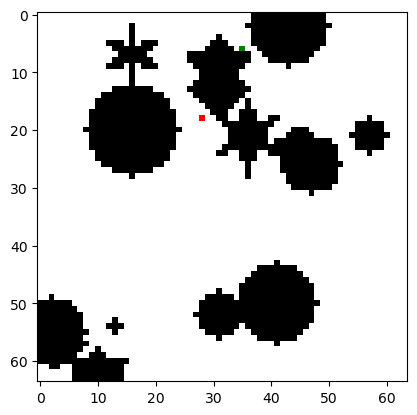

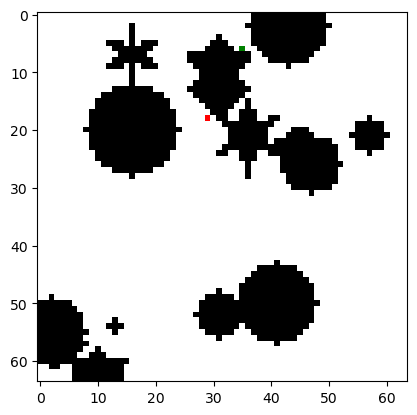

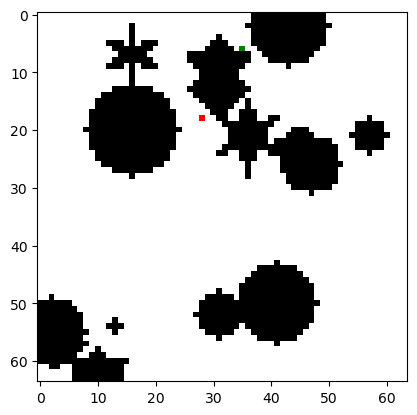

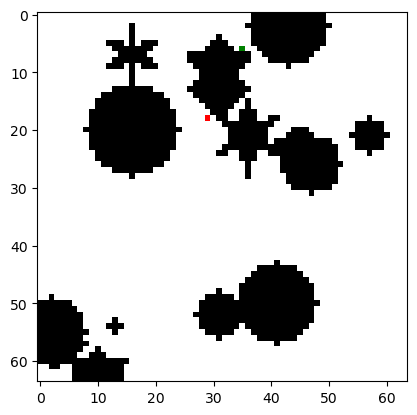

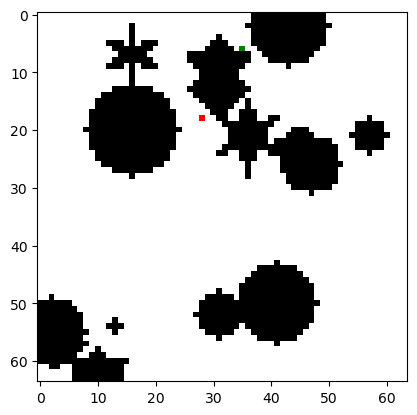

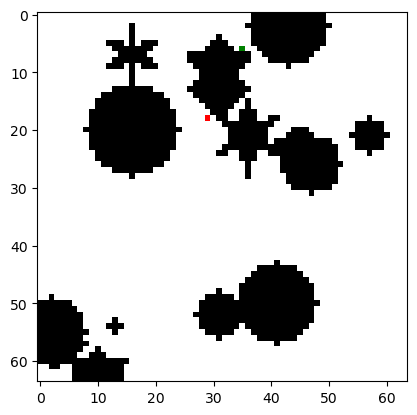

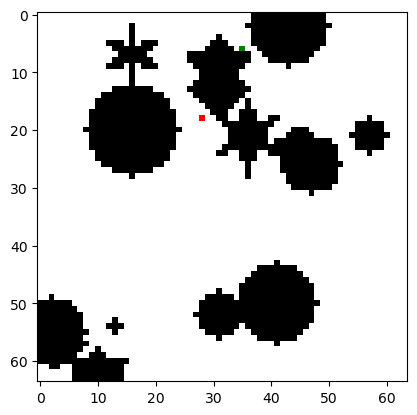

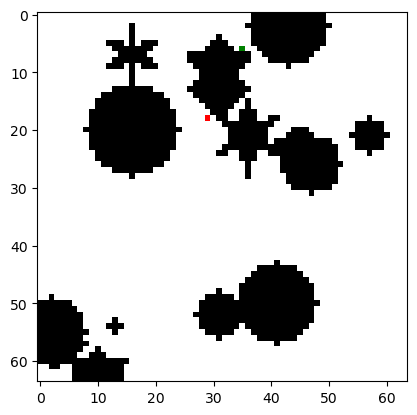

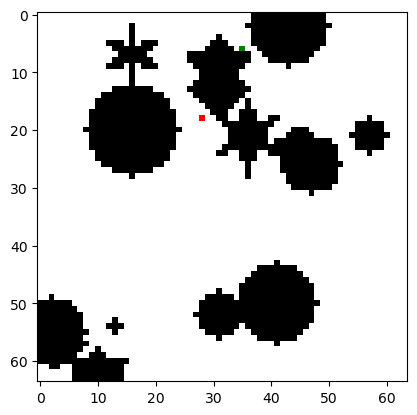

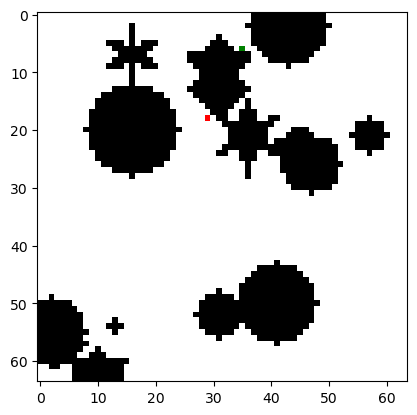

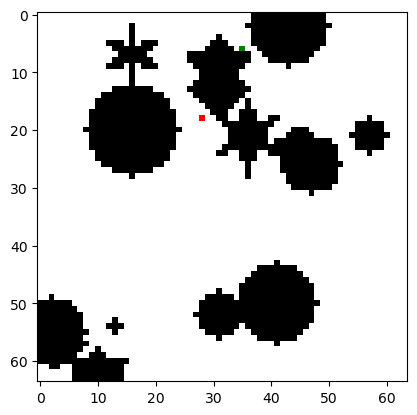

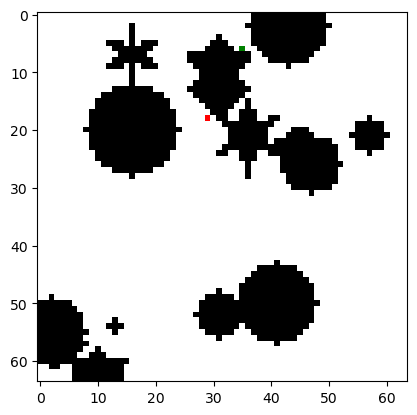

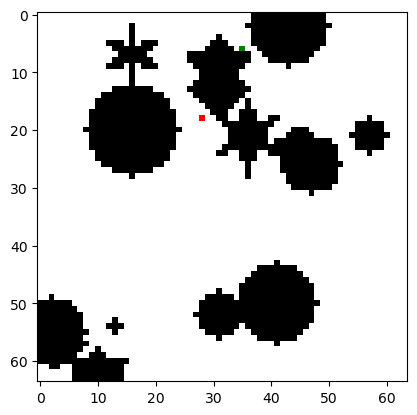

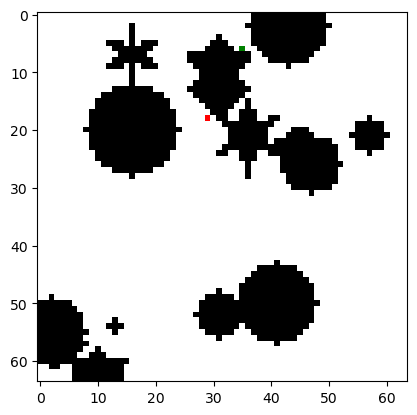

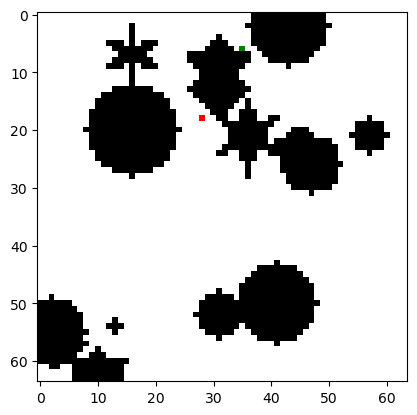

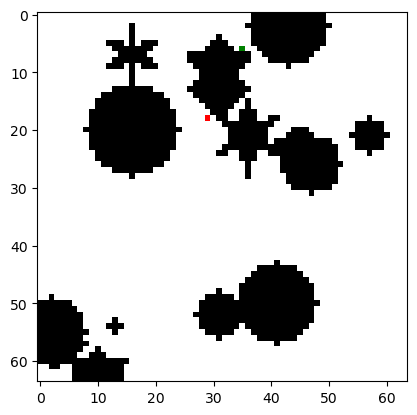

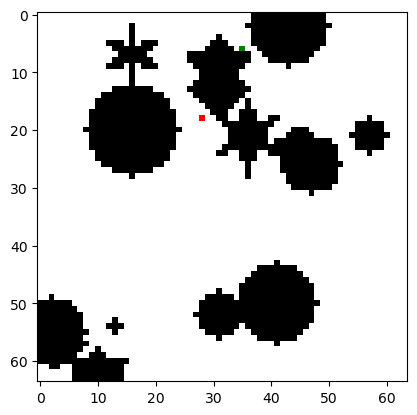

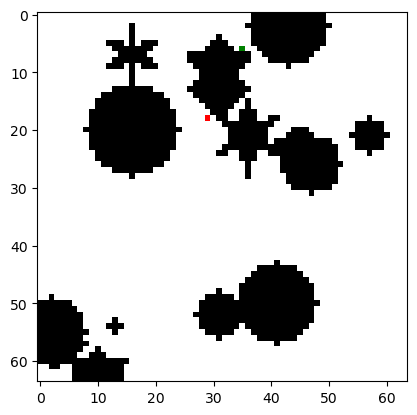

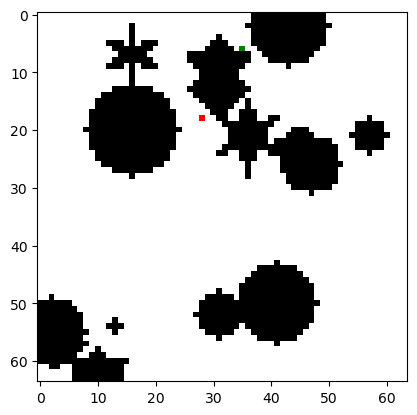

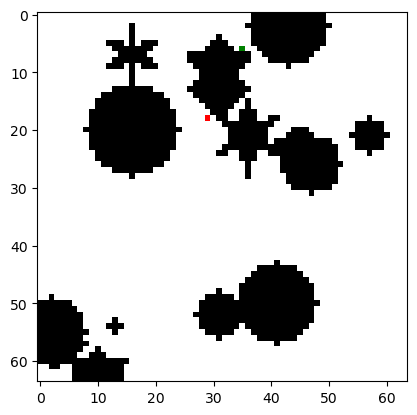

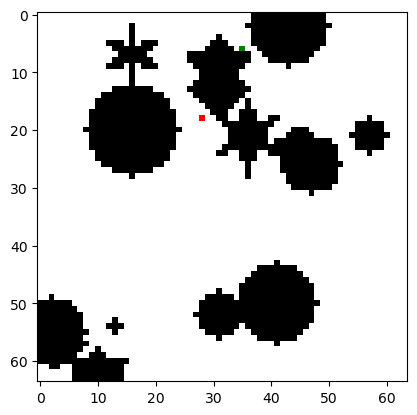

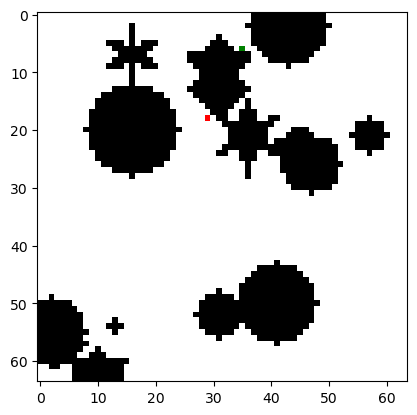

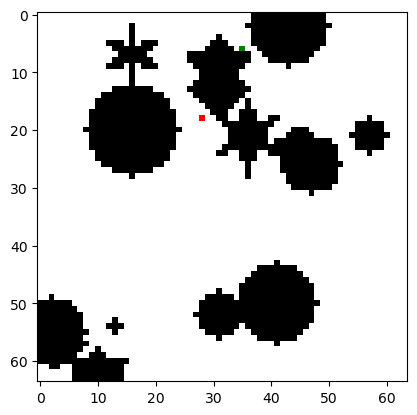

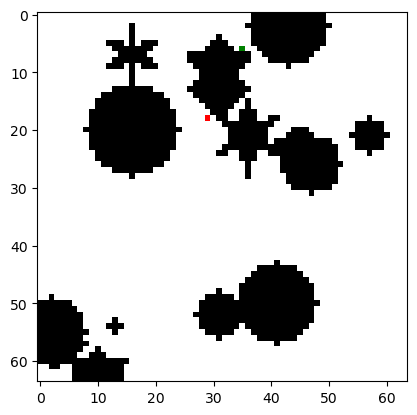

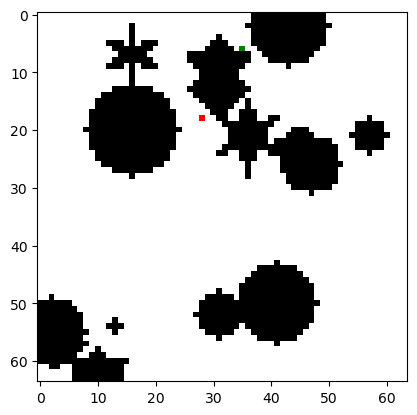

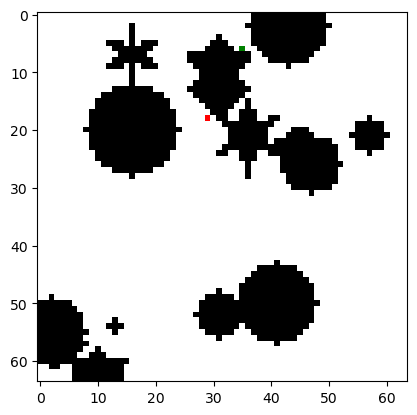

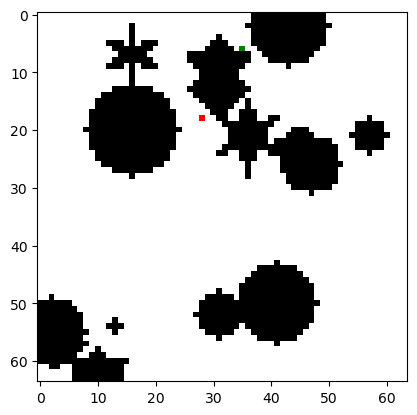

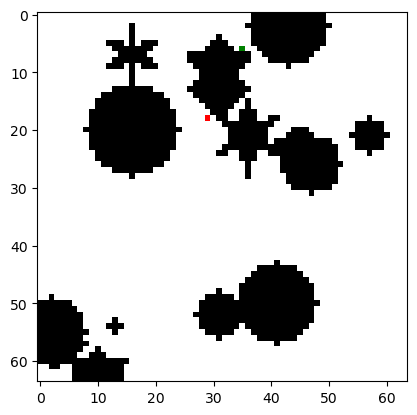

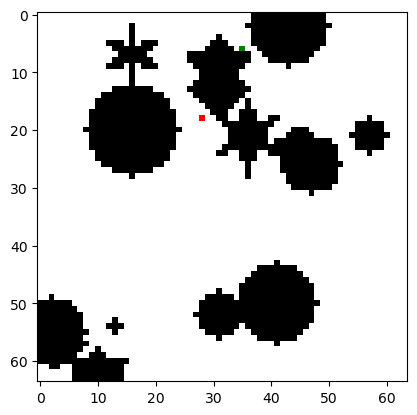

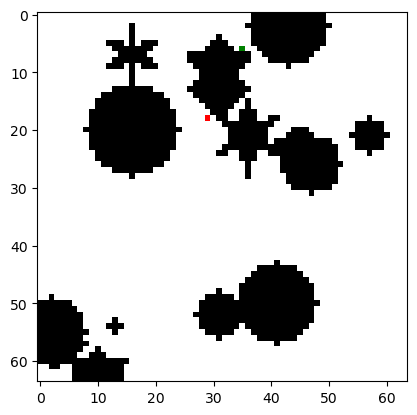

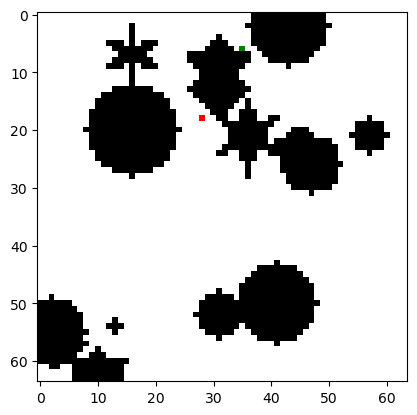

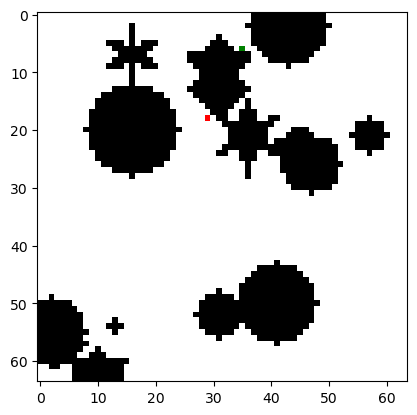

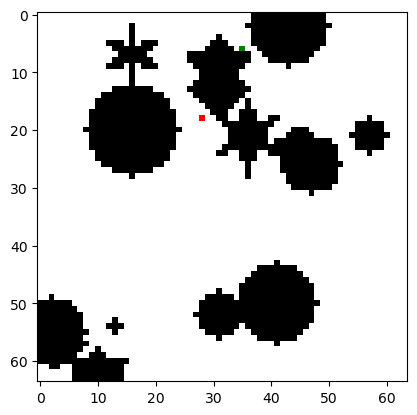

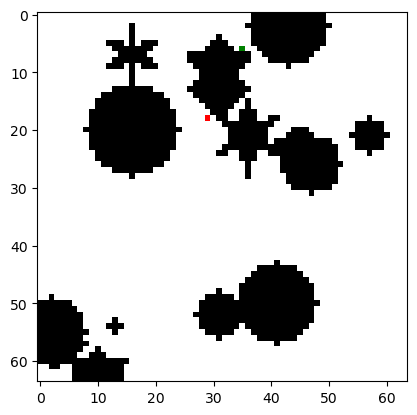

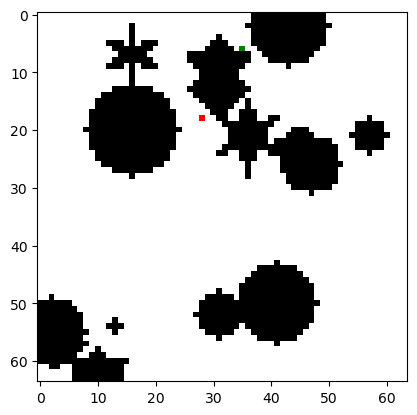

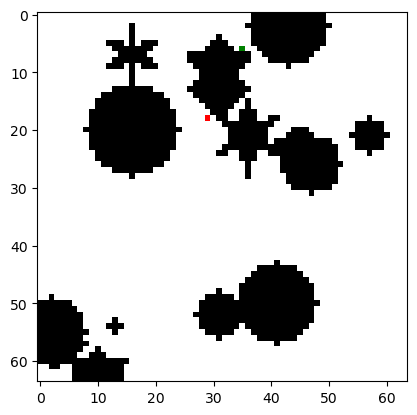

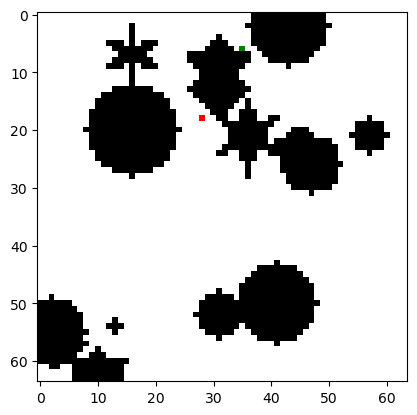

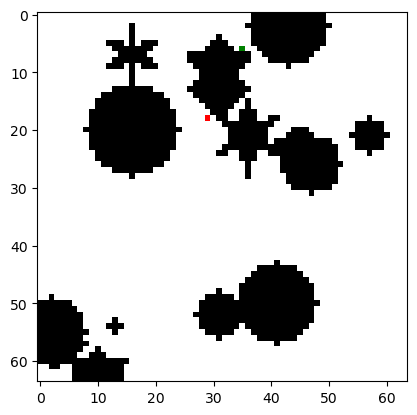

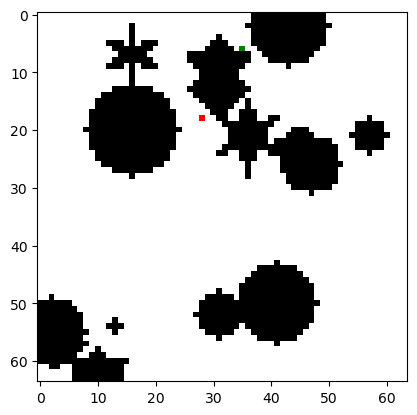

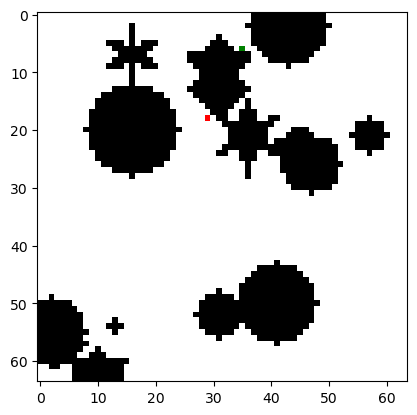

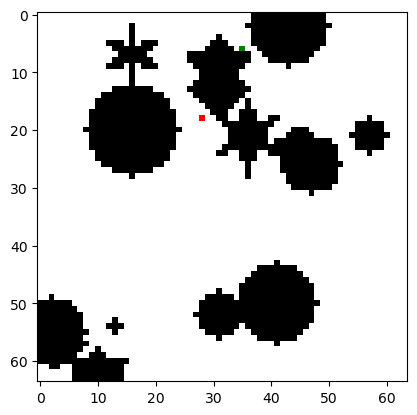

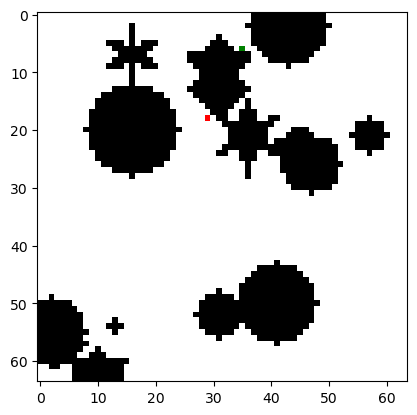

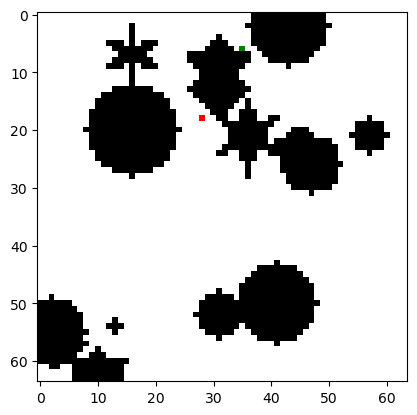

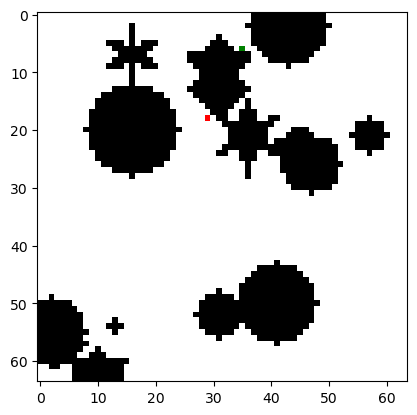

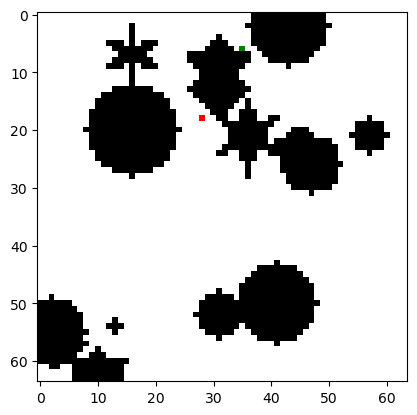

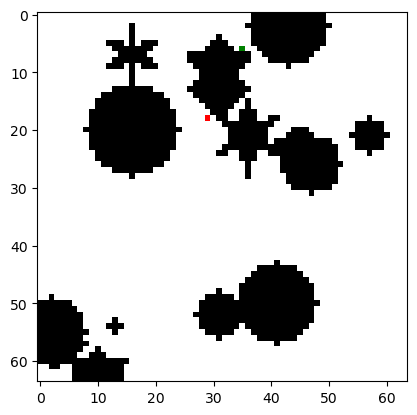

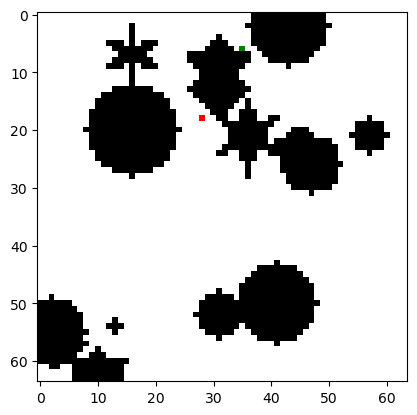

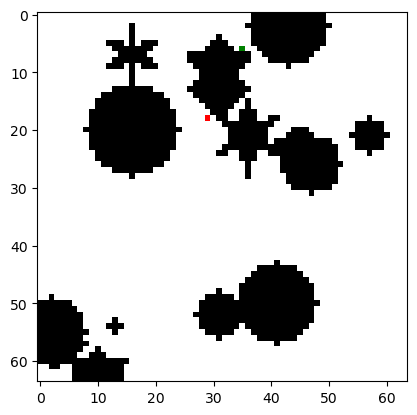

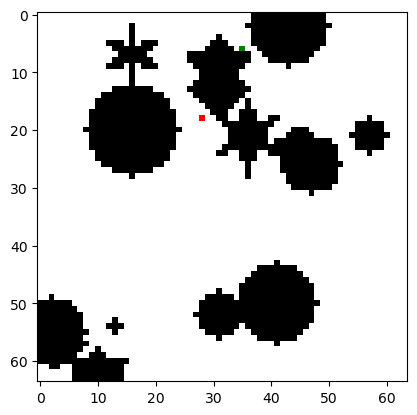

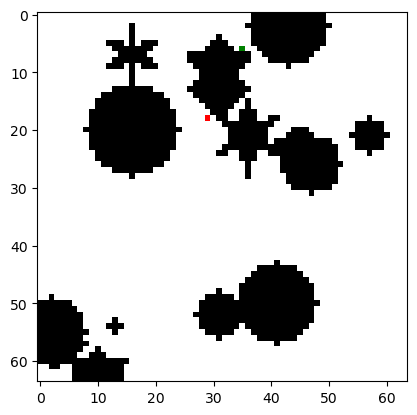

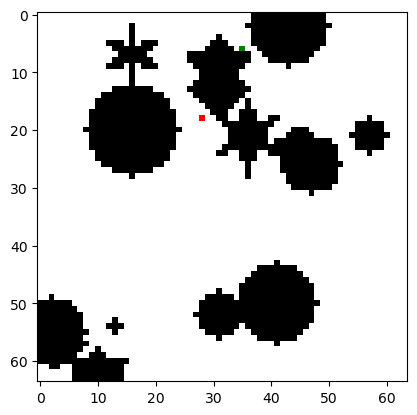

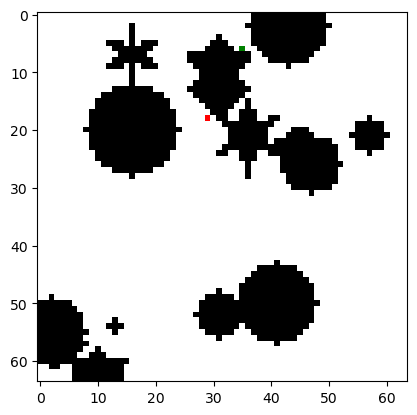

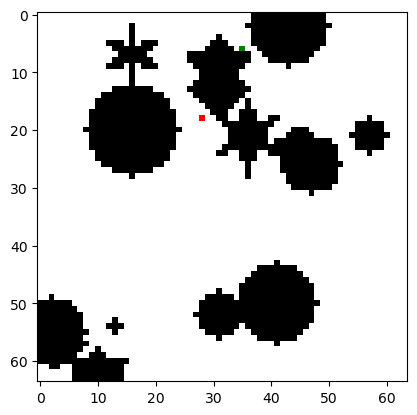

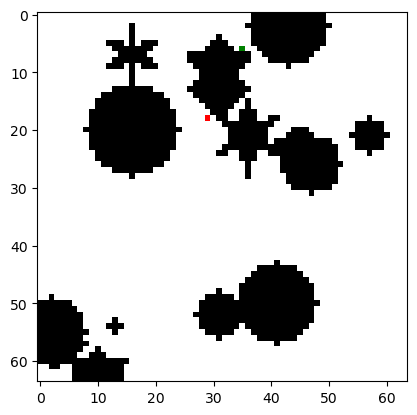

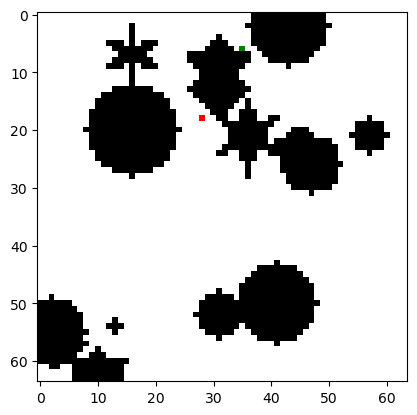

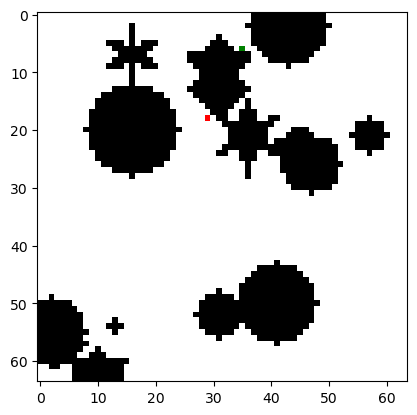

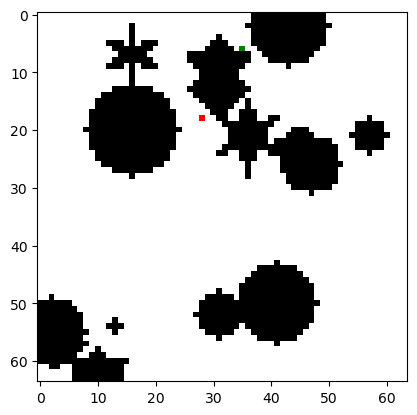

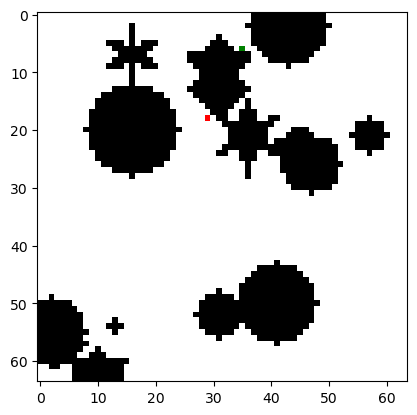

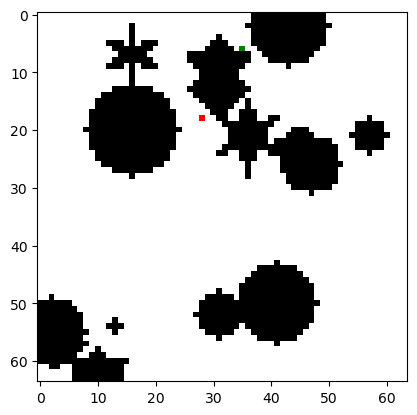

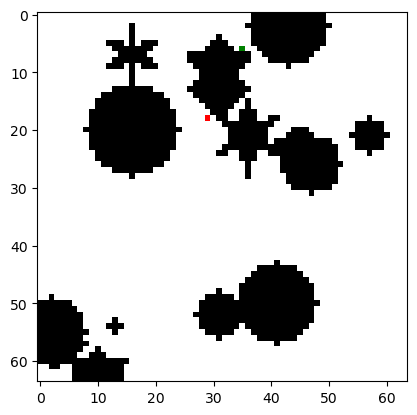

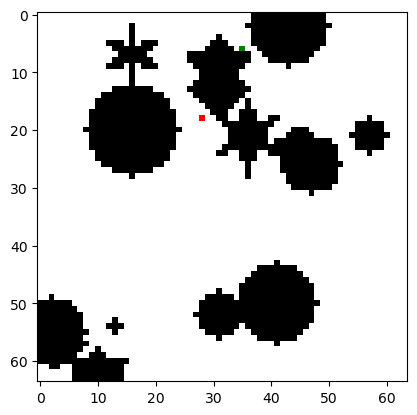

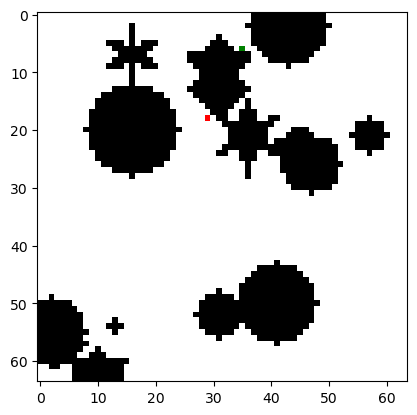

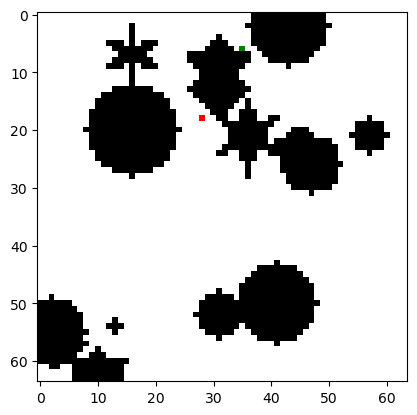

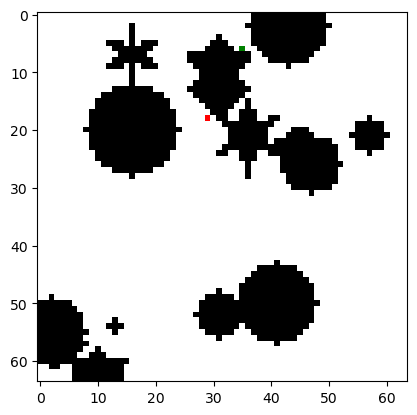

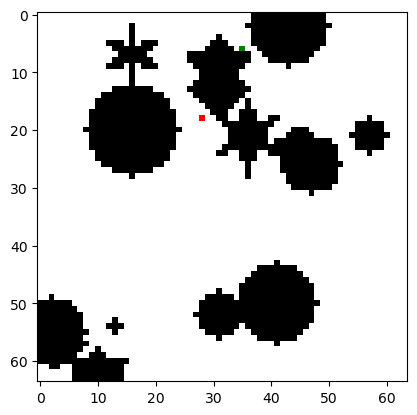

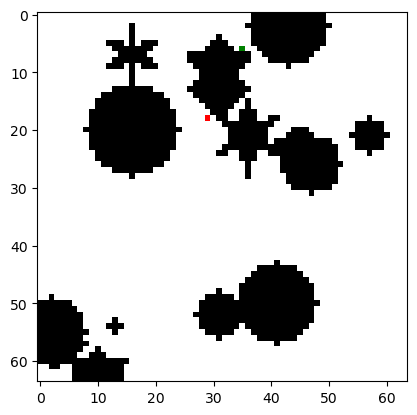

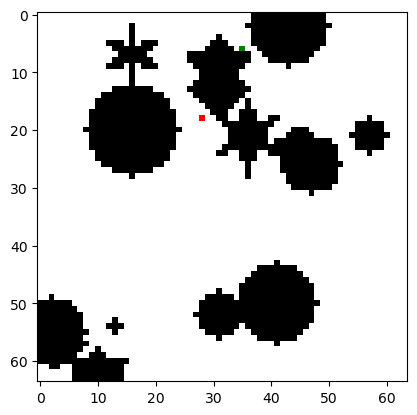

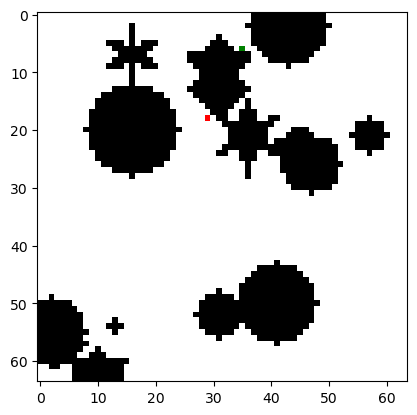

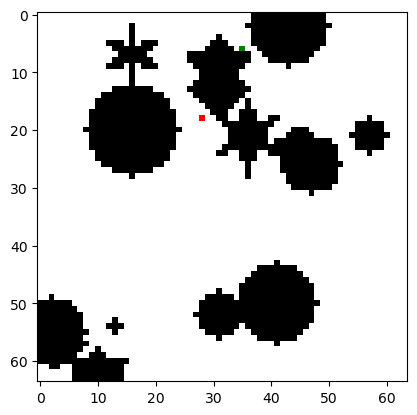

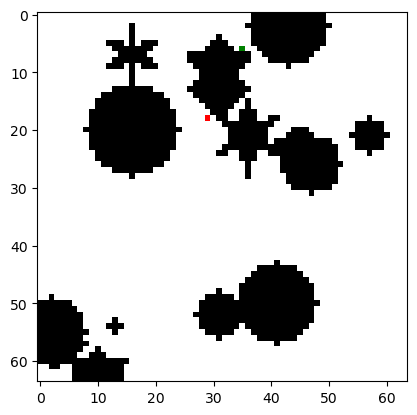

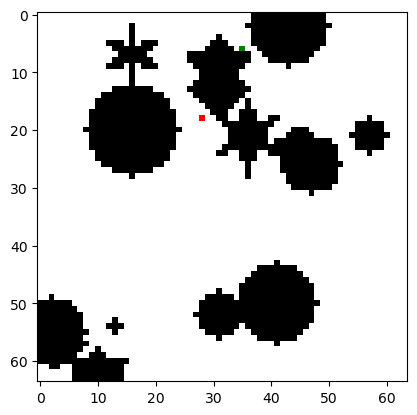

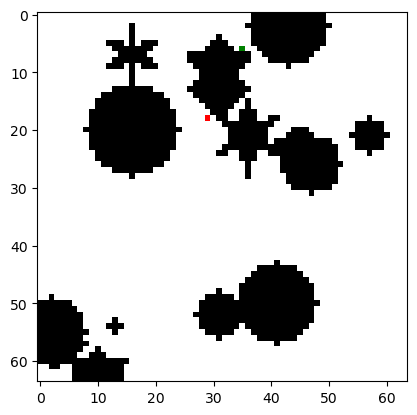

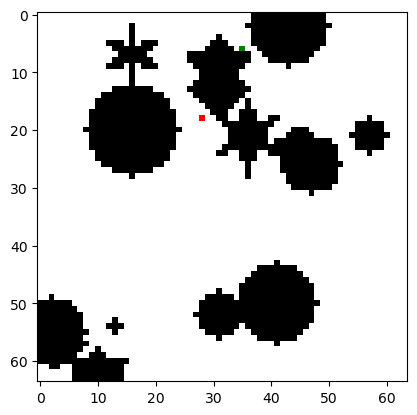

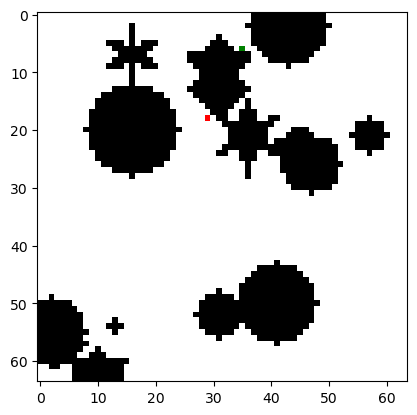

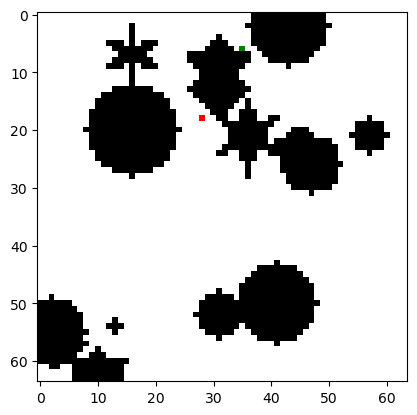

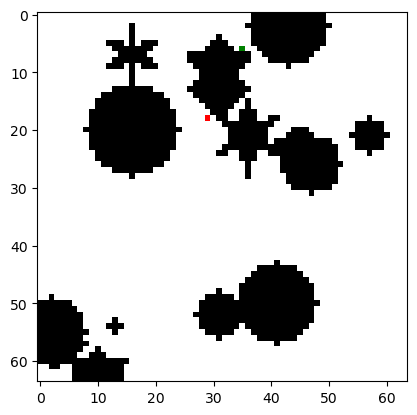

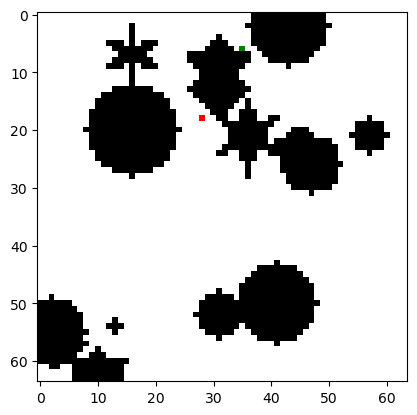

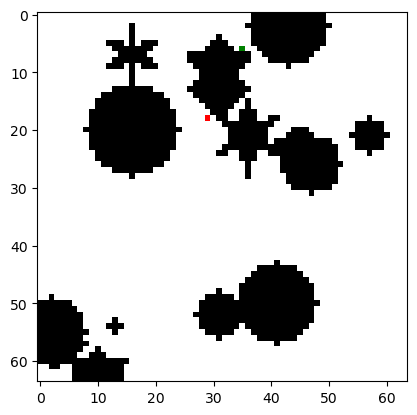

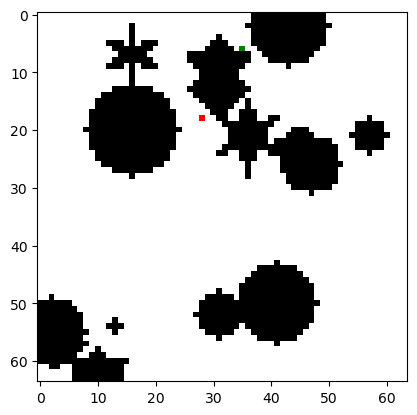

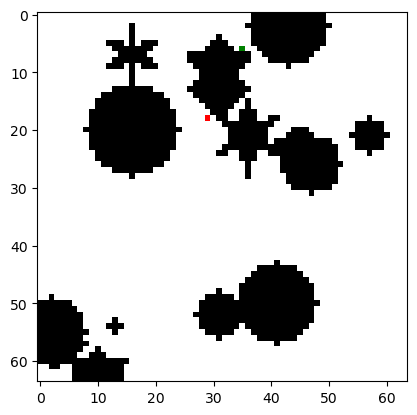

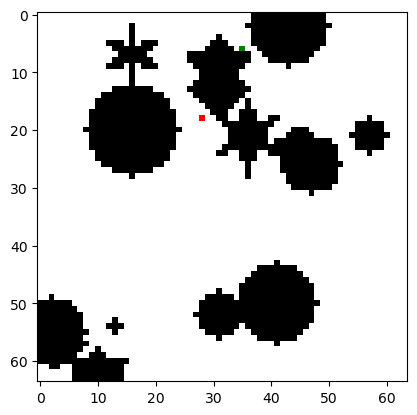

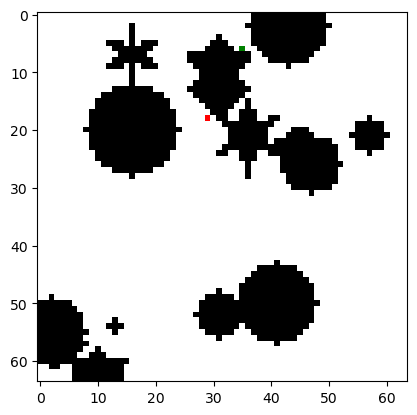

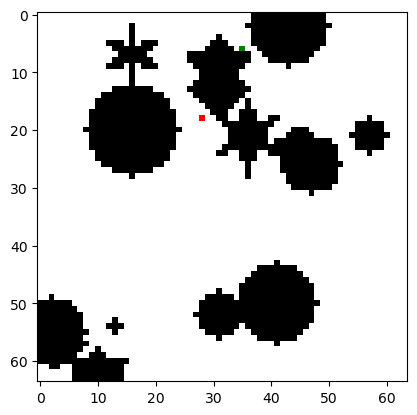

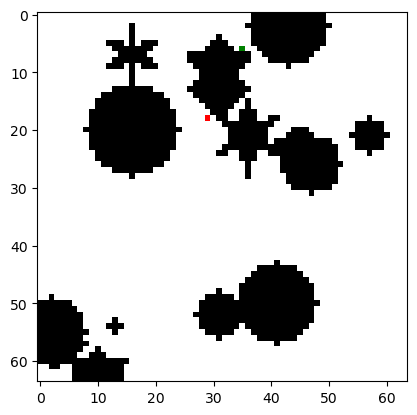

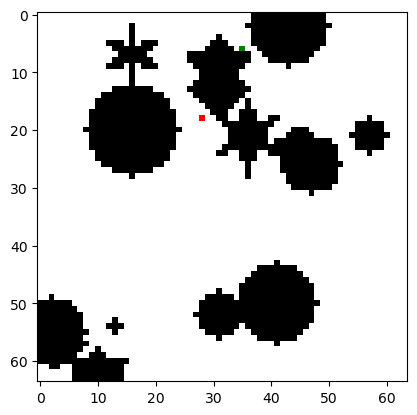

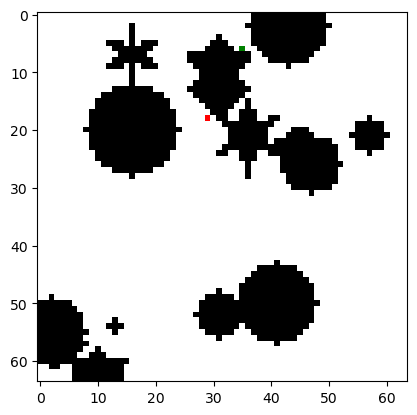

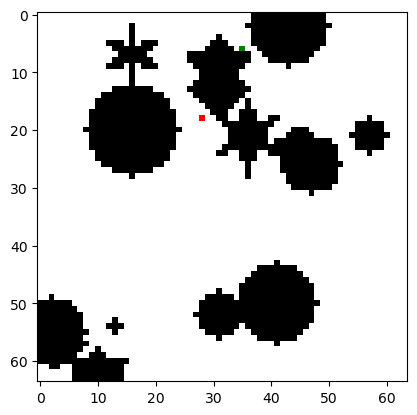

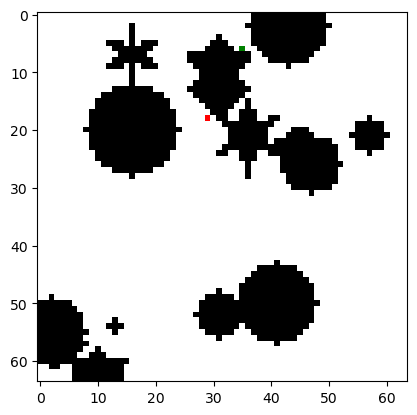

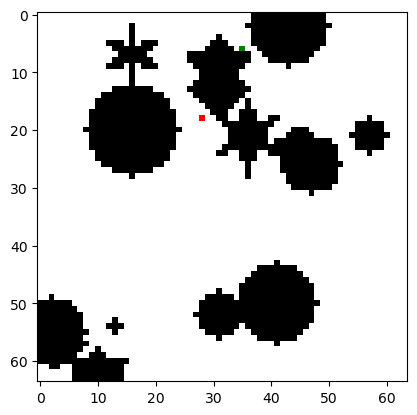

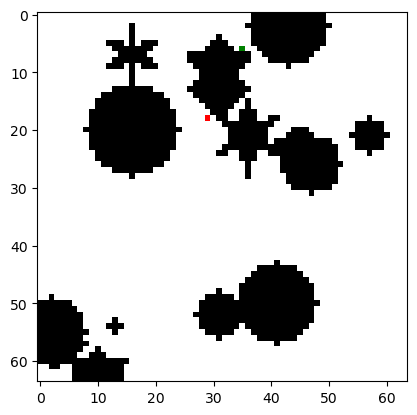

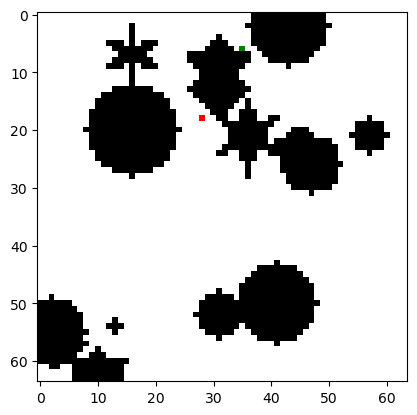

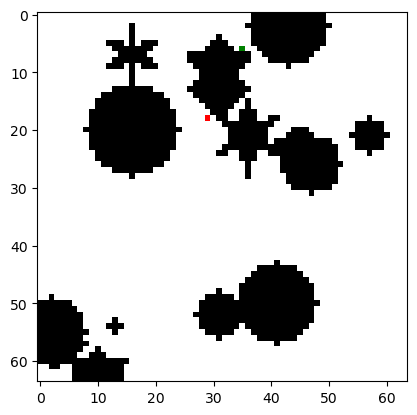

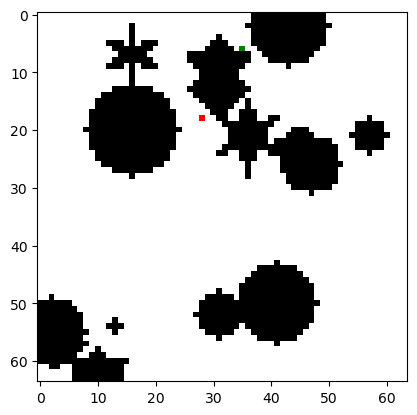

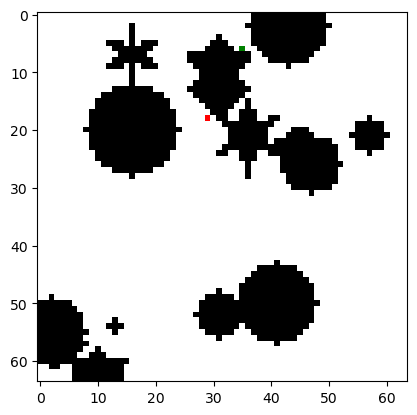

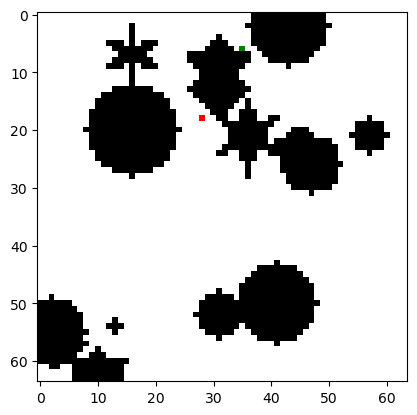

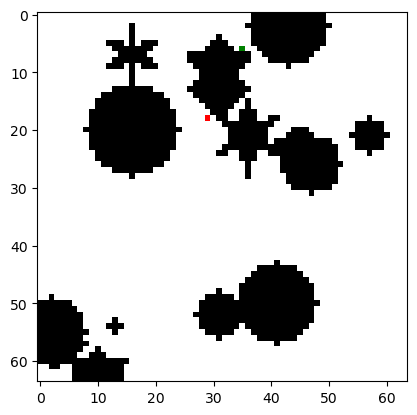

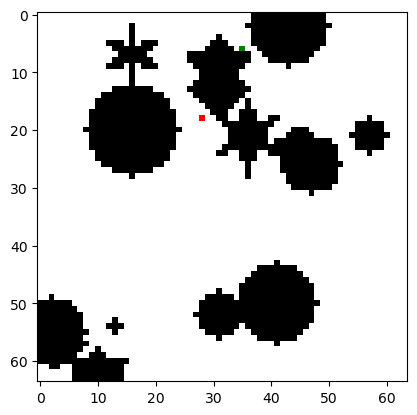

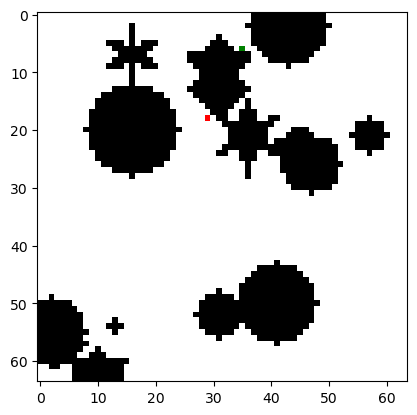

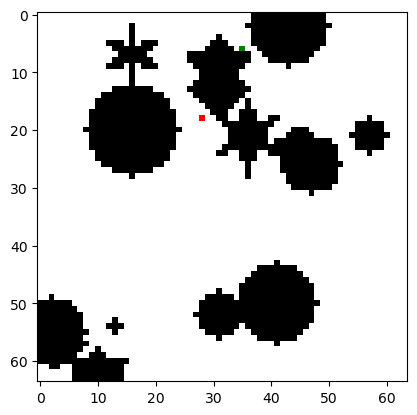

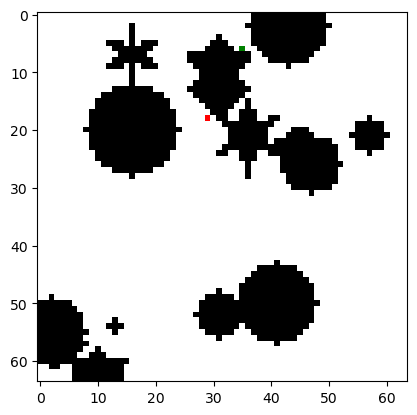

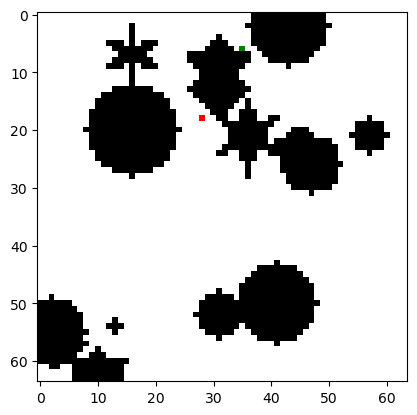

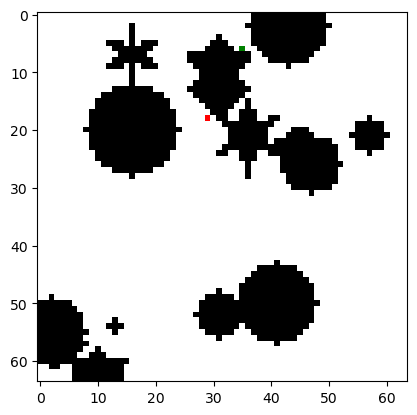

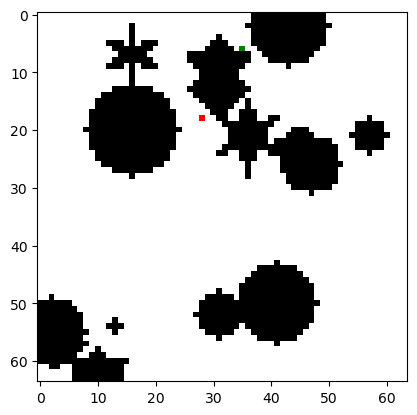

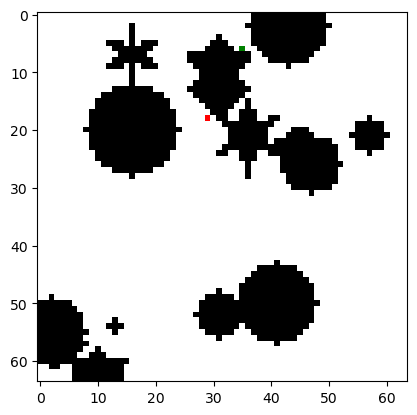

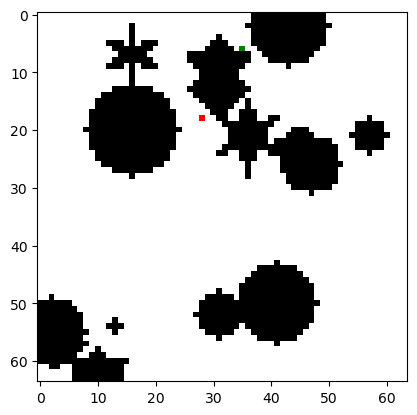

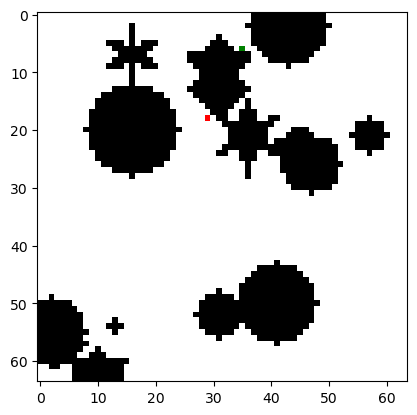

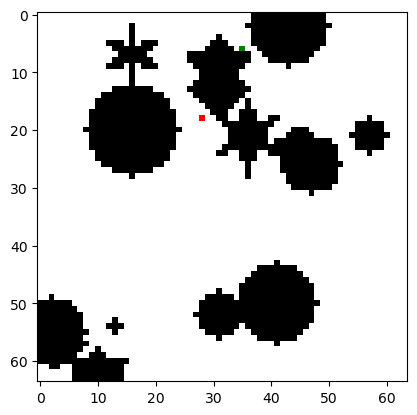

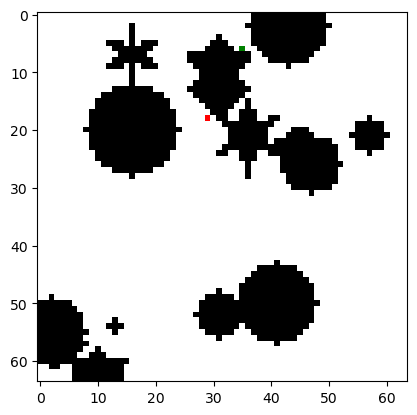

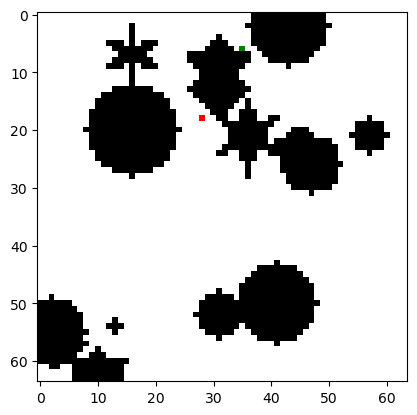

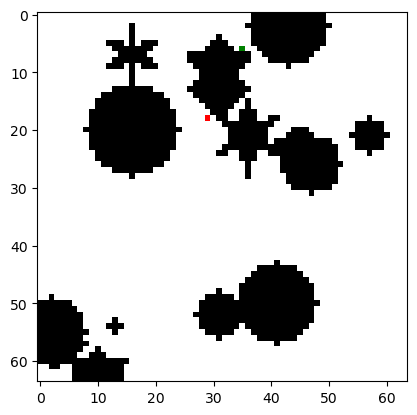

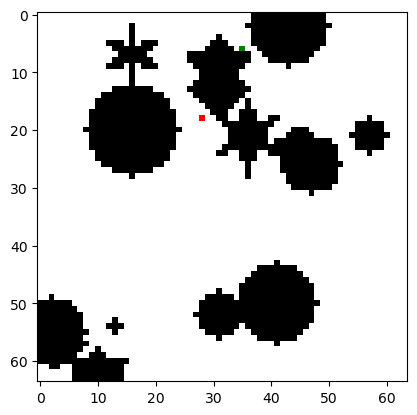

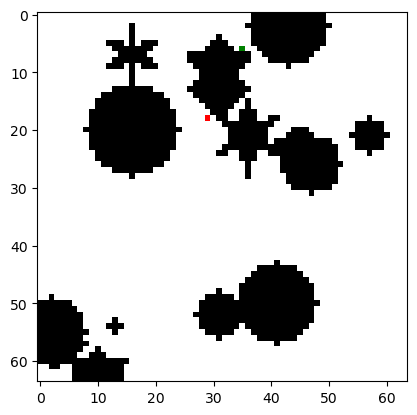

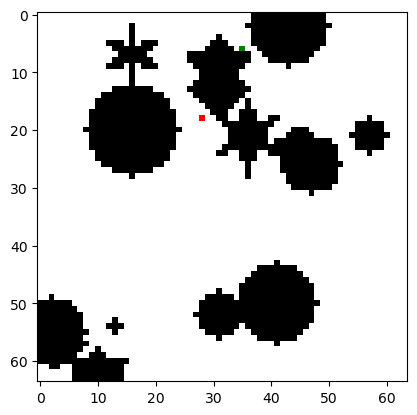

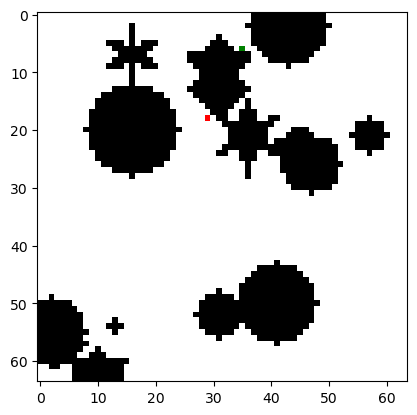

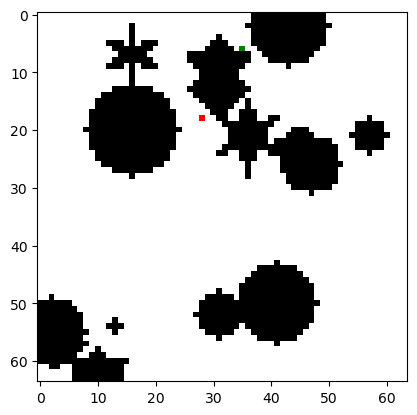

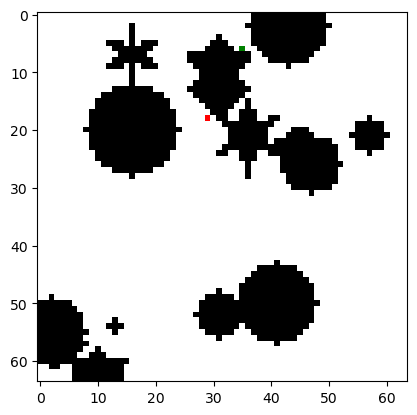

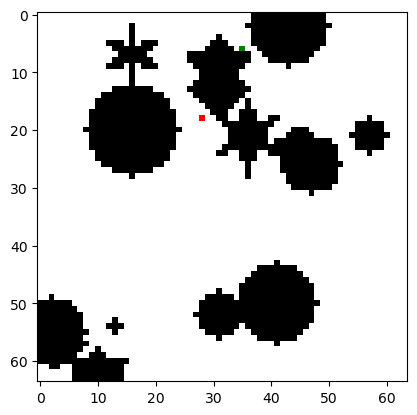

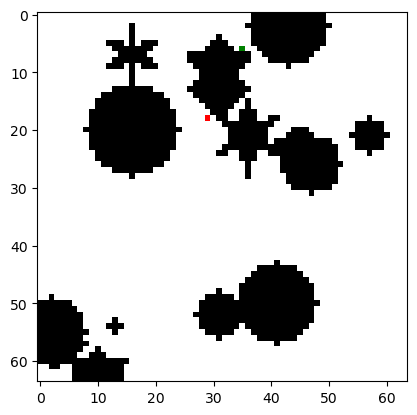

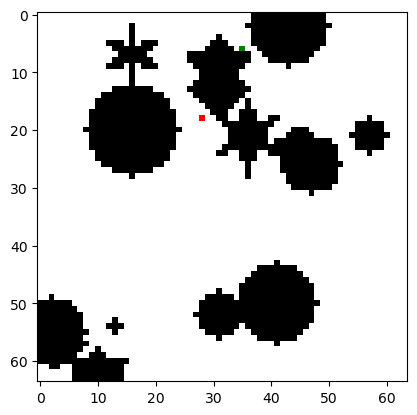

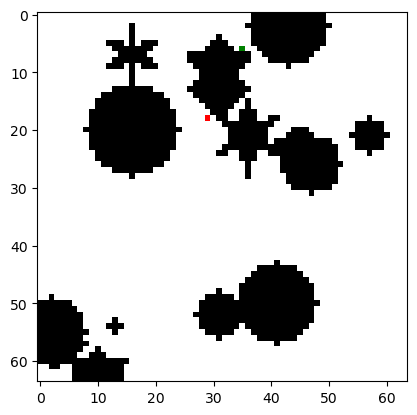

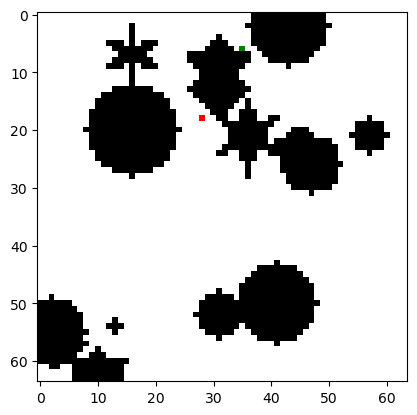

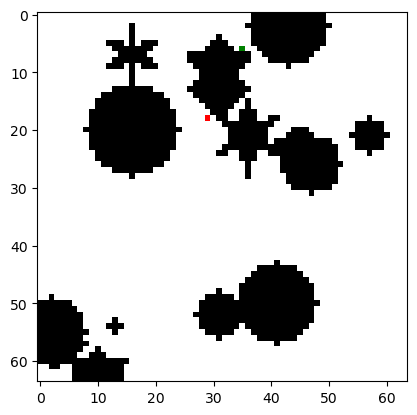

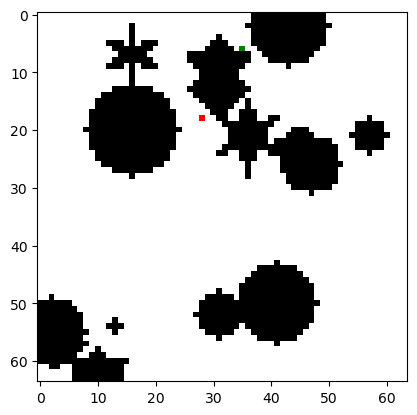

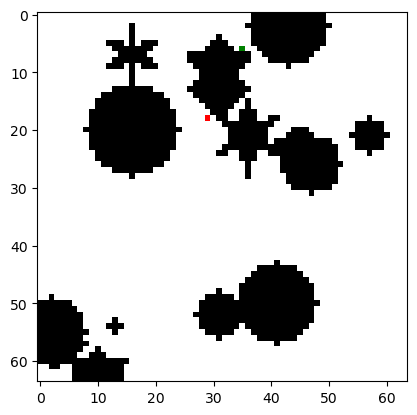

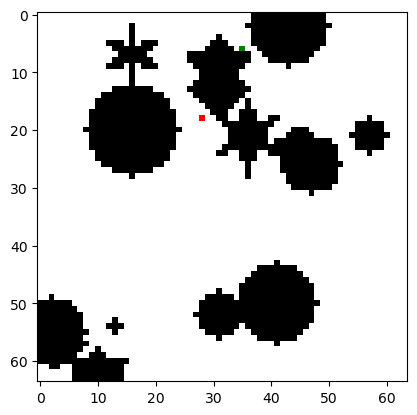

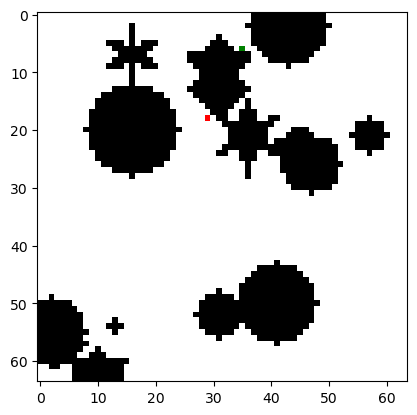

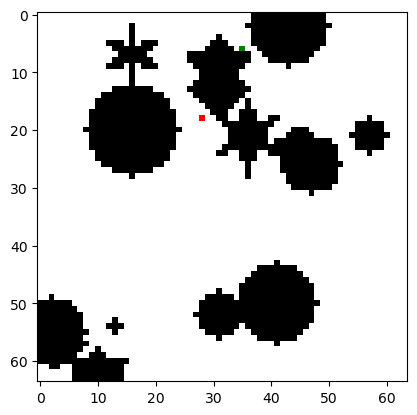

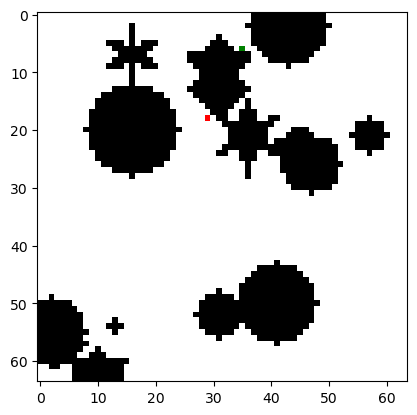

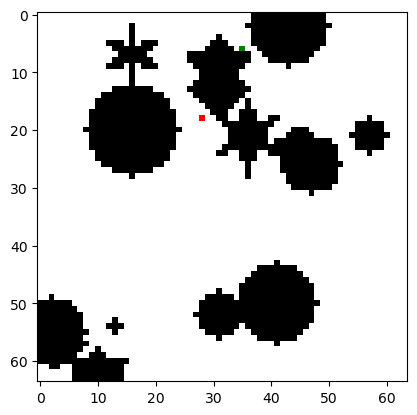

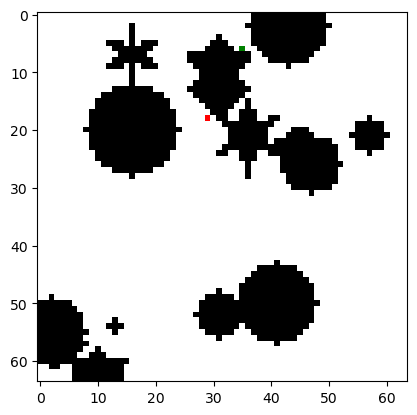

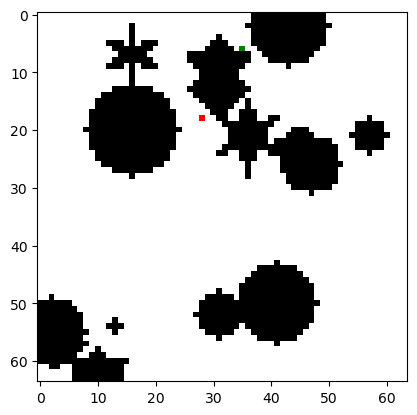

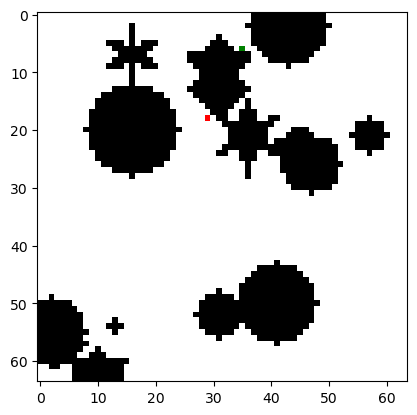

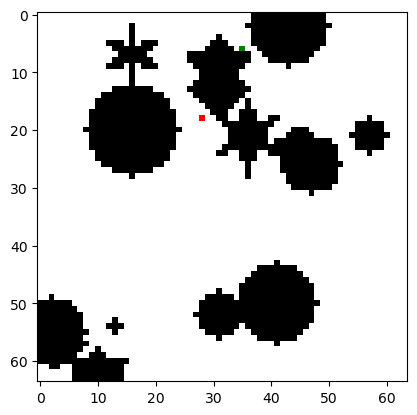

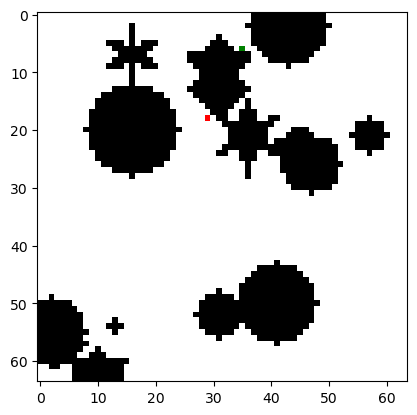

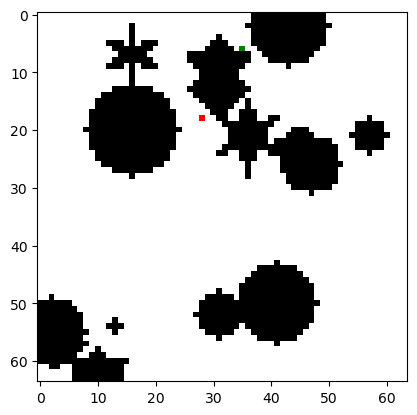

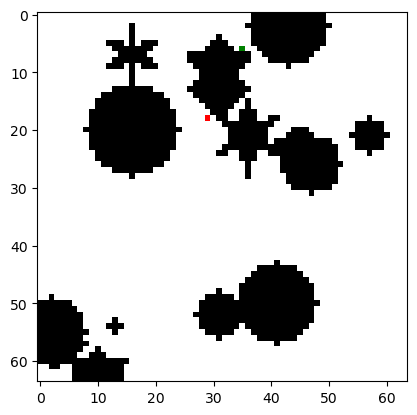

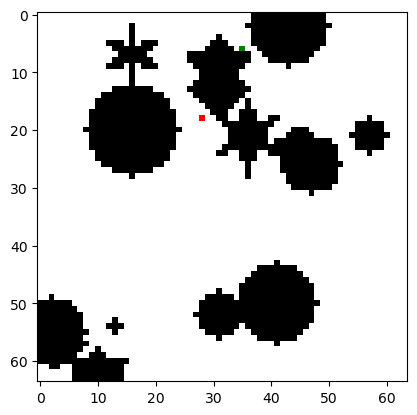

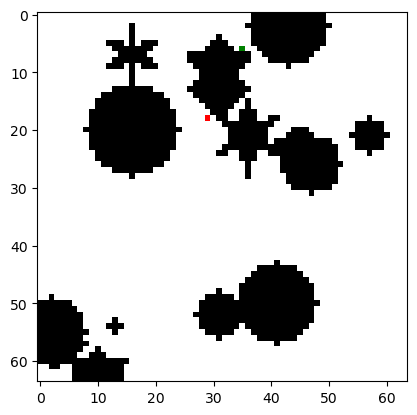

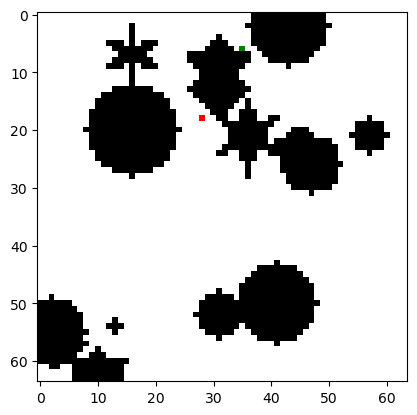

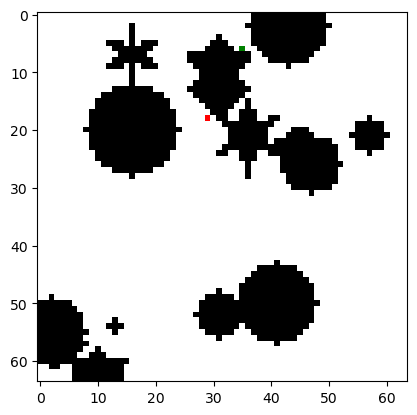

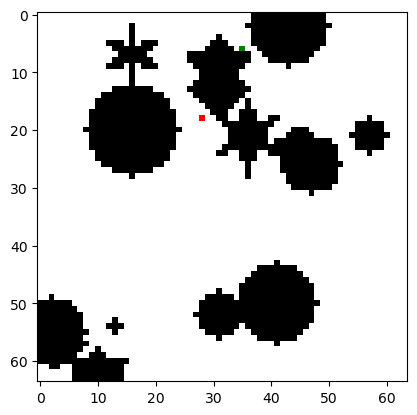

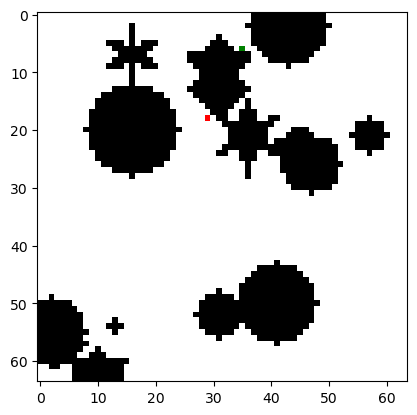

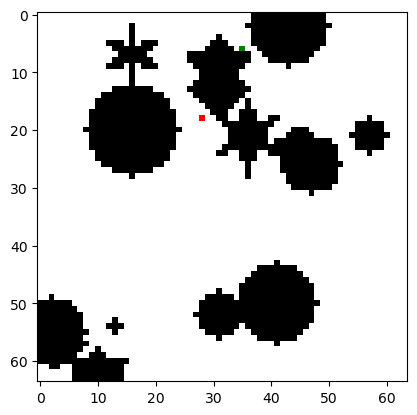

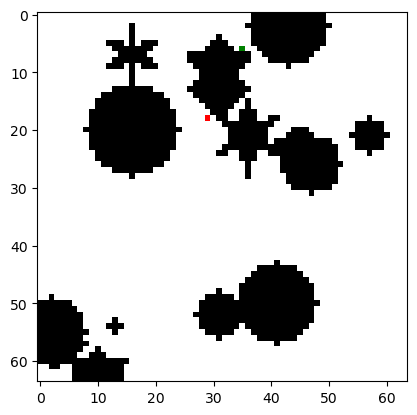

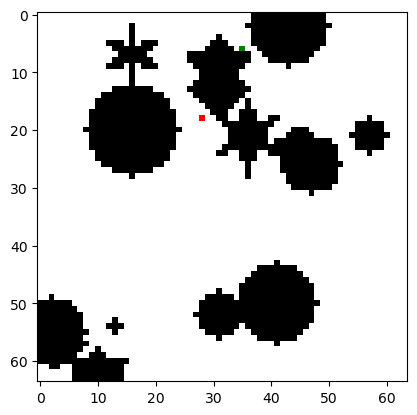

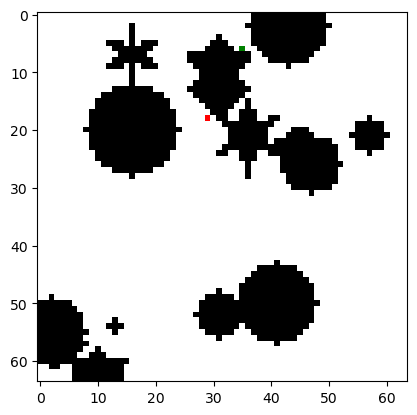

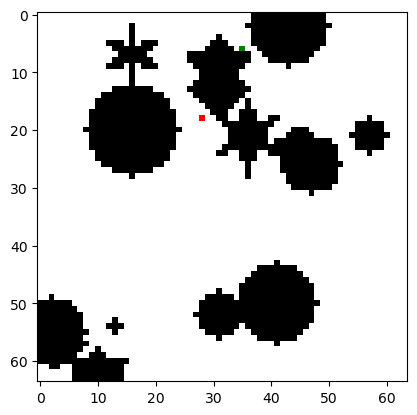

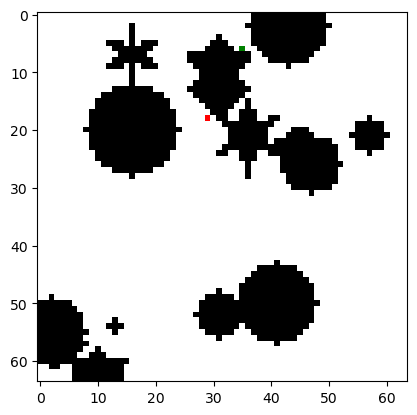

In [52]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "green"   # 3
])

env_size = (64, 64)
start_x = np.random.choice(range(env_size[0]))
start_y = np.random.choice(range(env_size[0]))
start = (start_y, start_x)

max_steps = 1000
goal_x = np.random.choice(range(env_size[0]))
goal_y = np.random.choice(range(env_size[0]))
goal = (goal_y, goal_x)

# start = (0,63)
# goal = (63,0)
environments = np.load('../environment_generation/environments/environments_64_15_1000_1.npy')
grid_list = [grid for grid in environments]

grid = grid_list[20]

env = GridEnvCNN(grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)


images = []
plt.imshow(np.sum(obs['image'] * np.array([1,3,2]).reshape(3, 1, 1), axis=0), cmap=cmap)
plt.show()
model = PPO.load("models/ppo_custom_cnn_64x64_lvl_3", env=env, device='cuda')

for i in range(200):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    
    plt.imshow(np.sum(obs['image'] * np.array([1,3,2]).reshape(3, 1, 1), axis=0), cmap=cmap)
    plt.show()
    if terminated or truncated:
        break

## Level 5

In [ ]:
environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]
env_size = (64,64)

env = DummyVecEnv([make_env(grid_list) for _ in range(512)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_3", env=env, device='cuda')
model.learn(total_timesteps=6_000_000, progress_bar=True, tb_log_name="Level 5")

Output()

1280


In [13]:
model.save("models/ppo_custom_cnn_64x64_lvl_5")

In [14]:
environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_5", env=env, device='cuda')

test_agent(model, grid_list, goal_region= (64,64), n=100)

1280


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]

terminated:  59.0 % with an average of 34.440677966101696 steps and a maximum of 79


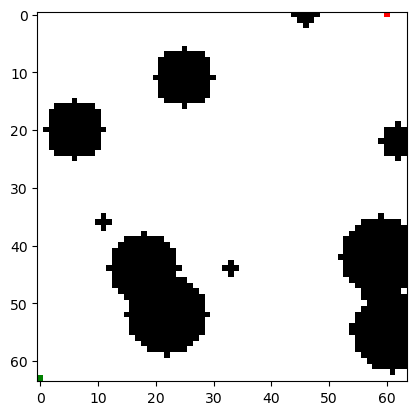

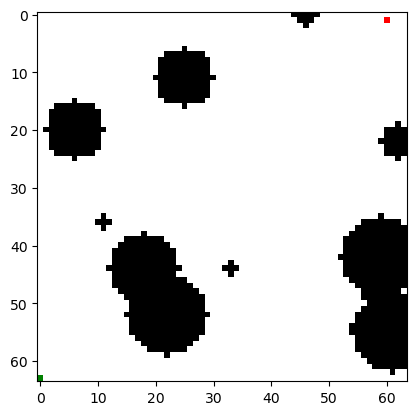

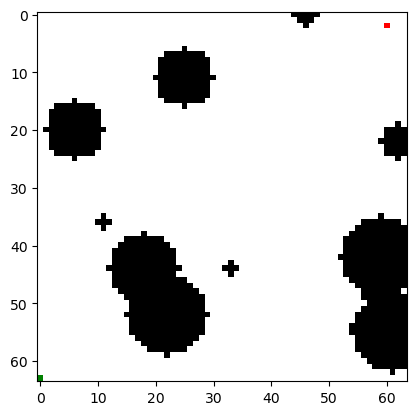

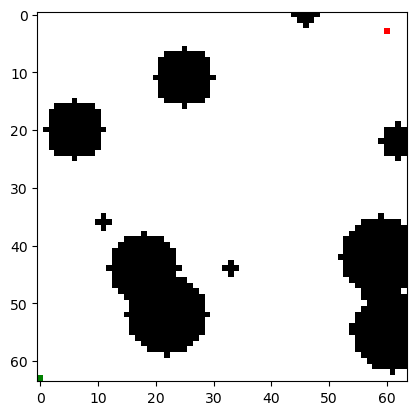

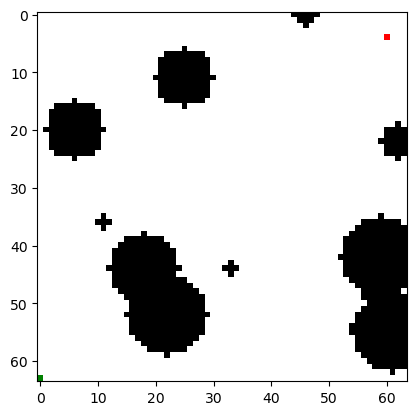

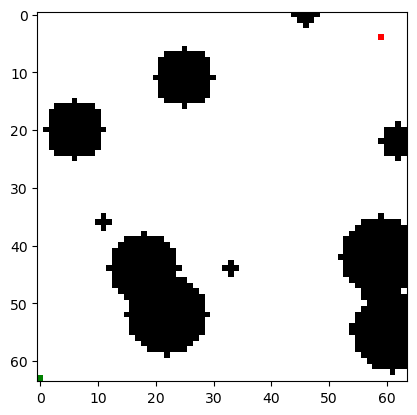

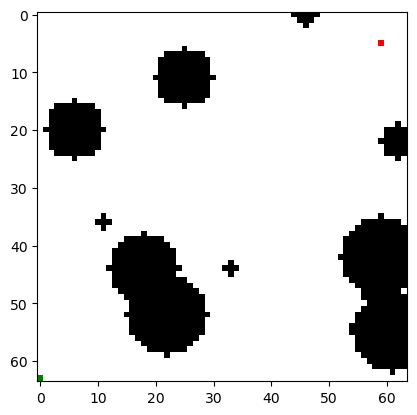

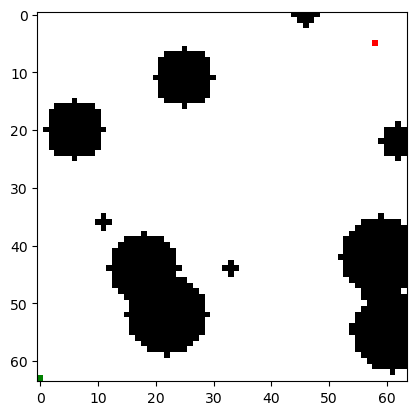

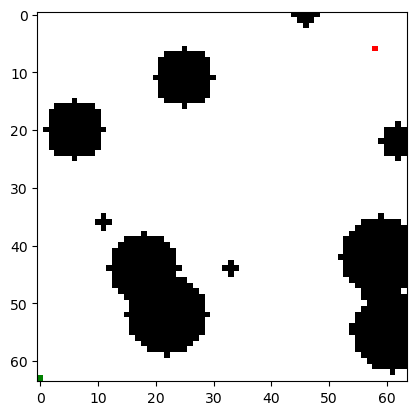

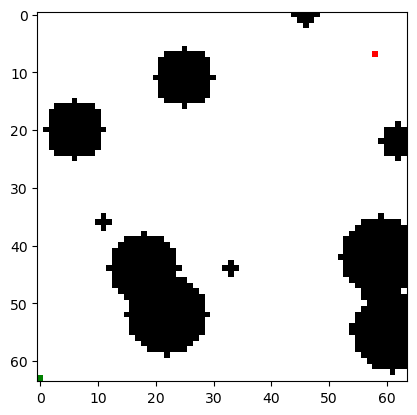

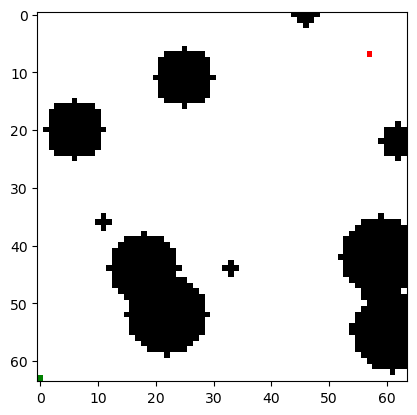

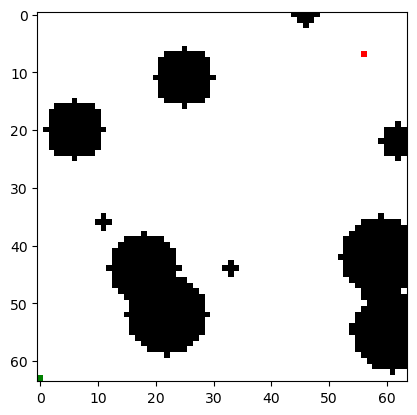

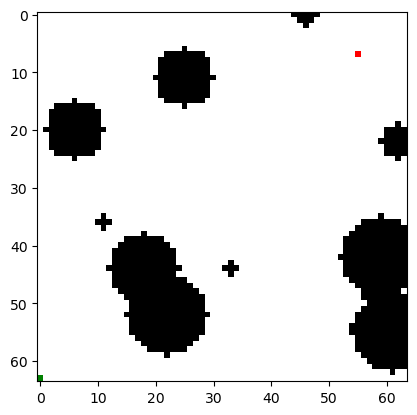

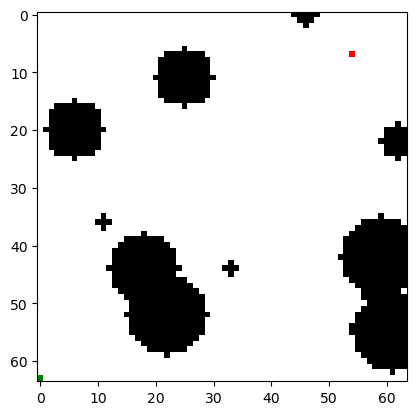

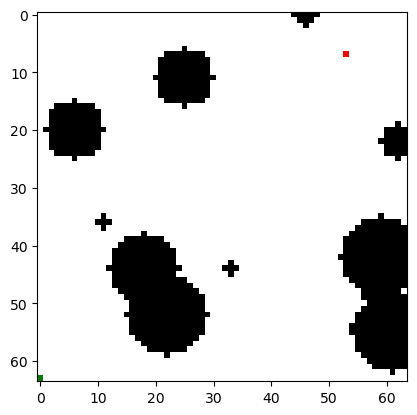

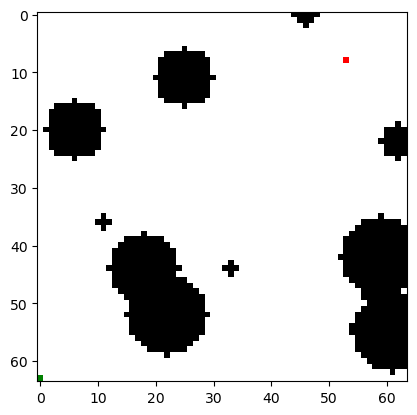

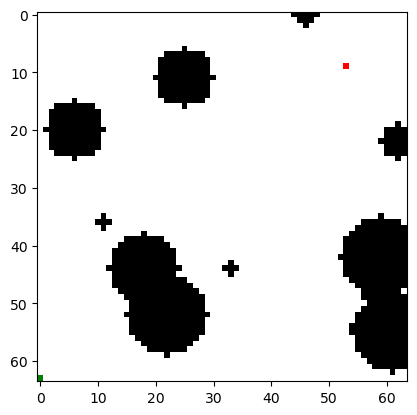

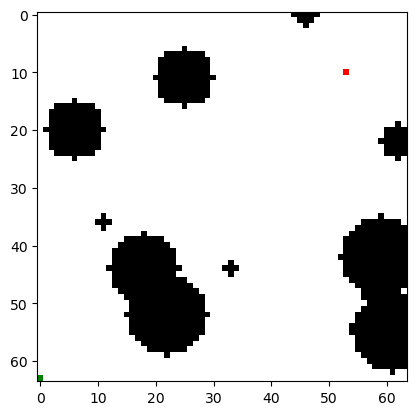

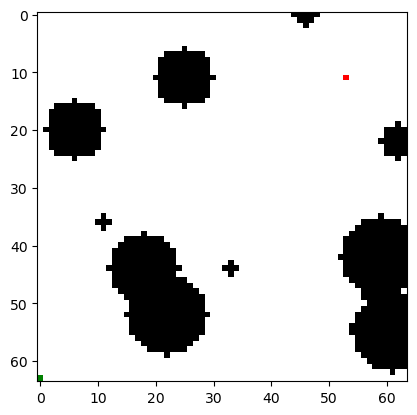

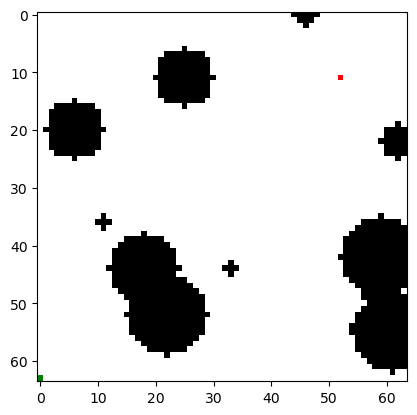

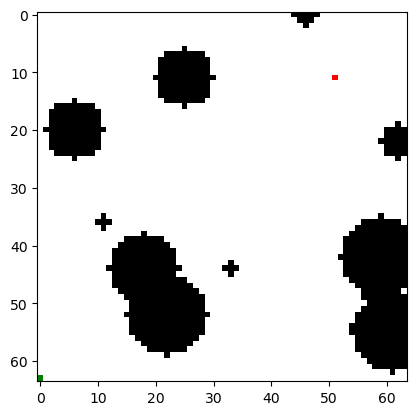

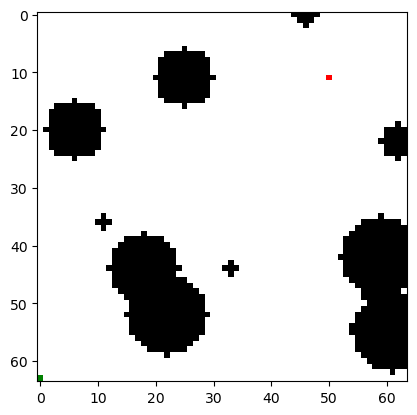

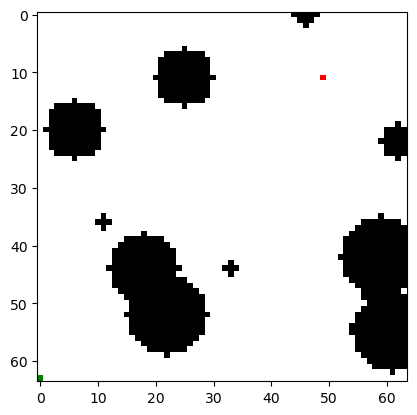

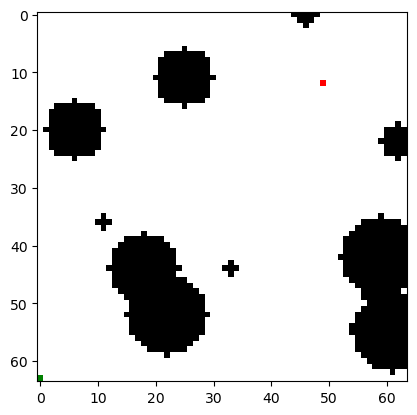

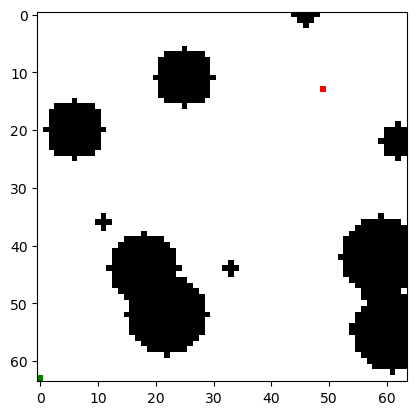

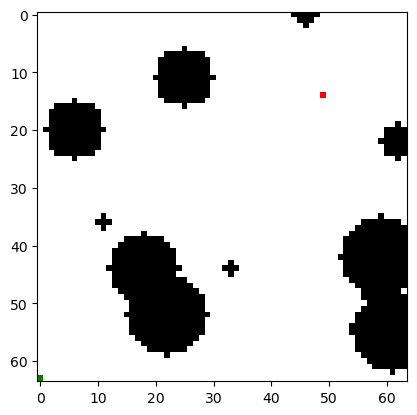

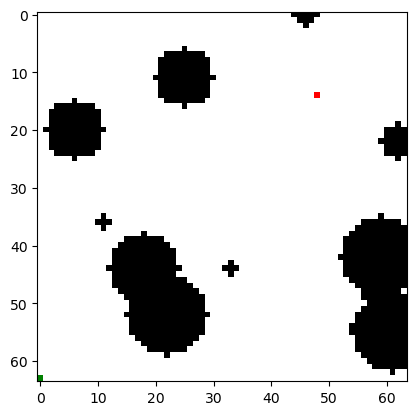

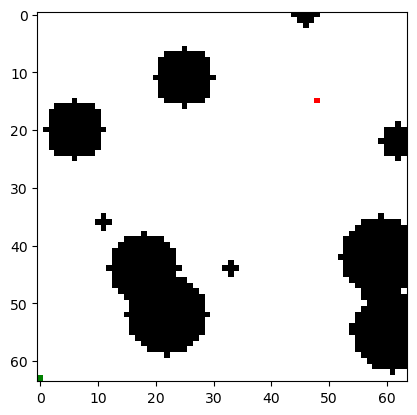

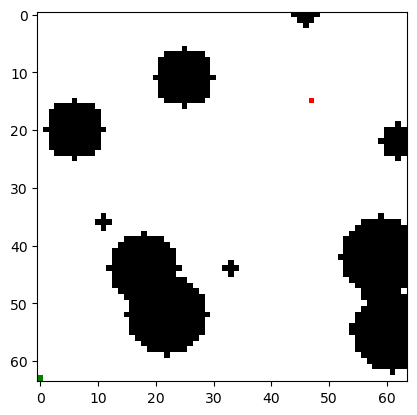

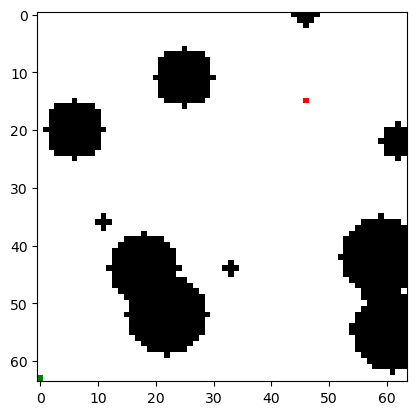

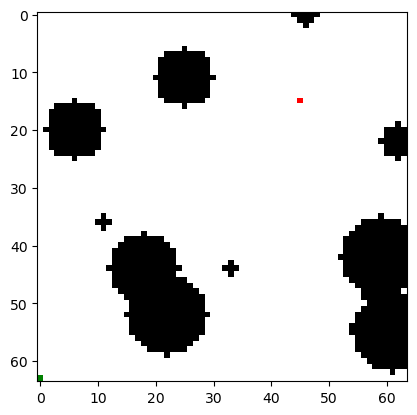

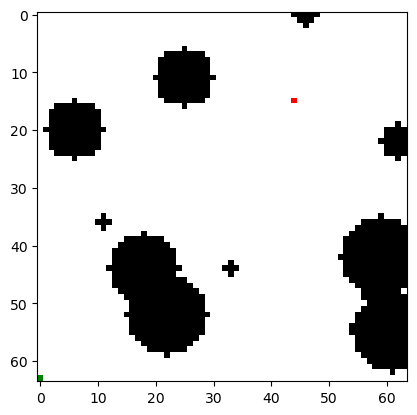

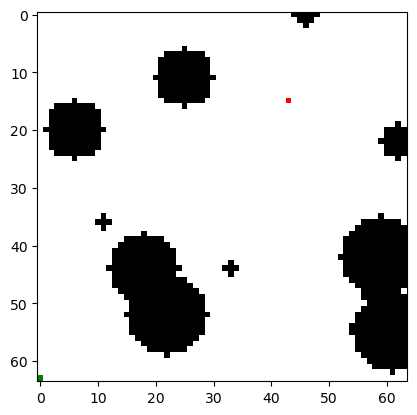

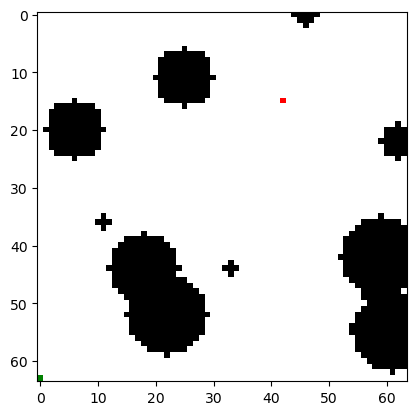

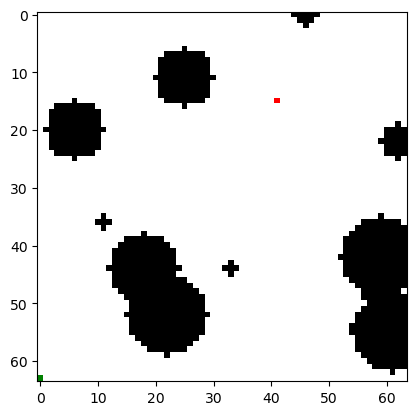

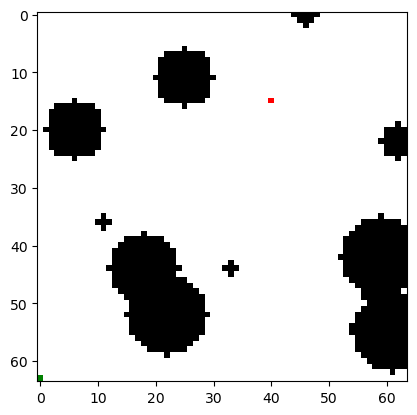

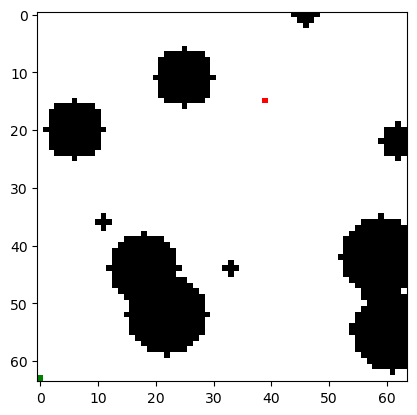

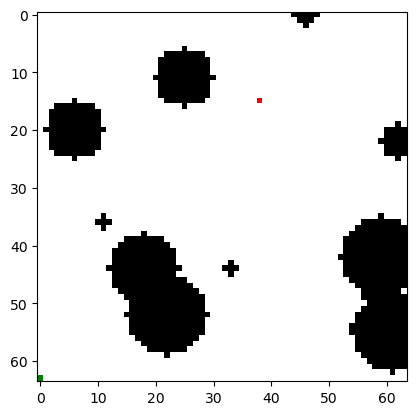

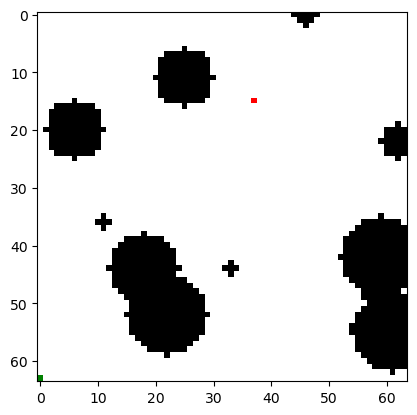

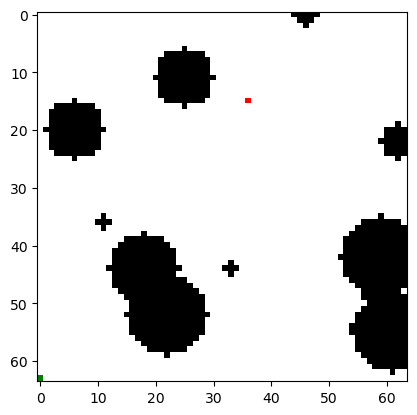

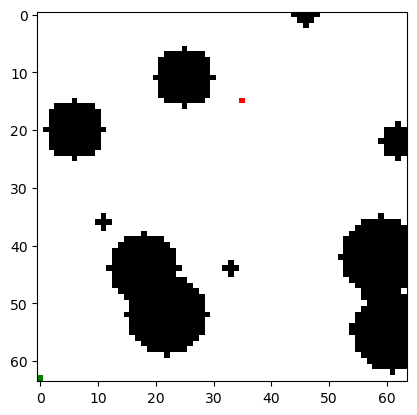

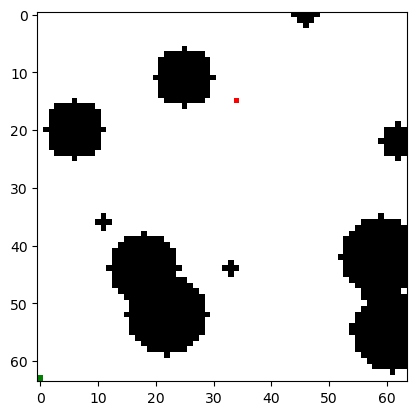

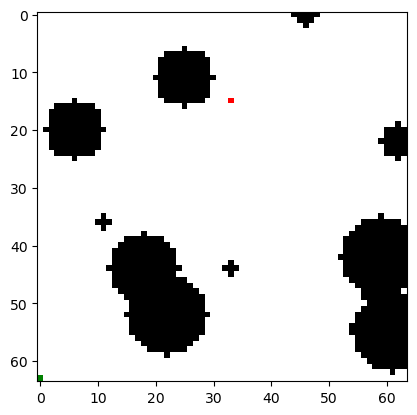

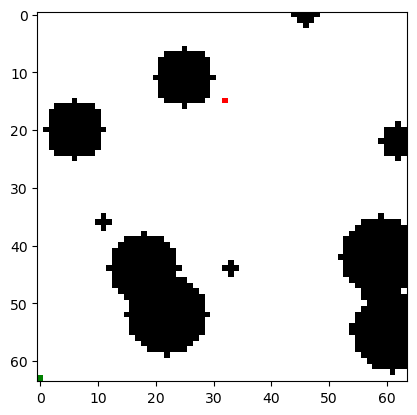

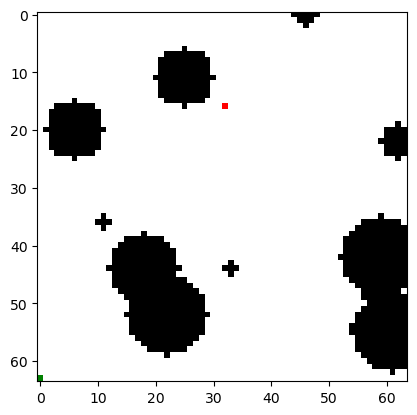

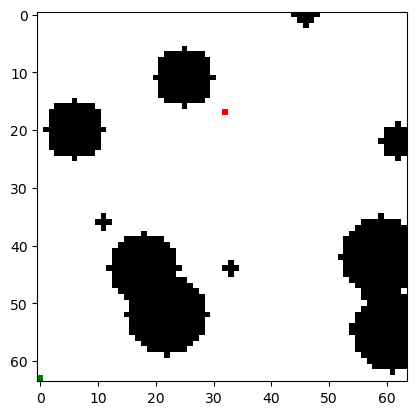

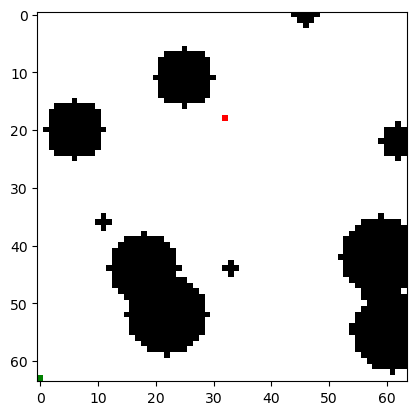

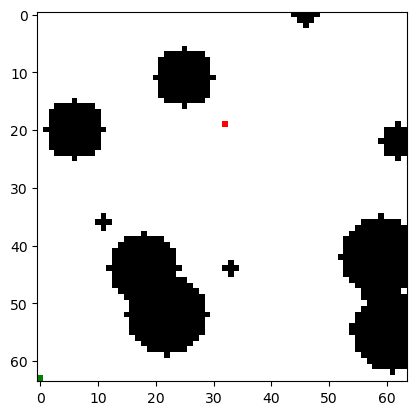

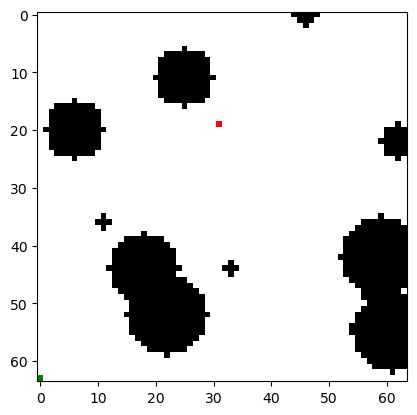

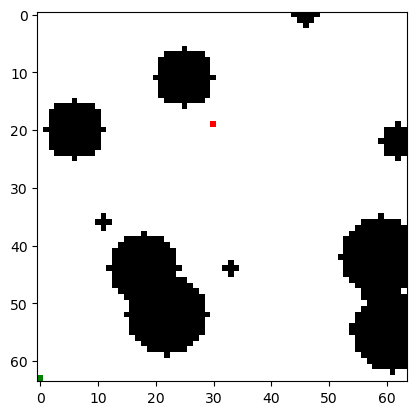

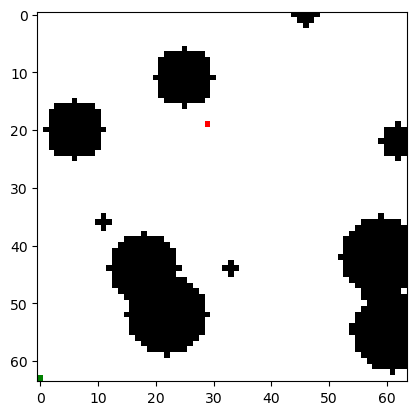

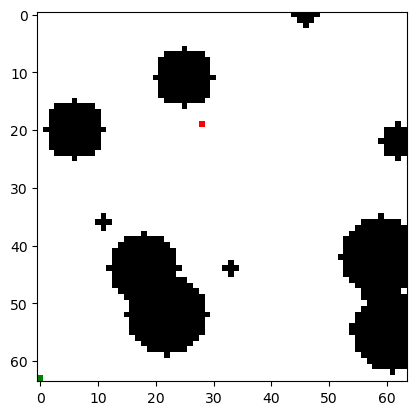

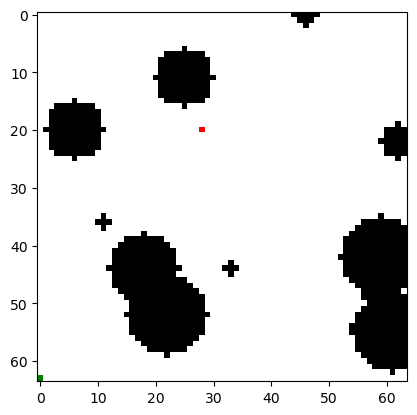

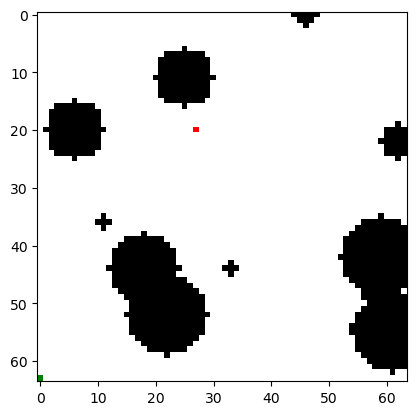

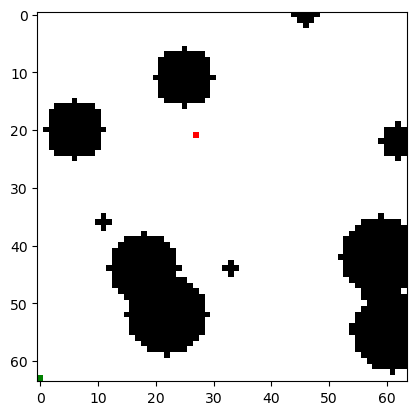

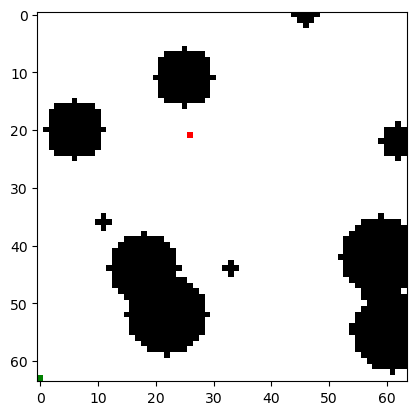

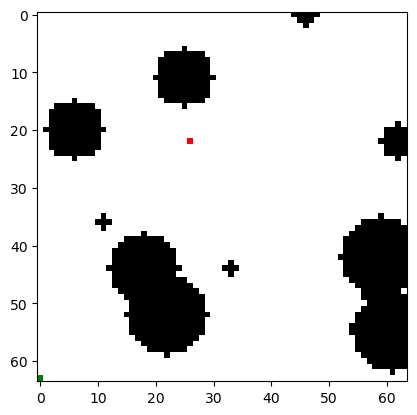

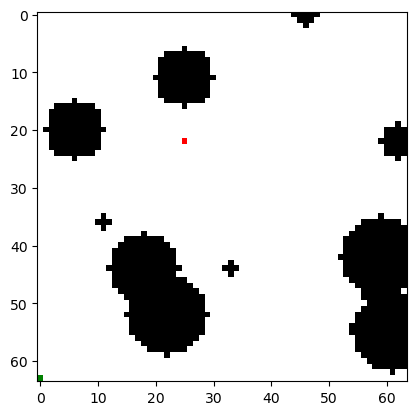

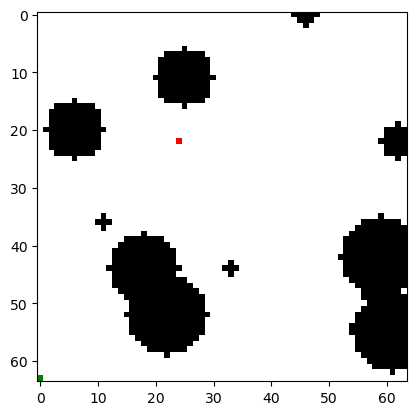

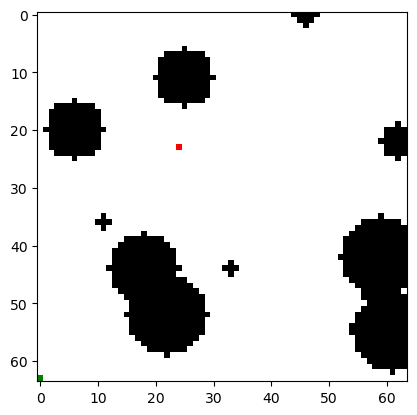

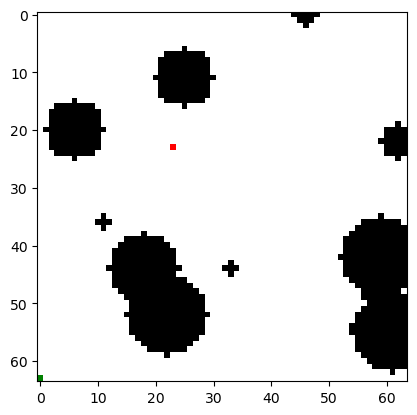

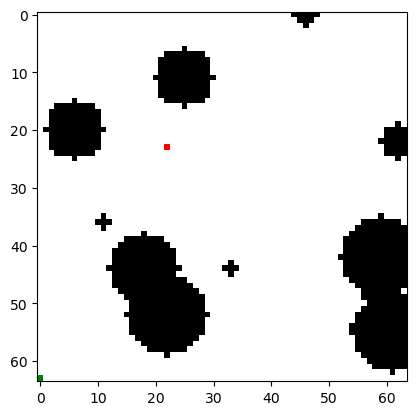

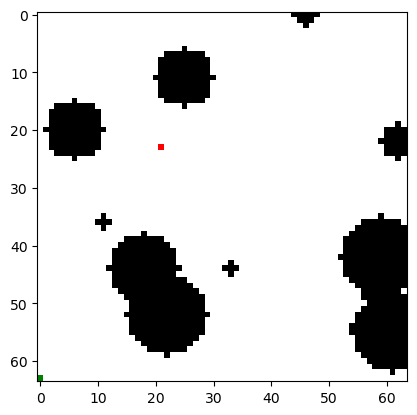

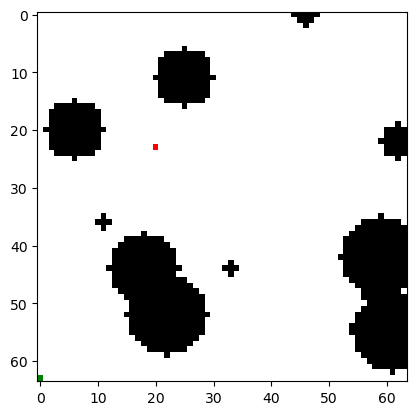

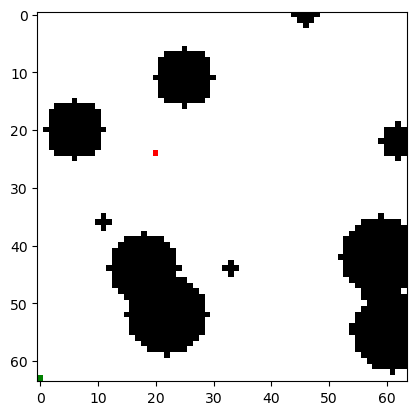

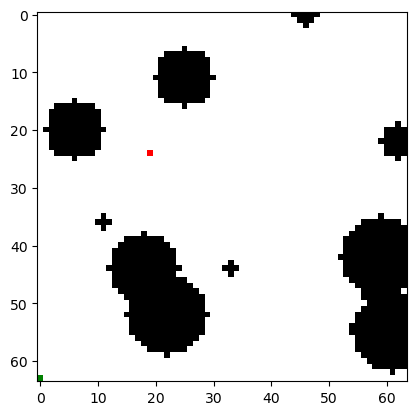

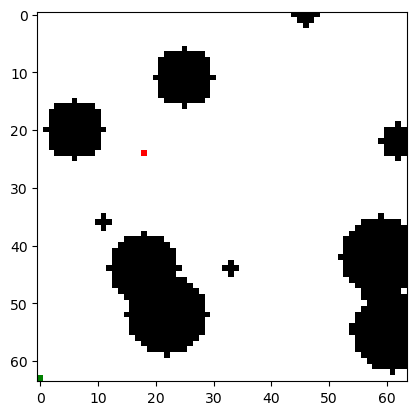

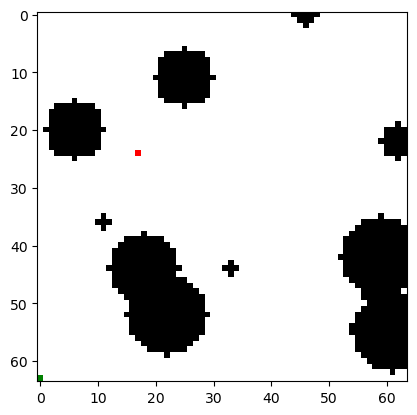

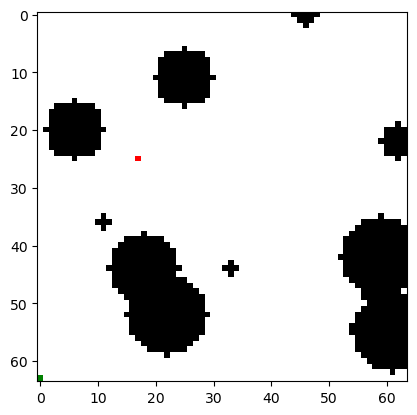

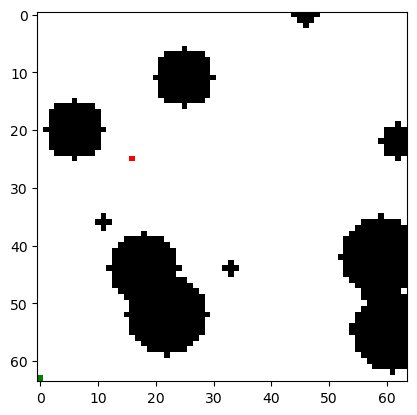

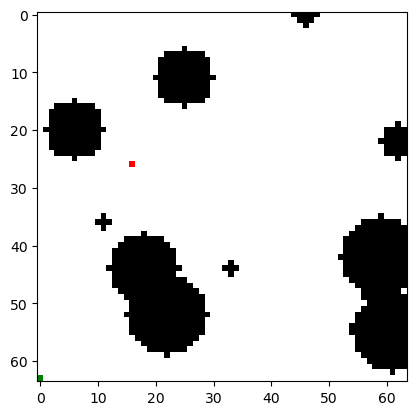

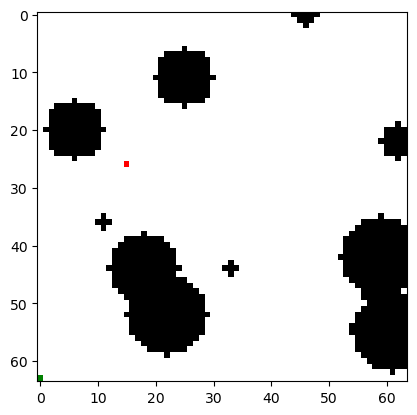

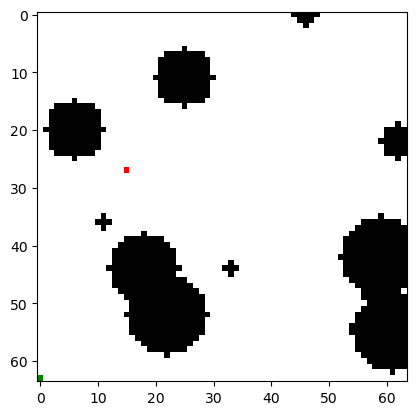

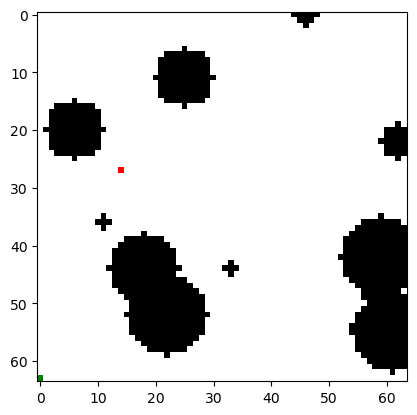

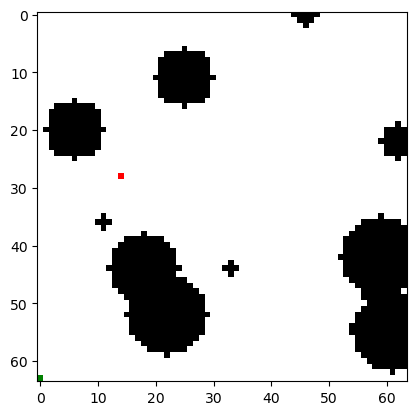

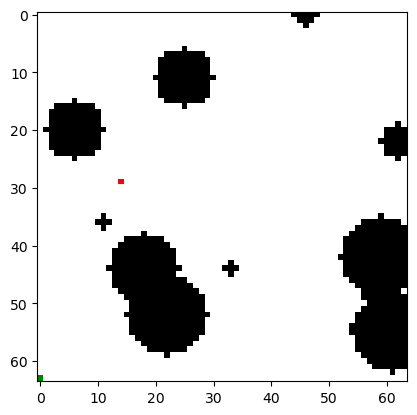

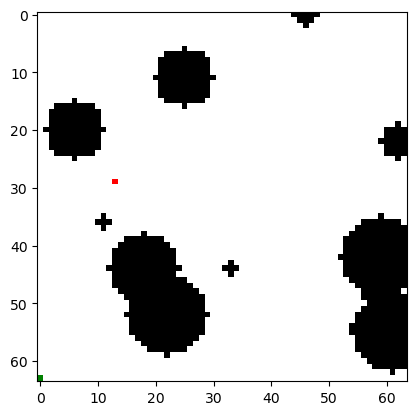

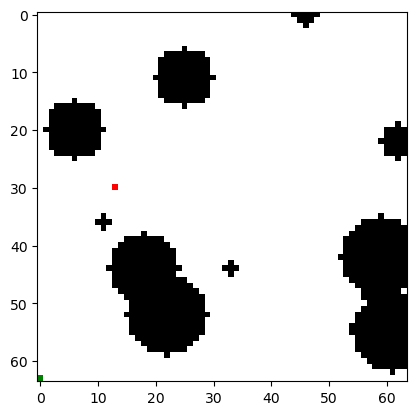

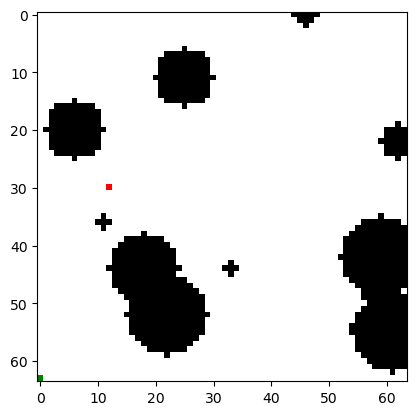

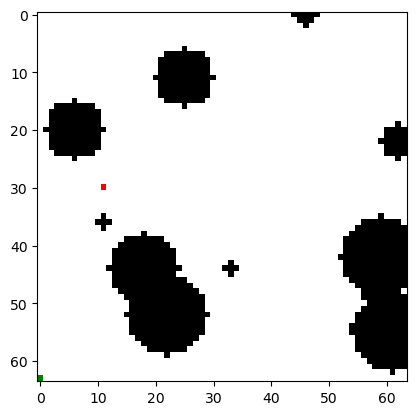

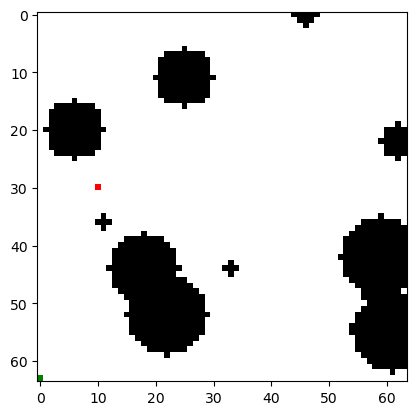

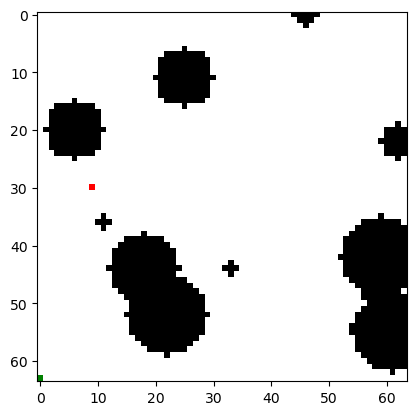

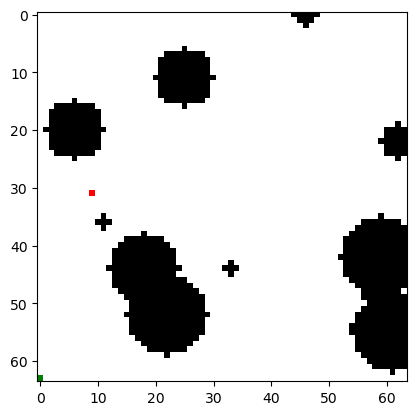

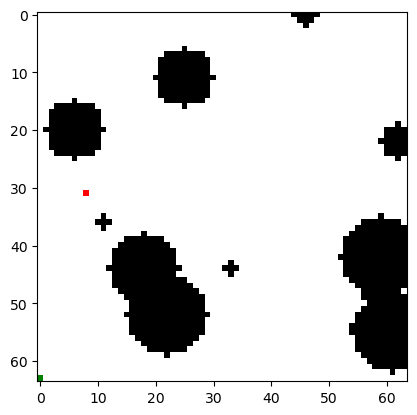

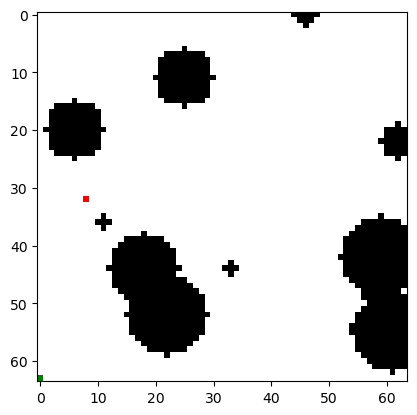

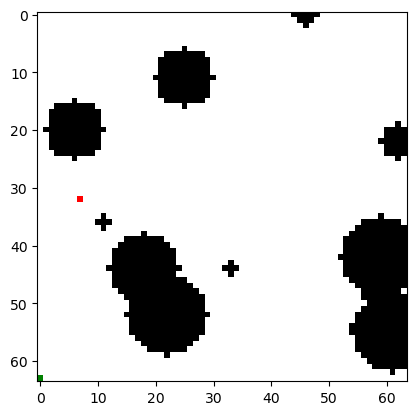

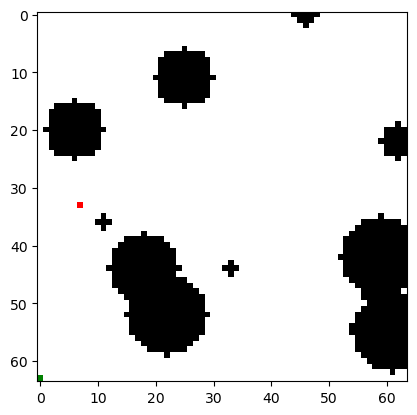

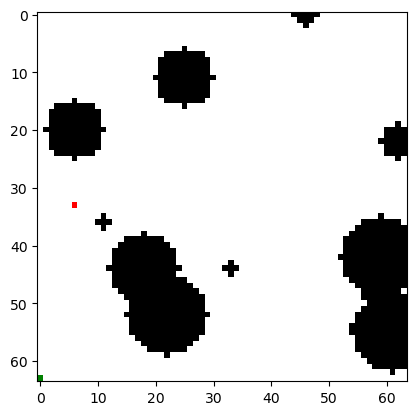

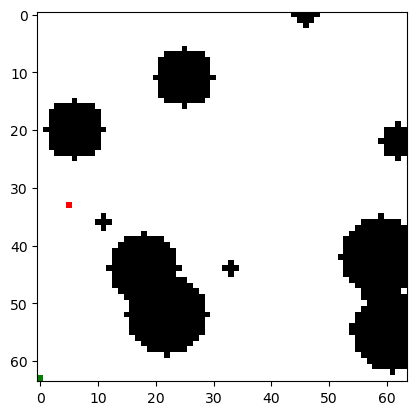

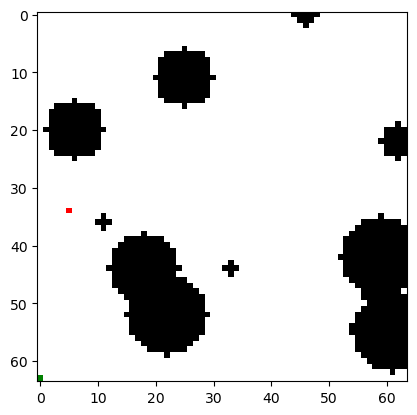

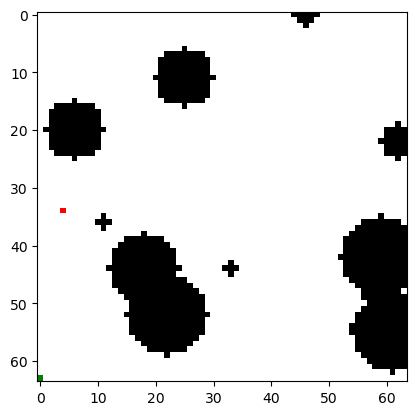

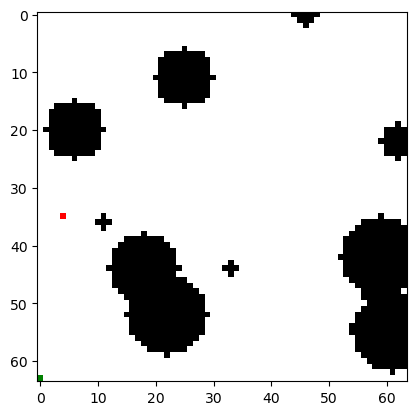

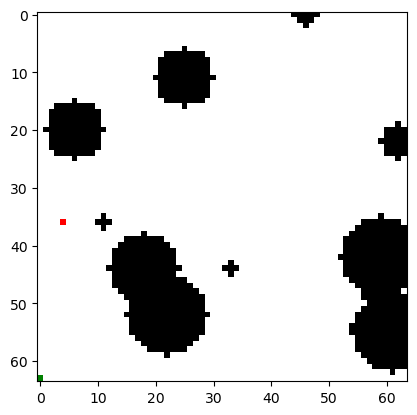

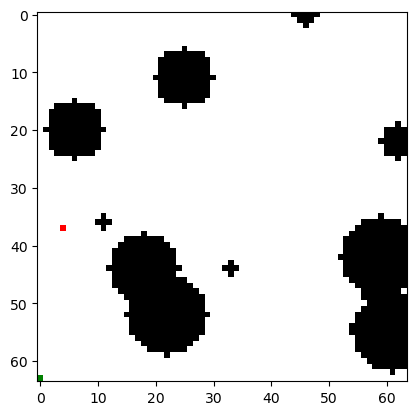

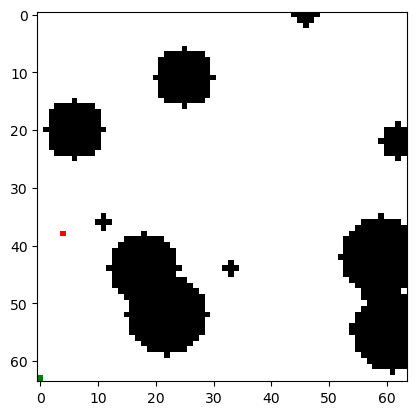

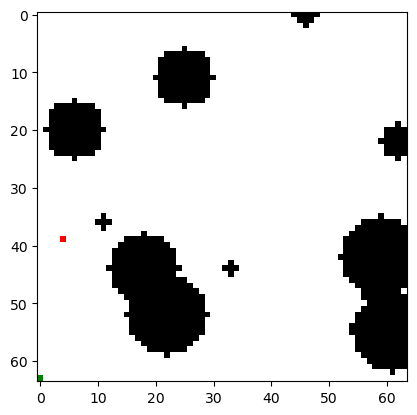

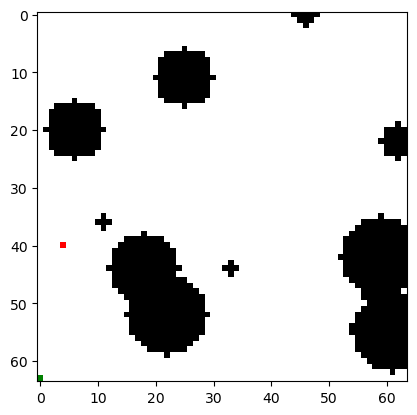

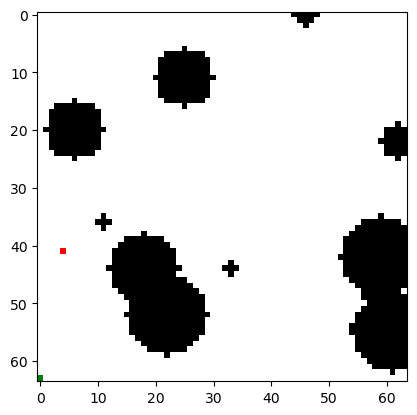

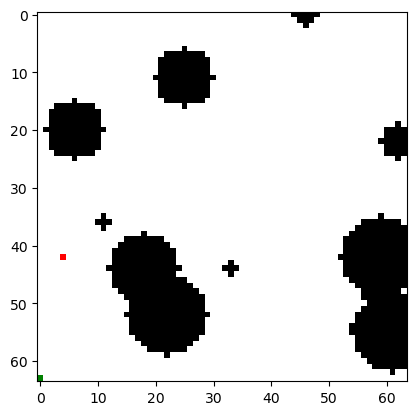

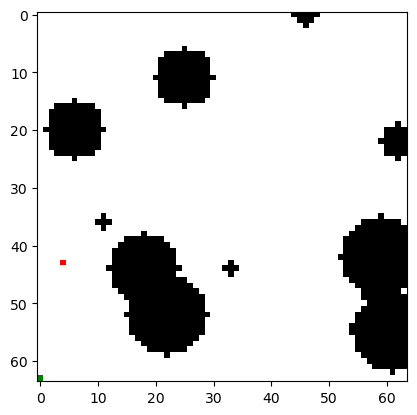

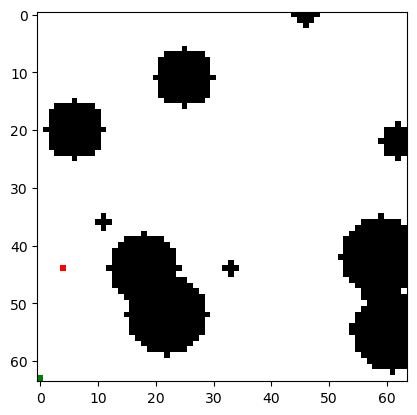

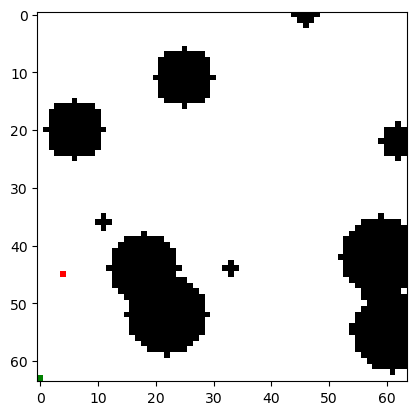

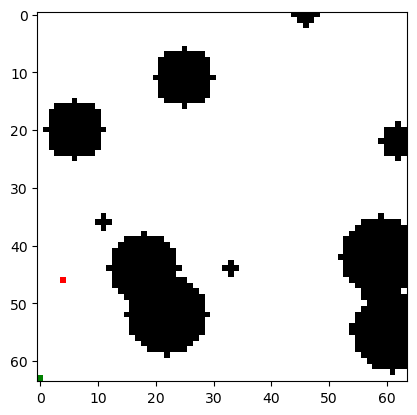

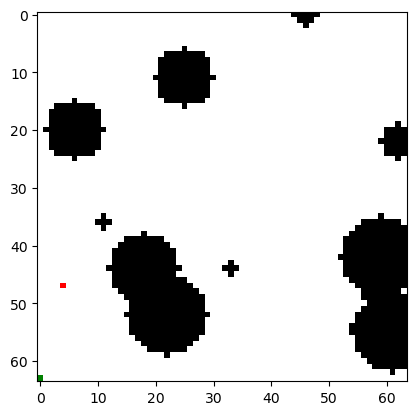

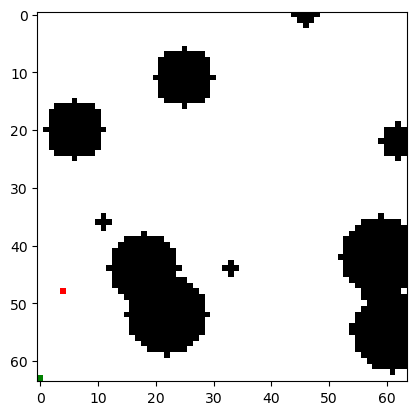

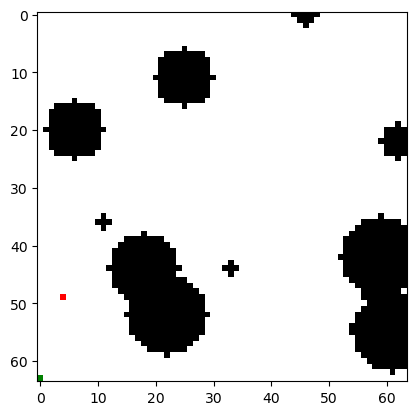

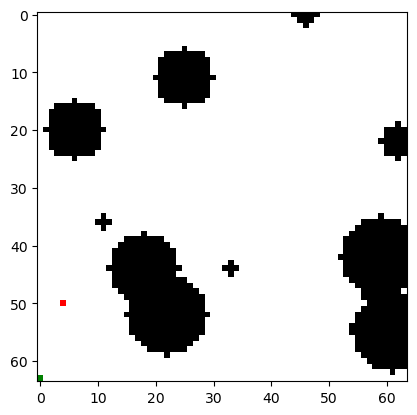

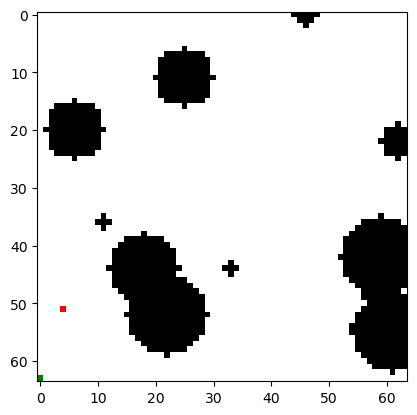

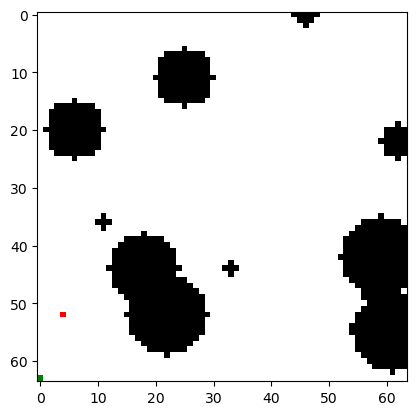

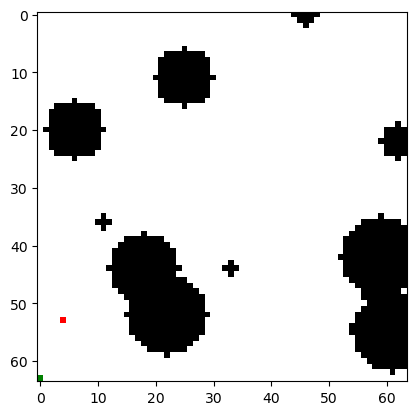

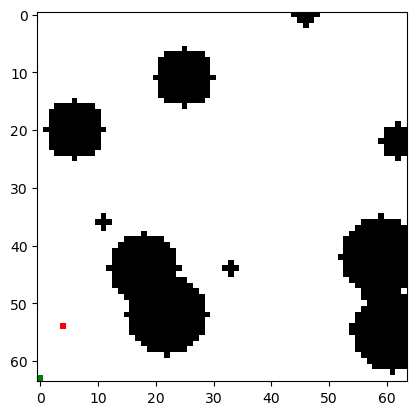

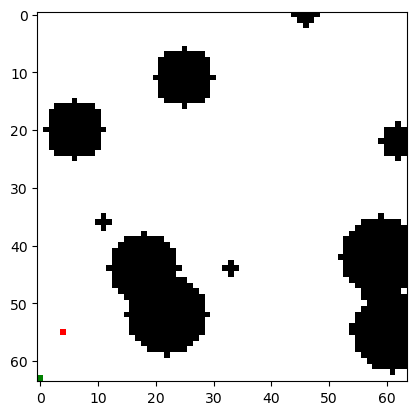

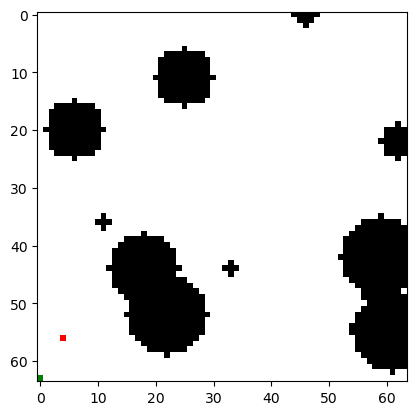

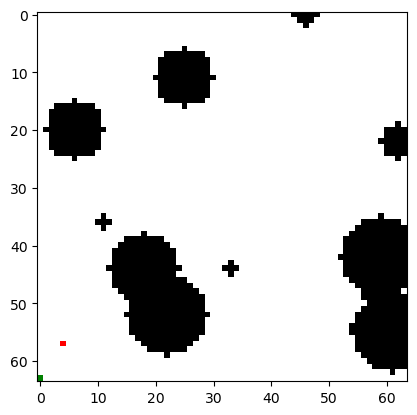

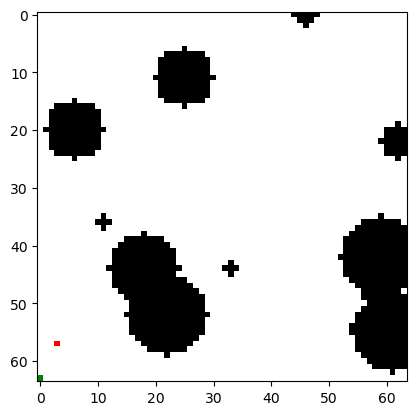

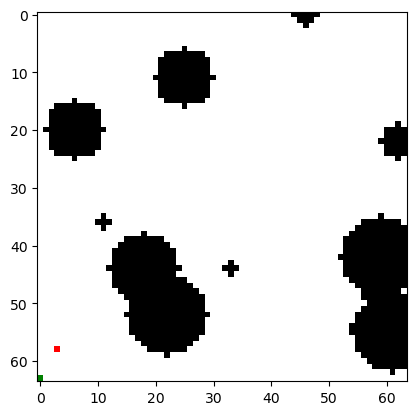

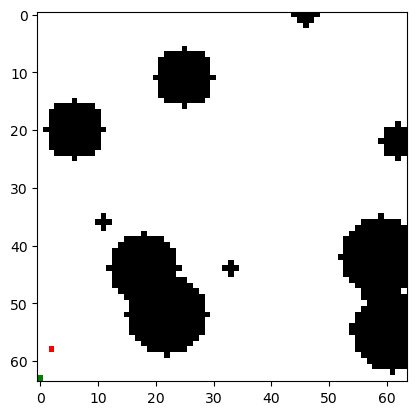

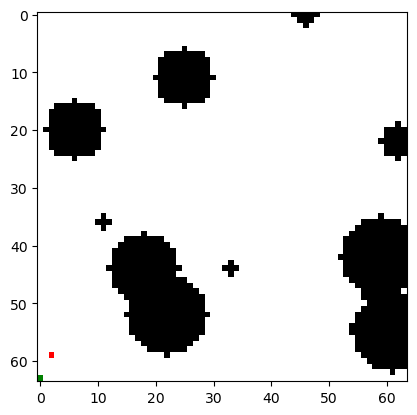

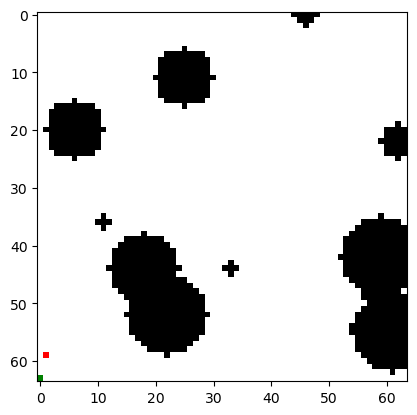

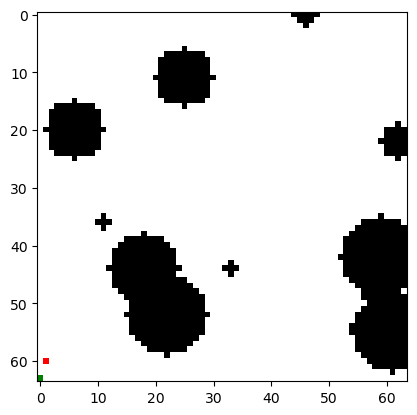

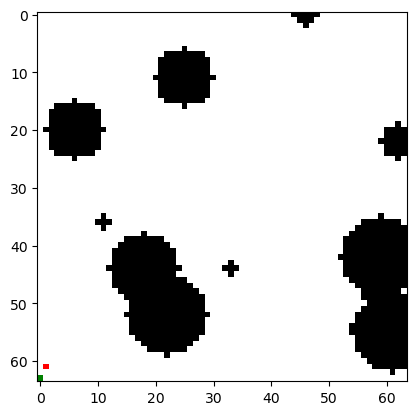

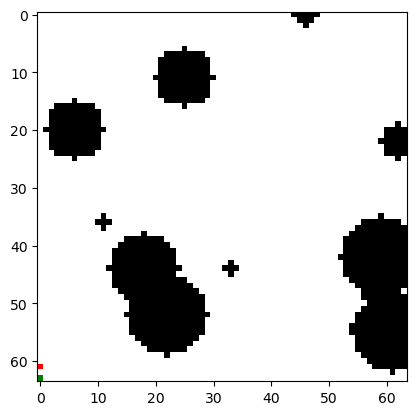

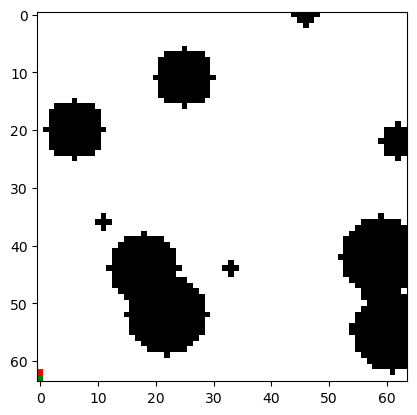

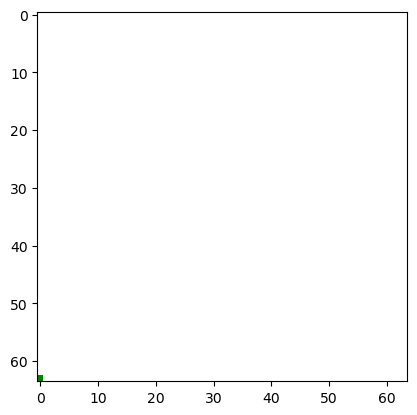

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "green"   # 3
])


start_x = np.random.choice(range(env_size[0]))
start_y = np.random.choice(range(env_size[0]))
start = (start_y, start_x)

max_steps = 1000
goal_x = np.random.choice(range(env_size[0]))
goal_y = np.random.choice(range(env_size[0]))
goal = (goal_y, goal_x)

start = (0,60)
goal = (63,0)
environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]

grid = grid_list[67]

env = GridEnvCNN(grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)


images = []
plt.imshow(np.sum(obs['image'] * np.array([1,3,2]).reshape(3, 1, 1), axis=0), cmap=cmap)
plt.show()


for i in range(200):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    
    plt.imshow(np.sum(obs['image'] * np.array([1,3,2]).reshape(3, 1, 1), axis=0), cmap=cmap)
    plt.show()
    if terminated or truncated:
        break

## Level 6

In [15]:
environments = np.load('../environment_generation/environments/environments_64_15_1000_1.npy')
grid_list = [grid for grid in environments]
env_size = (64,64)

env = DummyVecEnv([make_env(grid_list) for _ in range(512)])
env = VecMonitor(env, filename=None)

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_5", env=env, device='cuda')
model.learn(total_timesteps=6_000_000, progress_bar=True, tb_log_name="Level 6")

Output()

1280


In [16]:
model.save("models/ppo_custom_cnn_64x64_lvl_6")

In [17]:
environments = np.load('../environment_generation/environments/environments_64_15_1000_1.npy')
grid_list = [grid for grid in environments]

model = PPO.load("models/ppo_custom_cnn_64x64_lvl_6", env=env, device='cuda')

test_agent(model, grid_list, goal_region= (64,64), n=100)

1280


100%|██████████| 100/100 [00:30<00:00,  3.29it/s]

terminated:  42.0 % with an average of 37.666666666666664 steps and a maximum of 104


In [14]:
# no pretraining


n_steps           = 256
batch_size        = 512     
n_epochs          = 2       
learning_rate     = 3e-4     
ent_coef          = 0.001    
clip_range        = 0.2
gamma             = 0.995 
gae_lambda        = 0.95
max_grad_norm     = 0.5
normalize_advantage = True

num_envs          = 256
max_steps         = 512

total_timesteps   = 3000000

env_size = (64,64)
environments = np.load('../environment_generation/environments/environments_64_15_1000_1.npy')
grid_list = [grid for grid in environments]




env = DummyVecEnv([make_env(grid_list) for _ in range(num_envs)])
env = VecMonitor(env, filename=None)


model = PPO(CustomCNNPolicy, env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=learning_rate, batch_size=batch_size, n_steps=n_steps, device='cuda', ent_coef= ent_coef, n_epochs = n_epochs, gamma=gamma).learn(total_timesteps=total_timesteps, progress_bar=True, tb_log_name="Level 1")

Output()

1280


In [4]:
test_agent(model, grid_list, goal_region= (64,64), n=100)

NameError: name 'model' is not defined

# BPS

In [3]:
n_steps           = 256
batch_size        = 512     
n_epochs          = 2       
learning_rate     = 3e-4     
ent_coef          = 0.001    
clip_range        = 0.2
gamma             = 0.995 
gae_lambda        = 0.95
max_grad_norm     = 0.5
normalize_advantage = True

num_envs          = 512
max_steps         = 256

total_timesteps   = 2000000

env_size = (64,64)


environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]


env = DummyVecEnv([make_env(grid_list, (0,0), bps_ = True) for _ in range(num_envs)])
env = VecMonitor(env, filename=None)

model = PPO(CustomCNNPolicy, env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=learning_rate, batch_size=batch_size, n_steps=n_steps, device='cpu', ent_coef= ent_coef, n_epochs = n_epochs, gamma=gamma).learn(total_timesteps=total_timesteps, progress_bar=True, tb_log_name="Level 1 BPS")

64


Output()